## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


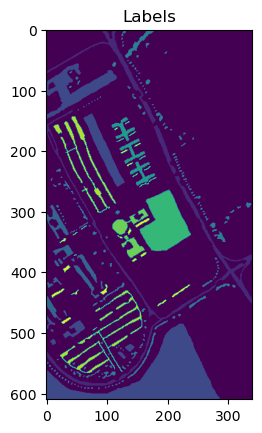

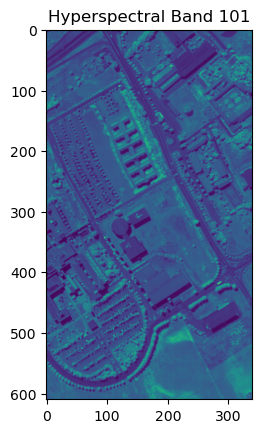

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 10 train


All datasets saved to the 'indices' folder.
(90, 5, 5, 103)
(45, 5, 5, 103)
(42641, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 90
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1149, PSNR: 7.5936


	 Training Batch [200/535], Loss: 0.0592, PSNR: 10.3748


	 Training Batch [400/535], Loss: 0.0285, PSNR: 12.8545


Epoch [1/50] Training Loss: 0.0545, PSNR: 11.2053
	[Val]   Batch [1/134] Loss: 0.0193, PSNR: 15.3502
	[Val]   Batch [10/134] Loss: 0.0170, PSNR: 17.6964
	[Val]   Batch [20/134] Loss: 0.0181, PSNR: 15.5368
	[Val]   Batch [30/134] Loss: 0.0197, PSNR: 14.9815
	[Val]   Batch [40/134] Loss: 0.0178, PSNR: 14.0477
	[Val]   Batch [50/134] Loss: 0.0190, PSNR: 15.1763
	[Val]   Batch [60/134] Loss: 0.0171, PSNR: 15.8667


	[Val]   Batch [70/134] Loss: 0.0164, PSNR: 16.0374
	[Val]   Batch [80/134] Loss: 0.0160, PSNR: 16.0273
	[Val]   Batch [90/134] Loss: 0.0168, PSNR: 16.0108
	[Val]   Batch [100/134] Loss: 0.0190, PSNR: 15.4329
	[Val]   Batch [110/134] Loss: 0.0193, PSNR: 13.9440
	[Val]   Batch [120/134] Loss: 0.0159, PSNR: 15.0948
	[Val]   Batch [130/134] Loss: 0.0174, PSNR: 13.1527
Epoch [1/50] Validation Loss: 0.0182, PSNR: 15.3819

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0167, PSNR: 15.9178


	 Training Batch [200/535], Loss: 0.0124, PSNR: 17.2380


	 Training Batch [400/535], Loss: 0.0107, PSNR: 16.2148


Epoch [2/50] Training Loss: 0.0118, PSNR: 17.3091
	[Val]   Batch [1/134] Loss: 0.0088, PSNR: 18.7350
	[Val]   Batch [10/134] Loss: 0.0071, PSNR: 21.5079
	[Val]   Batch [20/134] Loss: 0.0076, PSNR: 19.2919
	[Val]   Batch [30/134] Loss: 0.0087, PSNR: 18.5311
	[Val]   Batch [40/134] Loss: 0.0077, PSNR: 17.6497
	[Val]   Batch [50/134] Loss: 0.0081, PSNR: 18.8997
	[Val]   Batch [60/134] Loss: 0.0070, PSNR: 19.7321


	[Val]   Batch [70/134] Loss: 0.0068, PSNR: 19.8212
	[Val]   Batch [80/134] Loss: 0.0066, PSNR: 19.8708
	[Val]   Batch [90/134] Loss: 0.0070, PSNR: 19.8079
	[Val]   Batch [100/134] Loss: 0.0083, PSNR: 19.0030
	[Val]   Batch [110/134] Loss: 0.0079, PSNR: 17.8180
	[Val]   Batch [120/134] Loss: 0.0059, PSNR: 19.3984
	[Val]   Batch [130/134] Loss: 0.0071, PSNR: 17.0302
Epoch [2/50] Validation Loss: 0.0079, PSNR: 19.0057

LOG: Epoch [3/50]
	 Training Batch [1/535], Loss: 0.0074, PSNR: 19.5316


	 Training Batch [200/535], Loss: 0.0071, PSNR: 19.7070


	 Training Batch [400/535], Loss: 0.0074, PSNR: 19.5076


Epoch [3/50] Training Loss: 0.0069, PSNR: 19.6703
	[Val]   Batch [1/134] Loss: 0.0061, PSNR: 20.3179
	[Val]   Batch [10/134] Loss: 0.0048, PSNR: 23.1517
	[Val]   Batch [20/134] Loss: 0.0052, PSNR: 20.9650
	[Val]   Batch [30/134] Loss: 0.0059, PSNR: 20.2331
	[Val]   Batch [40/134] Loss: 0.0054, PSNR: 19.2514
	[Val]   Batch [50/134] Loss: 0.0054, PSNR: 20.6598
	[Val]   Batch [60/134] Loss: 0.0047, PSNR: 21.4479


	[Val]   Batch [70/134] Loss: 0.0047, PSNR: 21.4527
	[Val]   Batch [80/134] Loss: 0.0045, PSNR: 21.5466
	[Val]   Batch [90/134] Loss: 0.0048, PSNR: 21.4860
	[Val]   Batch [100/134] Loss: 0.0057, PSNR: 20.6245
	[Val]   Batch [110/134] Loss: 0.0052, PSNR: 19.6623
	[Val]   Batch [120/134] Loss: 0.0037, PSNR: 21.3719
	[Val]   Batch [130/134] Loss: 0.0047, PSNR: 18.8377
Epoch [3/50] Validation Loss: 0.0055, PSNR: 20.6344

LOG: Epoch [4/50]
	 Training Batch [1/535], Loss: 0.0063, PSNR: 20.1956


	 Training Batch [200/535], Loss: 0.0039, PSNR: 20.8059


	 Training Batch [400/535], Loss: 0.0045, PSNR: 22.5549


Epoch [4/50] Training Loss: 0.0050, PSNR: 21.0313
	[Val]   Batch [1/134] Loss: 0.0043, PSNR: 21.8517
	[Val]   Batch [10/134] Loss: 0.0034, PSNR: 24.6266
	[Val]   Batch [20/134] Loss: 0.0035, PSNR: 22.6309
	[Val]   Batch [30/134] Loss: 0.0040, PSNR: 21.9256
	[Val]   Batch [40/134] Loss: 0.0037, PSNR: 20.9044
	[Val]   Batch [50/134] Loss: 0.0035, PSNR: 22.4840
	[Val]   Batch [60/134] Loss: 0.0034, PSNR: 22.8650


	[Val]   Batch [70/134] Loss: 0.0034, PSNR: 22.9134
	[Val]   Batch [80/134] Loss: 0.0032, PSNR: 23.0648
	[Val]   Batch [90/134] Loss: 0.0034, PSNR: 23.0185
	[Val]   Batch [100/134] Loss: 0.0040, PSNR: 22.1819
	[Val]   Batch [110/134] Loss: 0.0034, PSNR: 21.5010
	[Val]   Batch [120/134] Loss: 0.0025, PSNR: 23.1072
	[Val]   Batch [130/134] Loss: 0.0031, PSNR: 20.6249
Epoch [4/50] Validation Loss: 0.0038, PSNR: 22.1852

LOG: Epoch [5/50]
	 Training Batch [1/535], Loss: 0.0064, PSNR: 21.4497


	 Training Batch [200/535], Loss: 0.0043, PSNR: 21.8095


	 Training Batch [400/535], Loss: 0.0037, PSNR: 22.5843


Epoch [5/50] Training Loss: 0.0037, PSNR: 22.3817
	[Val]   Batch [1/134] Loss: 0.0033, PSNR: 23.0319
	[Val]   Batch [10/134] Loss: 0.0026, PSNR: 25.8174
	[Val]   Batch [20/134] Loss: 0.0025, PSNR: 24.0580
	[Val]   Batch [30/134] Loss: 0.0029, PSNR: 23.3382
	[Val]   Batch [40/134] Loss: 0.0026, PSNR: 22.3558
	[Val]   Batch [50/134] Loss: 0.0025, PSNR: 23.9889
	[Val]   Batch [60/134] Loss: 0.0027, PSNR: 23.9468


	[Val]   Batch [70/134] Loss: 0.0026, PSNR: 24.0861
	[Val]   Batch [80/134] Loss: 0.0024, PSNR: 24.2436
	[Val]   Batch [90/134] Loss: 0.0026, PSNR: 24.1644
	[Val]   Batch [100/134] Loss: 0.0030, PSNR: 23.4643
	[Val]   Batch [110/134] Loss: 0.0023, PSNR: 23.1179
	[Val]   Batch [120/134] Loss: 0.0018, PSNR: 24.5217
	[Val]   Batch [130/134] Loss: 0.0022, PSNR: 22.0620
Epoch [5/50] Validation Loss: 0.0029, PSNR: 23.4438

LOG: Epoch [6/50]


	 Training Batch [1/535], Loss: 0.0028, PSNR: 21.4873


	 Training Batch [200/535], Loss: 0.0024, PSNR: 26.1150


	 Training Batch [400/535], Loss: 0.0023, PSNR: 22.5735


Epoch [6/50] Training Loss: 0.0030, PSNR: 23.2896
	[Val]   Batch [1/134] Loss: 0.0028, PSNR: 23.7618
	[Val]   Batch [10/134] Loss: 0.0022, PSNR: 26.5966
	[Val]   Batch [20/134] Loss: 0.0020, PSNR: 25.0401
	[Val]   Batch [30/134] Loss: 0.0023, PSNR: 24.2644
	[Val]   Batch [40/134] Loss: 0.0021, PSNR: 23.3097
	[Val]   Batch [50/134] Loss: 0.0020, PSNR: 24.9633
	[Val]   Batch [60/134] Loss: 0.0023, PSNR: 24.6471


	[Val]   Batch [70/134] Loss: 0.0021, PSNR: 24.8565
	[Val]   Batch [80/134] Loss: 0.0020, PSNR: 25.0116
	[Val]   Batch [90/134] Loss: 0.0022, PSNR: 24.8870
	[Val]   Batch [100/134] Loss: 0.0024, PSNR: 24.3210
	[Val]   Batch [110/134] Loss: 0.0018, PSNR: 24.2312
	[Val]   Batch [120/134] Loss: 0.0014, PSNR: 25.5052
	[Val]   Batch [130/134] Loss: 0.0018, PSNR: 22.9691
Epoch [6/50] Validation Loss: 0.0024, PSNR: 24.2793

LOG: Epoch [7/50]


	 Training Batch [1/535], Loss: 0.0024, PSNR: 25.2114


	 Training Batch [200/535], Loss: 0.0031, PSNR: 23.3422


	 Training Batch [400/535], Loss: 0.0019, PSNR: 25.2780


Epoch [7/50] Training Loss: 0.0026, PSNR: 23.8925
	[Val]   Batch [1/134] Loss: 0.0025, PSNR: 24.2553
	[Val]   Batch [10/134] Loss: 0.0019, PSNR: 27.1378
	[Val]   Batch [20/134] Loss: 0.0017, PSNR: 25.7207
	[Val]   Batch [30/134] Loss: 0.0020, PSNR: 24.8798
	[Val]   Batch [40/134] Loss: 0.0018, PSNR: 24.0016
	[Val]   Batch [50/134] Loss: 0.0017, PSNR: 25.6437
	[Val]   Batch [60/134] Loss: 0.0020, PSNR: 25.1525


	[Val]   Batch [70/134] Loss: 0.0019, PSNR: 25.3865
	[Val]   Batch [80/134] Loss: 0.0018, PSNR: 25.5644
	[Val]   Batch [90/134] Loss: 0.0019, PSNR: 25.3999
	[Val]   Batch [100/134] Loss: 0.0021, PSNR: 24.9237
	[Val]   Batch [110/134] Loss: 0.0015, PSNR: 24.9538
	[Val]   Batch [120/134] Loss: 0.0012, PSNR: 26.2096
	[Val]   Batch [130/134] Loss: 0.0016, PSNR: 23.5675


Epoch [7/50] Validation Loss: 0.0021, PSNR: 24.8537

LOG: Epoch [8/50]
	 Training Batch [1/535], Loss: 0.0021, PSNR: 24.9198


	 Training Batch [200/535], Loss: 0.0019, PSNR: 25.2230


	 Training Batch [400/535], Loss: 0.0023, PSNR: 24.3947


Epoch [8/50] Training Loss: 0.0023, PSNR: 24.3726
	[Val]   Batch [1/134] Loss: 0.0022, PSNR: 24.7842
	[Val]   Batch [10/134] Loss: 0.0017, PSNR: 27.6754
	[Val]   Batch [20/134] Loss: 0.0015, PSNR: 26.4619
	[Val]   Batch [30/134] Loss: 0.0017, PSNR: 25.5513
	[Val]   Batch [40/134] Loss: 0.0015, PSNR: 24.7315
	[Val]   Batch [50/134] Loss: 0.0015, PSNR: 26.3411


	[Val]   Batch [60/134] Loss: 0.0018, PSNR: 25.6715
	[Val]   Batch [70/134] Loss: 0.0017, PSNR: 25.9278
	[Val]   Batch [80/134] Loss: 0.0016, PSNR: 26.1414
	[Val]   Batch [90/134] Loss: 0.0017, PSNR: 25.9185
	[Val]   Batch [100/134] Loss: 0.0019, PSNR: 25.5306
	[Val]   Batch [110/134] Loss: 0.0013, PSNR: 25.7748
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 26.9497
	[Val]   Batch [130/134] Loss: 0.0014, PSNR: 24.2173
Epoch [8/50] Validation Loss: 0.0018, PSNR: 25.4695

LOG: Epoch [9/50]


	 Training Batch [1/535], Loss: 0.0017, PSNR: 27.7010


	 Training Batch [200/535], Loss: 0.0019, PSNR: 25.3219


	 Training Batch [400/535], Loss: 0.0017, PSNR: 24.4813


Epoch [9/50] Training Loss: 0.0021, PSNR: 24.7568
	[Val]   Batch [1/134] Loss: 0.0021, PSNR: 25.0170
	[Val]   Batch [10/134] Loss: 0.0016, PSNR: 27.9011
	[Val]   Batch [20/134] Loss: 0.0014, PSNR: 26.7826
	[Val]   Batch [30/134] Loss: 0.0016, PSNR: 25.8675
	[Val]   Batch [40/134] Loss: 0.0014, PSNR: 25.0609
	[Val]   Batch [50/134] Loss: 0.0014, PSNR: 26.6128
	[Val]   Batch [60/134] Loss: 0.0017, PSNR: 25.9174


	[Val]   Batch [70/134] Loss: 0.0016, PSNR: 26.1700
	[Val]   Batch [80/134] Loss: 0.0015, PSNR: 26.3966
	[Val]   Batch [90/134] Loss: 0.0016, PSNR: 26.1468
	[Val]   Batch [100/134] Loss: 0.0017, PSNR: 25.8255
	[Val]   Batch [110/134] Loss: 0.0012, PSNR: 26.1237
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 27.2578
	[Val]   Batch [130/134] Loss: 0.0013, PSNR: 24.4719
Epoch [9/50] Validation Loss: 0.0017, PSNR: 25.7496

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 25.8475


	 Training Batch [200/535], Loss: 0.0016, PSNR: 25.9505


	 Training Batch [400/535], Loss: 0.0020, PSNR: 25.2219


Epoch [10/50] Training Loss: 0.0020, PSNR: 25.0272
	[Val]   Batch [1/134] Loss: 0.0020, PSNR: 25.2622
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.1507
	[Val]   Batch [20/134] Loss: 0.0013, PSNR: 27.1351
	[Val]   Batch [30/134] Loss: 0.0015, PSNR: 26.1579
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.3880
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.9233
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.1704


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.4137
	[Val]   Batch [80/134] Loss: 0.0014, PSNR: 26.6788
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.4189
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.1057
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.4862
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.5870
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.7871
Epoch [10/50] Validation Loss: 0.0016, PSNR: 26.0366

LOG: Epoch [11/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 24.2681


	 Training Batch [200/535], Loss: 0.0025, PSNR: 24.1947


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.7978


Epoch [11/50] Training Loss: 0.0019, PSNR: 25.2897
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.5559
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.4599
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.5600
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.5195
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.8115
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.2887
	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.5010


	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.7291
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 27.0458
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.7298
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.4397
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.9281
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.0123
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.1744
Epoch [11/50] Validation Loss: 0.0015, PSNR: 26.3898

LOG: Epoch [12/50]
	 Training Batch [1/535], Loss: 0.0023, PSNR: 24.6150


	 Training Batch [200/535], Loss: 0.0011, PSNR: 26.2289


	 Training Batch [400/535], Loss: 0.0021, PSNR: 25.9028


Epoch [12/50] Training Loss: 0.0018, PSNR: 25.4740
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.7154
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.6474
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.7606
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.7228
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.0228
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.4565
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.6835


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 26.8988
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.2369
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.8887
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.6153
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.1461
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.2135
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.3434
Epoch [12/50] Validation Loss: 0.0014, PSNR: 26.5840

LOG: Epoch [13/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 26.5204


	 Training Batch [200/535], Loss: 0.0010, PSNR: 26.2074


	 Training Batch [400/535], Loss: 0.0021, PSNR: 24.8933


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.6802
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.9597
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.9255
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.1361
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.0213
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.4079
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.7929
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 26.9755


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.1854
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.5826
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.1978
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.9051
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.5441
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.6278
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.7310
Epoch [13/50] Validation Loss: 0.0013, PSNR: 26.9052

LOG: Epoch [14/50]
	 Training Batch [1/535], Loss: 0.0020, PSNR: 25.2049


	 Training Batch [200/535], Loss: 0.0021, PSNR: 24.9759


	 Training Batch [400/535], Loss: 0.0020, PSNR: 25.1370


Epoch [14/50] Training Loss: 0.0017, PSNR: 25.8772
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.1252
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.1013
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.3354
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.1741
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.5492
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.9237
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 27.1169


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.3377
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.7592
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.3530
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.0441
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.7095
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.7789
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.8357
Epoch [14/50] Validation Loss: 0.0013, PSNR: 27.0608

LOG: Epoch [15/50]
	 Training Batch [1/535], Loss: 0.0017, PSNR: 25.9620


	 Training Batch [200/535], Loss: 0.0016, PSNR: 25.8245


	 Training Batch [400/535], Loss: 0.0017, PSNR: 26.0169


Epoch [15/50] Training Loss: 0.0016, PSNR: 26.0370
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.3683
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.3401
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.6784
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.4714
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.8632
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.2263
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.3940


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.5610
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.0511
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.6214
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.2744
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.0604
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.0976
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.1481
Epoch [15/50] Validation Loss: 0.0012, PSNR: 27.3435

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 27.0466


	 Training Batch [200/535], Loss: 0.0025, PSNR: 24.3703


	 Training Batch [400/535], Loss: 0.0019, PSNR: 25.4269


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.1867
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.5579
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.5573
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 28.9386
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.7248
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.1969
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.4856
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.6129


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.7849
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.3158
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.8334
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.5036
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.3745
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.3522
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.4757
Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.5923

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.2155


	 Training Batch [200/535], Loss: 0.0010, PSNR: 27.8661


	 Training Batch [400/535], Loss: 0.0017, PSNR: 25.9018


Epoch [17/50] Training Loss: 0.0015, PSNR: 26.3741
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.6999
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.6891
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.1400
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.8589
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.3399
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.6177
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.7734


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.9262
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.5009
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 28.0006
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.6326
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.4994
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.4944
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.6157
Epoch [17/50] Validation Loss: 0.0011, PSNR: 27.7402

LOG: Epoch [18/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.7539


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.1119


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.2848


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.4806
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 26.9221
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.8941
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.4615
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 28.1389
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.6505
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.9078
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.0362


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.1715
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.7712
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.2464
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.8754
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.8082
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.7612
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.9231
Epoch [18/50] Validation Loss: 0.0010, PSNR: 28.0067

LOG: Epoch [19/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 27.9263


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.4651


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.4345


Epoch [19/50] Training Loss: 0.0014, PSNR: 26.6692
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.0448
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.9599
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.5517
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.2253
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.7640
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.9410
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.1508


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.2899
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.8942
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.3741
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.0017
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.7616
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.7507
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.0044
Epoch [19/50] Validation Loss: 0.0010, PSNR: 28.0991

LOG: Epoch [20/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 28.1631


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.4590


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.0400


Epoch [20/50] Training Loss: 0.0013, PSNR: 26.7846
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.2654
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.1154
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.8845
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.4926
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.0162
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.1838
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.4635


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.5520
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.1315
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.6029
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.2328
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.9878
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.9480
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.2746
Epoch [20/50] Validation Loss: 0.0010, PSNR: 28.3426

LOG: Epoch [21/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 27.1082


	 Training Batch [200/535], Loss: 0.0019, PSNR: 25.5763


	 Training Batch [400/535], Loss: 0.0010, PSNR: 25.9058


Epoch [21/50] Training Loss: 0.0013, PSNR: 26.9567
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.4883
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.2848
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.1761
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.7484
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.2582
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.3898
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.7742


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.8434
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.4164
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.8946
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.4960
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.1051
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.0992
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.5153
Epoch [21/50] Validation Loss: 0.0009, PSNR: 28.5861

LOG: Epoch [22/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 27.1892


	 Training Batch [200/535], Loss: 0.0013, PSNR: 27.0054


	 Training Batch [400/535], Loss: 0.0011, PSNR: 27.5759


Epoch [22/50] Training Loss: 0.0012, PSNR: 27.1304
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.7291
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.4440
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.4761
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 29.0670
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.4896
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.6149
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.1016


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.1125
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.6641
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.1953
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.7780
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.2678
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.2172
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.7408
Epoch [22/50] Validation Loss: 0.0009, PSNR: 28.8347

LOG: Epoch [23/50]


	 Training Batch [1/535], Loss: 0.0015, PSNR: 28.2073


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.7174


	 Training Batch [400/535], Loss: 0.0008, PSNR: 26.9471


Epoch [23/50] Training Loss: 0.0012, PSNR: 27.3881
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.0579
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.6650
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.7519
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.4107
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.8322
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 29.9147


	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.4312
	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.4861
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.0044
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.5521
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.1071
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.4348
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.3952


	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 28.0720
Epoch [23/50] Validation Loss: 0.0008, PSNR: 29.1408

LOG: Epoch [24/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 26.4310


	 Training Batch [200/535], Loss: 0.0010, PSNR: 27.8620


	 Training Batch [400/535], Loss: 0.0012, PSNR: 25.9026


Epoch [24/50] Training Loss: 0.0011, PSNR: 27.5258
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.3109
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.8464
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.0059
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.7279
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 29.0186
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.1878
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.7064


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.7447
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.2617
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.8403
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.4341
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.6049
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.4445
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.2707
Epoch [24/50] Validation Loss: 0.0008, PSNR: 29.3914

LOG: Epoch [25/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 28.3862


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.6136


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.1120


Epoch [25/50] Training Loss: 0.0011, PSNR: 27.7558
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.5533
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.0475
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.1711
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 29.9476
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.2119
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.3544
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.9606


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.0783
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.4453
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 30.1228
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.6558
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.6206
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.5710
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.4440
Epoch [25/50] Validation Loss: 0.0007, PSNR: 29.6095

LOG: Epoch [26/50]
	 Training Batch [1/535], Loss: 0.0007, PSNR: 27.8499


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.7578


	 Training Batch [400/535], Loss: 0.0008, PSNR: 30.8076


Epoch [26/50] Training Loss: 0.0010, PSNR: 27.9282
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 28.9451
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.3848
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.5676
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.4214
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.5911
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.8453
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.2939


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.4789
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.8537
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.5718
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.1301
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.0187
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8986
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.7955
Epoch [26/50] Validation Loss: 0.0006, PSNR: 30.0235

LOG: Epoch [27/50]
	 Training Batch [1/535], Loss: 0.0017, PSNR: 27.1388


	 Training Batch [200/535], Loss: 0.0014, PSNR: 27.0392


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.6343


Epoch [27/50] Training Loss: 0.0010, PSNR: 28.0950
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.2067
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.5441
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.6500
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.5722
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.6031
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.9332
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.4147


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.6607
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.9609
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.7319
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.2945
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9837
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8851
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.8106
Epoch [27/50] Validation Loss: 0.0006, PSNR: 30.1528

LOG: Epoch [28/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.8193


	 Training Batch [200/535], Loss: 0.0011, PSNR: 29.7239


	 Training Batch [400/535], Loss: 0.0008, PSNR: 28.1508


Epoch [28/50] Training Loss: 0.0010, PSNR: 28.2615
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.3317
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.6232
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.6105
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.6724
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.5101
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.9914
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.4810


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.7294
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.9412
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.8606
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.4214
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9049
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8370
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.7061
Epoch [28/50] Validation Loss: 0.0006, PSNR: 30.2048

LOG: Epoch [29/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.5762


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.3252


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.7293


Epoch [29/50] Training Loss: 0.0009, PSNR: 28.4255
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.7264
	[Val]   Batch [10/134] Loss: 0.0006, PSNR: 31.9380
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.0822
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 31.2045
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.9641
	[Val]   Batch [50/134] Loss: 0.0004, PSNR: 31.4759
	[Val]   Batch [60/134] Loss: 0.0005, PSNR: 30.8334


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.1506
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.3556
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.2536
	[Val]   Batch [100/134] Loss: 0.0005, PSNR: 30.8740
	[Val]   Batch [110/134] Loss: 0.0004, PSNR: 30.3437
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.1602
	[Val]   Batch [130/134] Loss: 0.0004, PSNR: 29.1697
Epoch [29/50] Validation Loss: 0.0006, PSNR: 30.6414
Early stopping triggered at epoch 29. No improvement for 3 epochs.


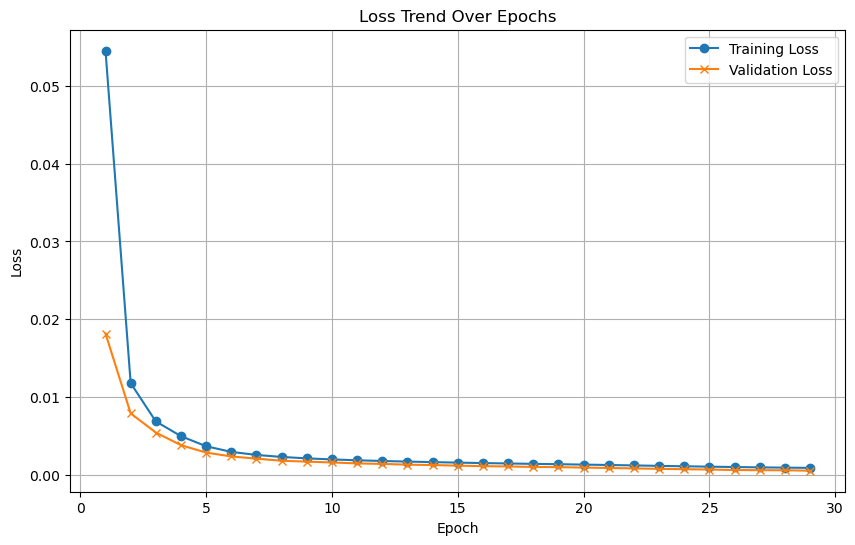

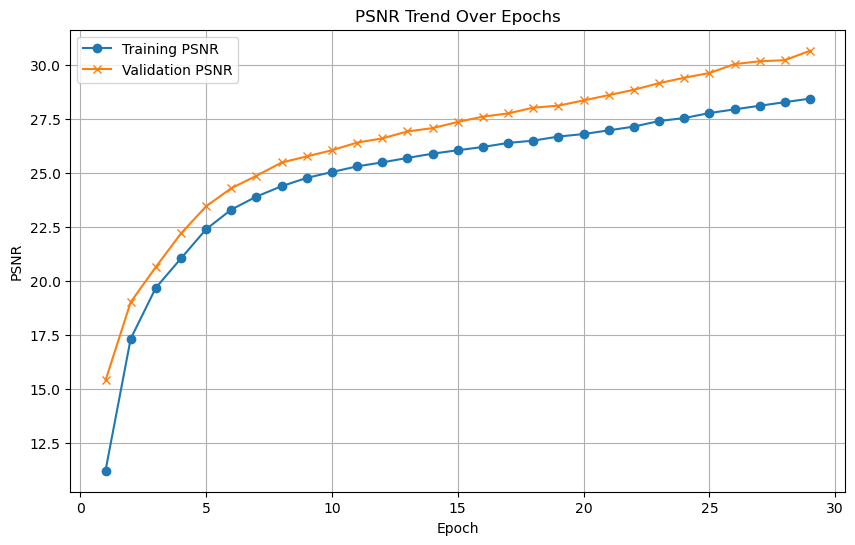

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/167 for test dataset.


    Processed batch 101/167 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2279
    Validation Batch [1/1], Loss: 2.2043
Validation Loss: 2.2043, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2043. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1648
    Validation Batch [1/1], Loss: 2.2043
Validation Loss: 2.2043, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1185
    Validation Batch [1/1], Loss: 2.2044
Validation Loss: 2.2044, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0926
    Validation Batch [1/1], Loss: 2.2044
Validation Loss: 2.2044, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Averag

Epoch [21/1000] completed, Average Training Loss: 1.8205
    Validation Batch [1/1], Loss: 2.1956
Validation Loss: 2.1956, Validation Accuracy: 11.11%
Validation loss improved from 2.1981 to 2.1956. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 1.8060
    Validation Batch [1/1], Loss: 2.1922
Validation Loss: 2.1922, Validation Accuracy: 17.78%
Validation loss improved from 2.1956 to 2.1922. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 1.8119
    Validation Batch [1/1], Loss: 2.1881
Validation Loss: 2.1881, Validation Accuracy: 20.00%
Validation loss improved from 2.1922 to 2.1881. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 1.7884
    Validation Batch [1/1], Loss: 2.1830
Validation Loss: 2.1830, Validation Accuracy: 20.00%
Validation loss improved from 2.1881 to 2.1830. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [2

Epoch [53/1000] completed, Average Training Loss: 1.5319
    Validation Batch [1/1], Loss: 1.7478
Validation Loss: 1.7478, Validation Accuracy: 44.44%
Validation loss improved from 1.7634 to 1.7478. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 1.5407
    Validation Batch [1/1], Loss: 1.7318
Validation Loss: 1.7318, Validation Accuracy: 44.44%
Validation loss improved from 1.7478 to 1.7318. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 1.5427
    Validation Batch [1/1], Loss: 1.7144
Validation Loss: 1.7144, Validation Accuracy: 44.44%
Validation loss improved from 1.7318 to 1.7144. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 1.4992
    Validation Batch [1/1], Loss: 1.6982
Validation Loss: 1.6982, Validation Accuracy: 44.44%
Validation loss improved from 1.7144 to 1.6982. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [5

    Validation Batch [1/1], Loss: 1.4081
Validation Loss: 1.4081, Validation Accuracy: 60.00%
Validation loss improved from 1.4159 to 1.4081. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.3172
    Validation Batch [1/1], Loss: 1.4073
Validation Loss: 1.4073, Validation Accuracy: 57.78%
Validation loss improved from 1.4081 to 1.4073. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.2828
    Validation Batch [1/1], Loss: 1.4049
Validation Loss: 1.4049, Validation Accuracy: 57.78%
Validation loss improved from 1.4073 to 1.4049. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.2575
    Validation Batch [1/1], Loss: 1.3980
Validation Loss: 1.3980, Validation Accuracy: 57.78%
Validation loss improved from 1.4049 to 1.3980. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 1.2580
    Vali

Epoch [117/1000] completed, Average Training Loss: 1.0655
    Validation Batch [1/1], Loss: 1.2137
Validation Loss: 1.2137, Validation Accuracy: 64.44%
Validation loss improved from 1.2157 to 1.2137. Saving model...

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 1.0374
    Validation Batch [1/1], Loss: 1.2171
Validation Loss: 1.2171, Validation Accuracy: 64.44%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 1.0162
    Validation Batch [1/1], Loss: 1.2176
Validation Loss: 1.2176, Validation Accuracy: 64.44%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.0174
    Validation Batch [1/1], Loss: 1.2095
Validation Loss: 1.2095, Validation Accuracy: 66.67%
Validation loss improved from 1.2137 to 1.2095. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Av

Epoch [151/1000] completed, Average Training Loss: 0.8011
    Validation Batch [1/1], Loss: 1.0343
Validation Loss: 1.0343, Validation Accuracy: 71.11%
Validation loss improved from 1.0375 to 1.0343. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 0.8416
    Validation Batch [1/1], Loss: 1.0254
Validation Loss: 1.0254, Validation Accuracy: 68.89%
Validation loss improved from 1.0343 to 1.0254. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 0.8008
    Validation Batch [1/1], Loss: 1.0197
Validation Loss: 1.0197, Validation Accuracy: 68.89%
Validation loss improved from 1.0254 to 1.0197. Saving model...

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 0.7714
    Validation Batch [1/1], Loss: 1.0099
Validation Loss: 1.0099, Validation Accuracy: 71.11%
Validation loss improved from 1.0197 to 1.0099. Saving model...

LOG: Epoch [155/1000] - Training


    Validation Batch [1/1], Loss: 0.8896
Validation Loss: 0.8896, Validation Accuracy: 75.56%
Validation loss improved from 0.8943 to 0.8896. Saving model...

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 0.5623
    Validation Batch [1/1], Loss: 0.8760
Validation Loss: 0.8760, Validation Accuracy: 75.56%
Validation loss improved from 0.8896 to 0.8760. Saving model...

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 0.5743
    Validation Batch [1/1], Loss: 0.8632
Validation Loss: 0.8632, Validation Accuracy: 75.56%
Validation loss improved from 0.8760 to 0.8632. Saving model...

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training Loss: 0.5635
    Validation Batch [1/1], Loss: 0.8612
Validation Loss: 0.8612, Validation Accuracy: 77.78%
Validation loss improved from 0.8632 to 0.8612. Saving model...

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 0.5548


    Validation Batch [1/1], Loss: 0.7787
Validation Loss: 0.7787, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.4281
    Validation Batch [1/1], Loss: 0.7475
Validation Loss: 0.7475, Validation Accuracy: 82.22%
Validation loss improved from 0.7585 to 0.7475. Saving model...

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.4384
    Validation Batch [1/1], Loss: 0.7281
Validation Loss: 0.7281, Validation Accuracy: 84.44%
Validation loss improved from 0.7475 to 0.7281. Saving model...

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.3954
    Validation Batch [1/1], Loss: 0.7385
Validation Loss: 0.7385, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.4627
    Validation Batch [1/1], Lo

Epoch [242/1000] completed, Average Training Loss: 0.3051
    Validation Batch [1/1], Loss: 0.6724
Validation Loss: 0.6724, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.3168
    Validation Batch [1/1], Loss: 0.6455
Validation Loss: 0.6455, Validation Accuracy: 80.00%
Validation loss improved from 0.6532 to 0.6455. Saving model...

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.2942
    Validation Batch [1/1], Loss: 0.6298
Validation Loss: 0.6298, Validation Accuracy: 80.00%
Validation loss improved from 0.6455 to 0.6298. Saving model...

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.2826
    Validation Batch [1/1], Loss: 0.6227
Validation Loss: 0.6227, Validation Accuracy: 82.22%
Validation loss improved from 0.6298 to 0.6227. Saving model...

LOG: Epoch [246/1000] - Training
Epoch [246/1000

    Validation Batch [1/1], Loss: 0.5881
Validation Loss: 0.5881, Validation Accuracy: 88.89%
Validation loss improved from 0.5902 to 0.5881. Saving model...

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.2424
    Validation Batch [1/1], Loss: 0.5884
Validation Loss: 0.5884, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.2327
    Validation Batch [1/1], Loss: 0.6021
Validation Loss: 0.6021, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.2205
    Validation Batch [1/1], Loss: 0.6132
Validation Loss: 0.6132, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.2071
    Validation Batch [1/1], Loss: 0.5836
Vali

Epoch [304/1000] completed, Average Training Loss: 0.1826
    Validation Batch [1/1], Loss: 0.5367
Validation Loss: 0.5367, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.1819
    Validation Batch [1/1], Loss: 0.5260
Validation Loss: 0.5260, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.1679
    Validation Batch [1/1], Loss: 0.5178
Validation Loss: 0.5178, Validation Accuracy: 82.22%
Validation loss improved from 0.5247 to 0.5178. Saving model...

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.1837
    Validation Batch [1/1], Loss: 0.5145
Validation Loss: 0.5145, Validation Accuracy: 84.44%
Validation loss improved from 0.5178 to 0.5145. Saving model...

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Av

Epoch [336/1000] completed, Average Training Loss: 0.1332
    Validation Batch [1/1], Loss: 0.4781
Validation Loss: 0.4781, Validation Accuracy: 80.00%
Validation loss improved from 0.4790 to 0.4781. Saving model...

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.1223
    Validation Batch [1/1], Loss: 0.4888
Validation Loss: 0.4888, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.1366
    Validation Batch [1/1], Loss: 0.5059
Validation Loss: 0.5059, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.1271
    Validation Batch [1/1], Loss: 0.5233
Validation Loss: 0.5233, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training 

Epoch [367/1000] completed, Average Training Loss: 0.1153
    Validation Batch [1/1], Loss: 0.4511
Validation Loss: 0.4511, Validation Accuracy: 84.44%
Validation loss improved from 0.4581 to 0.4511. Saving model...

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.1025
    Validation Batch [1/1], Loss: 0.4703
Validation Loss: 0.4703, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.0942
    Validation Batch [1/1], Loss: 0.4851
Validation Loss: 0.4851, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Average Training Loss: 0.0863
    Validation Batch [1/1], Loss: 0.4935
Validation Loss: 0.4935, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training 

Epoch [398/1000] completed, Average Training Loss: 0.0804
    Validation Batch [1/1], Loss: 0.4903
Validation Loss: 0.4903, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.0876
    Validation Batch [1/1], Loss: 0.4828
Validation Loss: 0.4828, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.0830
    Validation Batch [1/1], Loss: 0.4722
Validation Loss: 0.4722, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.0822
    Validation Batch [1/1], Loss: 0.4593
Validation Loss: 0.4593, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.094

Epoch [431/1000] completed, Average Training Loss: 0.0644
    Validation Batch [1/1], Loss: 0.4488
Validation Loss: 0.4488, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.0756
    Validation Batch [1/1], Loss: 0.4660
Validation Loss: 0.4660, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.0516
    Validation Batch [1/1], Loss: 0.4929
Validation Loss: 0.4929, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.0714
    Validation Batch [1/1], Loss: 0.5122
Validation Loss: 0.5122, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.097

Epoch [464/1000] completed, Average Training Loss: 0.0633
    Validation Batch [1/1], Loss: 0.4728
Validation Loss: 0.4728, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [465/1000] - Training
Epoch [465/1000] completed, Average Training Loss: 0.0474
    Validation Batch [1/1], Loss: 0.4507
Validation Loss: 0.4507, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.0471
    Validation Batch [1/1], Loss: 0.4338
Validation Loss: 0.4338, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.0450
    Validation Batch [1/1], Loss: 0.4097
Validation Loss: 0.4097, Validation Accuracy: 84.44%
Validation loss improved from 0.4164 to 0.4097. Saving model...

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Traini

Epoch [495/1000] completed, Average Training Loss: 0.0434
    Validation Batch [1/1], Loss: 0.4612
Validation Loss: 0.4612, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.0398
    Validation Batch [1/1], Loss: 0.4661
Validation Loss: 0.4661, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [497/1000] - Training
Epoch [497/1000] completed, Average Training Loss: 0.0460
    Validation Batch [1/1], Loss: 0.4824
Validation Loss: 0.4824, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [498/1000] - Training
Epoch [498/1000] completed, Average Training Loss: 0.0598
    Validation Batch [1/1], Loss: 0.4933
Validation Loss: 0.4933, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Average Training Loss: 0.049

Epoch [525/1000] completed, Average Training Loss: 0.0416
    Validation Batch [1/1], Loss: 0.5162
Validation Loss: 0.5162, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.0387
    Validation Batch [1/1], Loss: 0.5163
Validation Loss: 0.5163, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.0401
    Validation Batch [1/1], Loss: 0.5530
Validation Loss: 0.5530, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0407
    Validation Batch [1/1], Loss: 0.5621
Validation Loss: 0.5621, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.043

    Validation Batch [1/1], Loss: 0.3932
Validation Loss: 0.3932, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0476
    Validation Batch [1/1], Loss: 0.3993
Validation Loss: 0.3993, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0410
    Validation Batch [1/1], Loss: 0.4054
Validation Loss: 0.4054, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0296
    Validation Batch [1/1], Loss: 0.4261
Validation Loss: 0.4261, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.0351
    Validation Batch [1/1], Loss: 0.4523
Validation Loss

Epoch [588/1000] completed, Average Training Loss: 0.0281
    Validation Batch [1/1], Loss: 0.4681
Validation Loss: 0.4681, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [589/1000] - Training
Epoch [589/1000] completed, Average Training Loss: 0.0519
    Validation Batch [1/1], Loss: 0.4661
Validation Loss: 0.4661, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [590/1000] - Training
Epoch [590/1000] completed, Average Training Loss: 0.0293
    Validation Batch [1/1], Loss: 0.5012
Validation Loss: 0.5012, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [591/1000] - Training
Epoch [591/1000] completed, Average Training Loss: 0.0304
    Validation Batch [1/1], Loss: 0.5324
Validation Loss: 0.5324, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [592/1000] - Training
Epoch [592/1000] completed, Average Training Loss: 0.031

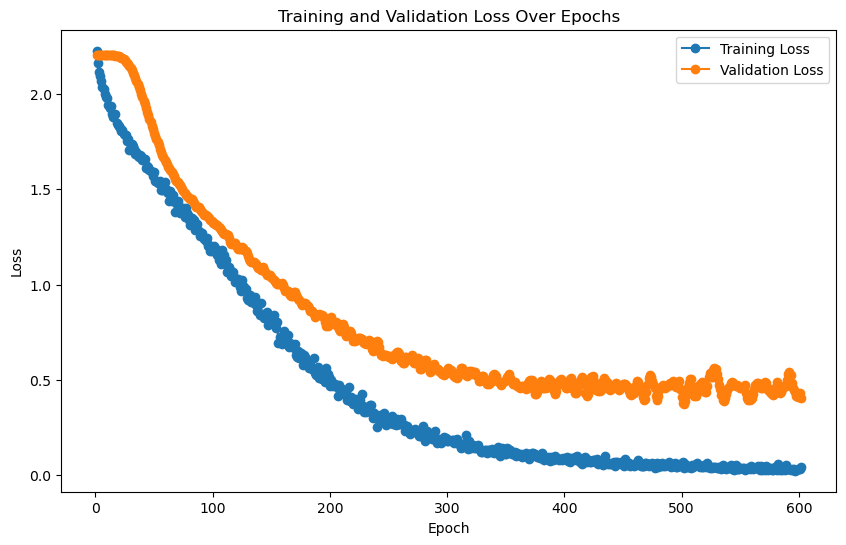

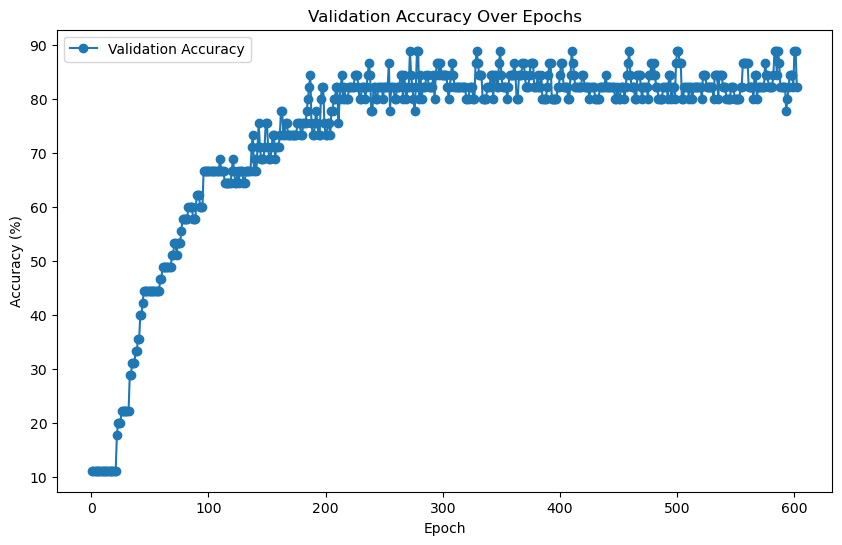


Evaluating on the test set...
    Test Batch [1/167], Loss: 1.0768



Final Test Loss: 0.7885, Test Accuracy: 75.57%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.


  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.


  Processed batch 90/167 for test dataset.
  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.


  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)

LOG: Training features shape: (90, 64), Training labels shape: (90,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42641, 64), Test labels shape: (42641,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 84.44%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      1.00      1.00         5
           2       0.50      0.80      0.62         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       0.80      0.80      0.80         5
           7       1.00      0.20      0.33         5
           8       1.00      1.00

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)
Train reps shape: (90, 64)
Train labels shape: (90,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42641, 64)
Test labels shape: (42641,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5298  |  Val Loss: 2.3309
Validation loss improved from inf to 2.3309.
[Epoch 2/1000] Train Loss: 2.3073  |  Val Loss: 2.2362
Validation loss improved from 2.3309 to 2.2362.
[Epoch 3/1000] Train Loss: 2.1918  |  Val Loss: 2.1741
Validation loss improved from 2.2362 to 2.1741.
[Epoch 4/1000] Train Loss: 2.1323  |  Val Loss: 2.1124
Validation loss improved from 2.1741 to 2.1124.
[Epoch 5/1000] Train Loss: 2.0581  |  Val Loss: 2.0472
Validation loss improved from 2.1124 to 2.0472.
[Epoch 6/1000] Train Loss: 1.9830  |  Val Loss: 1.9740
Validation loss improved from 2.0472 to 1.9740.
[Epoch 7/1000] Train Loss: 1.9195  |  Val Loss: 1.9053
Validation loss improved from 1.9740 to 1.9053.
[Epoch 8/1000] Train Loss: 1.8575  |  Val Loss: 1.8440
Validation loss improved from 1.9053 to 1.8440.
[Epoch 9/1000] Train Loss: 1.8072  |  Val Loss: 1.7854
Validation loss improved from 1.8440 to 1.7854.


[Epoch 10/1000] Train Loss: 1.7565  |  Val Loss: 1.7310
Validation loss improved from 1.7854 to 1.7310.
[Epoch 11/1000] Train Loss: 1.6992  |  Val Loss: 1.6789
Validation loss improved from 1.7310 to 1.6789.
[Epoch 12/1000] Train Loss: 1.6433  |  Val Loss: 1.6317
Validation loss improved from 1.6789 to 1.6317.
[Epoch 13/1000] Train Loss: 1.5942  |  Val Loss: 1.5903
Validation loss improved from 1.6317 to 1.5903.
[Epoch 14/1000] Train Loss: 1.5477  |  Val Loss: 1.5497
Validation loss improved from 1.5903 to 1.5497.
[Epoch 15/1000] Train Loss: 1.5019  |  Val Loss: 1.5098
Validation loss improved from 1.5497 to 1.5098.
[Epoch 16/1000] Train Loss: 1.4581  |  Val Loss: 1.4724
Validation loss improved from 1.5098 to 1.4724.
[Epoch 17/1000] Train Loss: 1.4203  |  Val Loss: 1.4310
Validation loss improved from 1.4724 to 1.4310.
[Epoch 18/1000] Train Loss: 1.3797  |  Val Loss: 1.3913
Validation loss improved from 1.4310 to 1.3913.
[Epoch 19/1000] Train Loss: 1.3360  |  Val Loss: 1.3530
Validati

[Epoch 33/1000] Train Loss: 0.8037  |  Val Loss: 0.8566
Validation loss improved from 0.8792 to 0.8566.
[Epoch 34/1000] Train Loss: 0.7772  |  Val Loss: 0.8265
Validation loss improved from 0.8566 to 0.8265.
[Epoch 35/1000] Train Loss: 0.7408  |  Val Loss: 0.8029
Validation loss improved from 0.8265 to 0.8029.
[Epoch 36/1000] Train Loss: 0.7216  |  Val Loss: 0.7826
Validation loss improved from 0.8029 to 0.7826.
[Epoch 37/1000] Train Loss: 0.6950  |  Val Loss: 0.7561
Validation loss improved from 0.7826 to 0.7561.
[Epoch 38/1000] Train Loss: 0.6676  |  Val Loss: 0.7357
Validation loss improved from 0.7561 to 0.7357.
[Epoch 39/1000] Train Loss: 0.6530  |  Val Loss: 0.7217
Validation loss improved from 0.7357 to 0.7217.
[Epoch 40/1000] Train Loss: 0.6331  |  Val Loss: 0.7063
Validation loss improved from 0.7217 to 0.7063.
[Epoch 41/1000] Train Loss: 0.6101  |  Val Loss: 0.6923
Validation loss improved from 0.7063 to 0.6923.
[Epoch 42/1000] Train Loss: 0.5928  |  Val Loss: 0.6722
Validati

[Epoch 50/1000] Train Loss: 0.4965  |  Val Loss: 0.5966
Validation loss improved from 0.6075 to 0.5966.
[Epoch 51/1000] Train Loss: 0.4880  |  Val Loss: 0.5831
Validation loss improved from 0.5966 to 0.5831.
[Epoch 52/1000] Train Loss: 0.4802  |  Val Loss: 0.5694
Validation loss improved from 0.5831 to 0.5694.
[Epoch 53/1000] Train Loss: 0.4656  |  Val Loss: 0.5588
Validation loss improved from 0.5694 to 0.5588.
[Epoch 54/1000] Train Loss: 0.4583  |  Val Loss: 0.5538
Validation loss improved from 0.5588 to 0.5538.
[Epoch 55/1000] Train Loss: 0.4520  |  Val Loss: 0.5424
Validation loss improved from 0.5538 to 0.5424.
[Epoch 56/1000] Train Loss: 0.4445  |  Val Loss: 0.5375
Validation loss improved from 0.5424 to 0.5375.
[Epoch 57/1000] Train Loss: 0.4358  |  Val Loss: 0.5438
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 58/1000] Train Loss: 0.4269  |  Val Loss: 0.5573
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 59/1000] Train Loss: 0.4194  |  Val Loss: 0.5

[Epoch 77/1000] Train Loss: 0.3212  |  Val Loss: 0.4854
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 78/1000] Train Loss: 0.3134  |  Val Loss: 0.4668
Validation loss improved from 0.4727 to 0.4668.
[Epoch 79/1000] Train Loss: 0.3055  |  Val Loss: 0.4530
Validation loss improved from 0.4668 to 0.4530.
[Epoch 80/1000] Train Loss: 0.3050  |  Val Loss: 0.4502
Validation loss improved from 0.4530 to 0.4502.
[Epoch 81/1000] Train Loss: 0.2967  |  Val Loss: 0.4595
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 82/1000] Train Loss: 0.2942  |  Val Loss: 0.4714
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 83/1000] Train Loss: 0.2892  |  Val Loss: 0.4776
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 84/1000] Train Loss: 0.2861  |  Val Loss: 0.4671
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 85/1000] Train Loss: 0.2792  |  Val Loss: 0.4543
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 86/1000] Train Loss: 

[Epoch 95/1000] Train Loss: 0.2319  |  Val Loss: 0.4297
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 96/1000] Train Loss: 0.2314  |  Val Loss: 0.4341
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 97/1000] Train Loss: 0.2265  |  Val Loss: 0.4227
Validation loss improved from 0.4296 to 0.4227.
[Epoch 98/1000] Train Loss: 0.2244  |  Val Loss: 0.4124
Validation loss improved from 0.4227 to 0.4124.
[Epoch 99/1000] Train Loss: 0.2201  |  Val Loss: 0.4075
Validation loss improved from 0.4124 to 0.4075.
[Epoch 100/1000] Train Loss: 0.2106  |  Val Loss: 0.4231
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 101/1000] Train Loss: 0.2097  |  Val Loss: 0.4378
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 102/1000] Train Loss: 0.2098  |  Val Loss: 0.4355
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 103/1000] Train Loss: 0.2040  |  Val Loss: 0.4302
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 104/1000] Train L

[Epoch 119/1000] Train Loss: 0.1468  |  Val Loss: 0.4214
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 120/1000] Train Loss: 0.1544  |  Val Loss: 0.4320
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 121/1000] Train Loss: 0.1477  |  Val Loss: 0.4193
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 122/1000] Train Loss: 0.1398  |  Val Loss: 0.4150
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 123/1000] Train Loss: 0.1454  |  Val Loss: 0.4012
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 124/1000] Train Loss: 0.1316  |  Val Loss: 0.4224
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 125/1000] Train Loss: 0.1377  |  Val Loss: 0.4251
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 126/1000] Train Loss: 0.1349  |  Val Loss: 0.4014
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 127/1000] Train Loss: 0.1278  |  Val Loss: 0.3949
Validation loss improved from 0.4009 to 0.3949.


[Epoch 146/1000] Train Loss: 0.0903  |  Val Loss: 0.4515
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 147/1000] Train Loss: 0.0898  |  Val Loss: 0.4359
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 148/1000] Train Loss: 0.0916  |  Val Loss: 0.4116
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 149/1000] Train Loss: 0.0862  |  Val Loss: 0.4253
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 150/1000] Train Loss: 0.0840  |  Val Loss: 0.4525
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 151/1000] Train Loss: 0.0880  |  Val Loss: 0.4644
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 152/1000] Train Loss: 0.0911  |  Val Loss: 0.4289
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 153/1000] Train Loss: 0.0782  |  Val Loss: 0.4048
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 154/1000] Train Loss: 0.0899  |  Val Loss: 0.4051
!! Validation loss did NOT improve !! Patience: 

[Epoch 162/1000] Train Loss: 0.0682  |  Val Loss: 0.4751
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 163/1000] Train Loss: 0.0711  |  Val Loss: 0.4547
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 164/1000] Train Loss: 0.0670  |  Val Loss: 0.4194
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 165/1000] Train Loss: 0.0673  |  Val Loss: 0.4206
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 166/1000] Train Loss: 0.0638  |  Val Loss: 0.4443
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 167/1000] Train Loss: 0.0634  |  Val Loss: 0.4582
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 168/1000] Train Loss: 0.0657  |  Val Loss: 0.4457
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 169/1000] Train Loss: 0.0600  |  Val Loss: 0.4282
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 170/1000] Train Loss: 0.0582  |  Val Loss: 0.4264
!! Validation loss did NOT improve !! Patience:

[Epoch 186/1000] Train Loss: 0.0474  |  Val Loss: 0.4556
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 187/1000] Train Loss: 0.0524  |  Val Loss: 0.4345
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 188/1000] Train Loss: 0.0500  |  Val Loss: 0.4483
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 189/1000] Train Loss: 0.0501  |  Val Loss: 0.4706
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 190/1000] Train Loss: 0.0430  |  Val Loss: 0.4956
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 191/1000] Train Loss: 0.0454  |  Val Loss: 0.4908
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 192/1000] Train Loss: 0.0444  |  Val Loss: 0.4594
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 193/1000] Train Loss: 0.0396  |  Val Loss: 0.4503
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 194/1000] Train Loss: 0.0456  |  Val Loss: 0.4623
!! Validation loss did NOT improve !! Patience:

[Epoch 203/1000] Train Loss: 0.0333  |  Val Loss: 0.4880
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 204/1000] Train Loss: 0.0356  |  Val Loss: 0.4919
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 205/1000] Train Loss: 0.0342  |  Val Loss: 0.4951
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 206/1000] Train Loss: 0.0331  |  Val Loss: 0.5068
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 207/1000] Train Loss: 0.0341  |  Val Loss: 0.5219
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 208/1000] Train Loss: 0.0335  |  Val Loss: 0.5231
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 209/1000] Train Loss: 0.0321  |  Val Loss: 0.5078
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 210/1000] Train Loss: 0.0311  |  Val Loss: 0.4906
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 211/1000] Train Loss: 0.0311  |  Val Loss: 0.4835
!! Validation loss did NOT improve !! Patience:

[Epoch 229/1000] Train Loss: 0.0233  |  Val Loss: 0.5311
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 230/1000] Train Loss: 0.0233  |  Val Loss: 0.5294
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 231/1000] Train Loss: 0.0228  |  Val Loss: 0.5255
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 232/1000] Train Loss: 0.0227  |  Val Loss: 0.5227
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 233/1000] Train Loss: 0.0228  |  Val Loss: 0.5276
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 234/1000] Train Loss: 0.0221  |  Val Loss: 0.5289
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 235/1000] Train Loss: 0.0217  |  Val Loss: 0.5351
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 236/1000] Train Loss: 0.0218  |  Val Loss: 0.5391
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 237/1000] Train Loss: 0.0214  |  Val Loss: 0.5359
!! Validation loss did NOT improve !! Patience:

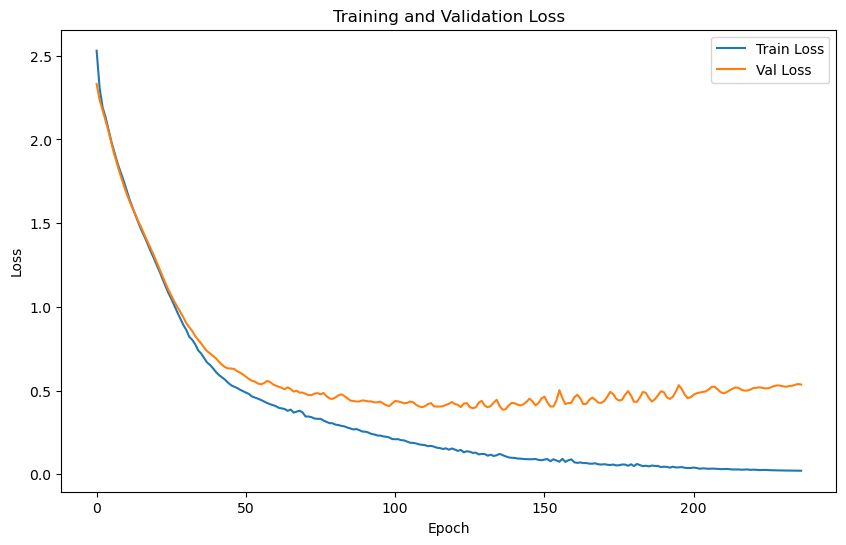

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.2930 | Test Accuracy: 65.65%


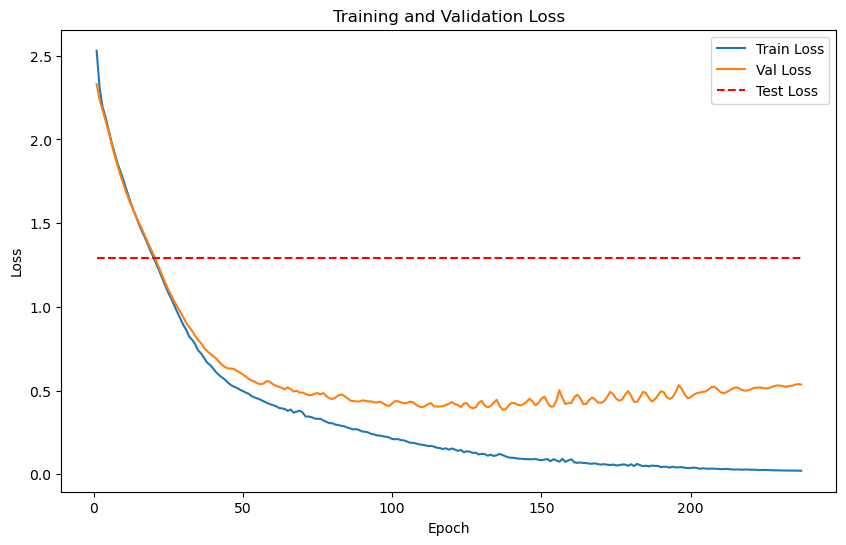

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42641, 64), 
Test labels shape: (42641,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.8881
Epoch [1/2000], Avg Train Loss: 8.8881
Epoch [1/2000], Avg Val Loss: 4.7718
Validation loss improved from inf to 4.7718. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 9.0568
Epoch [2/2000], Avg Train Loss: 9.0568
Epoch [2/2000], Avg Val Loss: 4.7162
Validation loss improved from 4.7718 to 4.7162. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.7991
Epoch [3/2000], Avg Train Loss: 8.7991
Epoch [3/2000], Avg Val Loss: 4.6622
Validation loss improved from 4.7162 to 4.6622. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.8787
Epoch [4/2000], Avg Train Loss: 8.8787
Epoch [4/2000], Avg Val Loss: 4.6094
Validation loss improved from 4.6622 to 4.6094. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.6193
Epoch [5/2000], Avg Train Loss: 8.6193
Epoch [5/2000], Avg Val Loss: 4.5576
Validation loss improved from 4.6094 to 4.5576. Saving mode

    Batch [1/1], Train Loss: 8.2260
Epoch [11/2000], Avg Train Loss: 8.2260
Epoch [11/2000], Avg Val Loss: 4.2733
Validation loss improved from 4.3177 to 4.2733. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 8.1319
Epoch [12/2000], Avg Train Loss: 8.1319
Epoch [12/2000], Avg Val Loss: 4.2299
Validation loss improved from 4.2733 to 4.2299. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 7.9645
Epoch [13/2000], Avg Train Loss: 7.9645
Epoch [13/2000], Avg Val Loss: 4.1879
Validation loss improved from 4.2299 to 4.1879. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.7189
Epoch [14/2000], Avg Train Loss: 7.7189
Epoch [14/2000], Avg Val Loss: 4.1467
Validation loss improved from 4.1879 to 4.1467. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 8.0658
Epoch [15/2000], Avg Train Loss: 8.0658
Epoch [15/2000], Avg Val Loss: 4.1066
Validation loss improved from 4.1467 to 4.

    Batch [1/1], Train Loss: 7.1699
Epoch [25/2000], Avg Train Loss: 7.1699
Epoch [25/2000], Avg Val Loss: 3.7641
Validation loss improved from 3.7940 to 3.7641. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 7.1684
Epoch [26/2000], Avg Train Loss: 7.1684
Epoch [26/2000], Avg Val Loss: 3.7349
Validation loss improved from 3.7641 to 3.7349. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 7.0926
Epoch [27/2000], Avg Train Loss: 7.0926
Epoch [27/2000], Avg Val Loss: 3.7065
Validation loss improved from 3.7349 to 3.7065. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 7.0800
Epoch [28/2000], Avg Train Loss: 7.0800
Epoch [28/2000], Avg Val Loss: 3.6790
Validation loss improved from 3.7065 to 3.6790. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 7.2185
Epoch [29/2000], Avg Train Loss: 7.2185
Epoch [29/2000], Avg Val Loss: 3.6522
Validation loss improved from 3.6790 to 3.

    Batch [1/1], Train Loss: 7.0439
Epoch [32/2000], Avg Train Loss: 7.0439
Epoch [32/2000], Avg Val Loss: 3.5769
Validation loss improved from 3.6012 to 3.5769. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.8470
Epoch [33/2000], Avg Train Loss: 6.8470
Epoch [33/2000], Avg Val Loss: 3.5533
Validation loss improved from 3.5769 to 3.5533. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 6.7659
Epoch [34/2000], Avg Train Loss: 6.7659
Epoch [34/2000], Avg Val Loss: 3.5304
Validation loss improved from 3.5533 to 3.5304. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 6.7168
Epoch [35/2000], Avg Train Loss: 6.7168
Epoch [35/2000], Avg Val Loss: 3.5083
Validation loss improved from 3.5304 to 3.5083. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 6.8144
Epoch [36/2000], Avg Train Loss: 6.8144
Epoch [36/2000], Avg Val Loss: 3.4870
Validation loss improved from 3.5083 to 3.

    Batch [1/1], Train Loss: 6.0099
Epoch [53/2000], Avg Train Loss: 6.0099


Epoch [53/2000], Avg Val Loss: 3.2169
Validation loss improved from 3.2289 to 3.2169. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 6.0426
Epoch [54/2000], Avg Train Loss: 6.0426
Epoch [54/2000], Avg Val Loss: 3.2053
Validation loss improved from 3.2169 to 3.2053. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.7516
Epoch [55/2000], Avg Train Loss: 5.7516
Epoch [55/2000], Avg Val Loss: 3.1942
Validation loss improved from 3.2053 to 3.1942. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.9521
Epoch [56/2000], Avg Train Loss: 5.9521
Epoch [56/2000], Avg Val Loss: 3.1834
Validation loss improved from 3.1942 to 3.1834. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 5.7435
Epoch [57/2000], Avg Train Loss: 5.7435
Epoch [57/2000], Avg Val Loss: 3.1730
Validation loss improved from 3.1834 to 3.1730. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Trai

Epoch [70/2000], Avg Val Loss: 3.0691
Validation loss improved from 3.0755 to 3.0691. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.2182
Epoch [71/2000], Avg Train Loss: 5.2182
Epoch [71/2000], Avg Val Loss: 3.0629
Validation loss improved from 3.0691 to 3.0629. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.1702
Epoch [72/2000], Avg Train Loss: 5.1702
Epoch [72/2000], Avg Val Loss: 3.0569
Validation loss improved from 3.0629 to 3.0569. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.0267
Epoch [73/2000], Avg Train Loss: 5.0267
Epoch [73/2000], Avg Val Loss: 3.0512
Validation loss improved from 3.0569 to 3.0512. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.1684
Epoch [74/2000], Avg Train Loss: 5.1684
Epoch [74/2000], Avg Val Loss: 3.0456
Validation loss improved from 3.0512 to 3.0456. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Trai

Epoch [77/2000], Avg Val Loss: 3.0300
Validation loss improved from 3.0349 to 3.0300. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 5.0063
Epoch [78/2000], Avg Train Loss: 5.0063
Epoch [78/2000], Avg Val Loss: 3.0252
Validation loss improved from 3.0300 to 3.0252. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 5.0788
Epoch [79/2000], Avg Train Loss: 5.0788
Epoch [79/2000], Avg Val Loss: 3.0205
Validation loss improved from 3.0252 to 3.0205. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 4.9005
Epoch [80/2000], Avg Train Loss: 4.9005
Epoch [80/2000], Avg Val Loss: 3.0159
Validation loss improved from 3.0205 to 3.0159. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 5.1028
Epoch [81/2000], Avg Train Loss: 5.1028
Epoch [81/2000], Avg Val Loss: 3.0115
Validation loss improved from 3.0159 to 3.0115. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.5794
Epoch [104/2000], Avg Train Loss: 4.5794
Epoch [104/2000], Avg Val Loss: 2.9407
Validation loss improved from 2.9429 to 2.9407. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 4.6111
Epoch [105/2000], Avg Train Loss: 4.6111
Epoch [105/2000], Avg Val Loss: 2.9387
Validation loss improved from 2.9407 to 2.9387. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 4.6880
Epoch [106/2000], Avg Train Loss: 4.6880
Epoch [106/2000], Avg Val Loss: 2.9367
Validation loss improved from 2.9387 to 2.9367. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 4.6431
Epoch [107/2000], Avg Train Loss: 4.6431
Epoch [107/2000], Avg Val Loss: 2.9347
Validation loss improved from 2.9367 to 2.9347. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 4.5972
Epoch [108/2000], Avg Train Loss: 4.5972
Epoch [108/2000], Avg Val Loss: 2.9328
Validation loss improved fro

Epoch [117/2000], Avg Val Loss: 2.9173
Validation loss improved from 2.9189 to 2.9173. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 4.4847
Epoch [118/2000], Avg Train Loss: 4.4847
Epoch [118/2000], Avg Val Loss: 2.9157
Validation loss improved from 2.9173 to 2.9157. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 4.5174
Epoch [119/2000], Avg Train Loss: 4.5174
Epoch [119/2000], Avg Val Loss: 2.9142
Validation loss improved from 2.9157 to 2.9142. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 4.4004
Epoch [120/2000], Avg Train Loss: 4.4004
Epoch [120/2000], Avg Val Loss: 2.9127
Validation loss improved from 2.9142 to 2.9127. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 4.5621
Epoch [121/2000], Avg Train Loss: 4.5621
Epoch [121/2000], Avg Val Loss: 2.9112
Validation loss improved from 2.9127 to 2.9112. Saving model...

LOG: Epoch [122/2000] - Training
    Bat

Epoch [149/2000], Avg Val Loss: 2.8758
Validation loss improved from 2.8770 to 2.8758. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 4.2499
Epoch [150/2000], Avg Train Loss: 4.2499
Epoch [150/2000], Avg Val Loss: 2.8746
Validation loss improved from 2.8758 to 2.8746. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 4.1975
Epoch [151/2000], Avg Train Loss: 4.1975
Epoch [151/2000], Avg Val Loss: 2.8735
Validation loss improved from 2.8746 to 2.8735. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 4.2744
Epoch [152/2000], Avg Train Loss: 4.2744
Epoch [152/2000], Avg Val Loss: 2.8723
Validation loss improved from 2.8735 to 2.8723. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 4.2043
Epoch [153/2000], Avg Train Loss: 4.2043
Epoch [153/2000], Avg Val Loss: 2.8712
Validation loss improved from 2.8723 to 2.8712. Saving model...

LOG: Epoch [154/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2230
Epoch [163/2000], Avg Train Loss: 4.2230
Epoch [163/2000], Avg Val Loss: 2.8595
Validation loss improved from 2.8607 to 2.8595. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 4.1229
Epoch [164/2000], Avg Train Loss: 4.1229
Epoch [164/2000], Avg Val Loss: 2.8583
Validation loss improved from 2.8595 to 2.8583. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 4.1138
Epoch [165/2000], Avg Train Loss: 4.1138
Epoch [165/2000], Avg Val Loss: 2.8571
Validation loss improved from 2.8583 to 2.8571. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 4.2887
Epoch [166/2000], Avg Train Loss: 4.2887
Epoch [166/2000], Avg Val Loss: 2.8560
Validation loss improved from 2.8571 to 2.8560. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 4.1151
Epoch [167/2000], Avg Train Loss: 4.1151
Epoch [167/2000], Avg Val Loss: 2.8548
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9675
Epoch [194/2000], Avg Train Loss: 3.9675
Epoch [194/2000], Avg Val Loss: 2.8229
Validation loss improved from 2.8241 to 2.8229. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 4.0188
Epoch [195/2000], Avg Train Loss: 4.0188
Epoch [195/2000], Avg Val Loss: 2.8217
Validation loss improved from 2.8229 to 2.8217. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 3.9822
Epoch [196/2000], Avg Train Loss: 3.9822
Epoch [196/2000], Avg Val Loss: 2.8205
Validation loss improved from 2.8217 to 2.8205. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 3.9505
Epoch [197/2000], Avg Train Loss: 3.9505
Epoch [197/2000], Avg Val Loss: 2.8193
Validation loss improved from 2.8205 to 2.8193. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 3.9433
Epoch [198/2000], Avg Train Loss: 3.9433
Epoch [198/2000], Avg Val Loss: 2.8181
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0212
Epoch [207/2000], Avg Train Loss: 4.0212
Epoch [207/2000], Avg Val Loss: 2.8074
Validation loss improved from 2.8086 to 2.8074. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 4.0077
Epoch [208/2000], Avg Train Loss: 4.0077
Epoch [208/2000], Avg Val Loss: 2.8063
Validation loss improved from 2.8074 to 2.8063. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 3.9688
Epoch [209/2000], Avg Train Loss: 3.9688
Epoch [209/2000], Avg Val Loss: 2.8051
Validation loss improved from 2.8063 to 2.8051. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 4.0186
Epoch [210/2000], Avg Train Loss: 4.0186
Epoch [210/2000], Avg Val Loss: 2.8040
Validation loss improved from 2.8051 to 2.8040. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 3.9758
Epoch [211/2000], Avg Train Loss: 3.9758
Epoch [211/2000], Avg Val Loss: 2.8028
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9285
Epoch [243/2000], Avg Train Loss: 3.9285
Epoch [243/2000], Avg Val Loss: 2.7664
Validation loss improved from 2.7676 to 2.7664. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 3.8783
Epoch [244/2000], Avg Train Loss: 3.8783
Epoch [244/2000], Avg Val Loss: 2.7653
Validation loss improved from 2.7664 to 2.7653. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 3.7876
Epoch [245/2000], Avg Train Loss: 3.7876
Epoch [245/2000], Avg Val Loss: 2.7642
Validation loss improved from 2.7653 to 2.7642. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 3.8234
Epoch [246/2000], Avg Train Loss: 3.8234
Epoch [246/2000], Avg Val Loss: 2.7630
Validation loss improved from 2.7642 to 2.7630. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 3.8020
Epoch [247/2000], Avg Train Loss: 3.8020
Epoch [247/2000], Avg Val Loss: 2.7619
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8400
Epoch [257/2000], Avg Train Loss: 3.8400
Epoch [257/2000], Avg Val Loss: 2.7502
Validation loss improved from 2.7513 to 2.7502. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 3.8170
Epoch [258/2000], Avg Train Loss: 3.8170
Epoch [258/2000], Avg Val Loss: 2.7490
Validation loss improved from 2.7502 to 2.7490. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 3.8302
Epoch [259/2000], Avg Train Loss: 3.8302
Epoch [259/2000], Avg Val Loss: 2.7479
Validation loss improved from 2.7490 to 2.7479. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 3.7730
Epoch [260/2000], Avg Train Loss: 3.7730
Epoch [260/2000], Avg Val Loss: 2.7467
Validation loss improved from 2.7479 to 2.7467. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 3.8321
Epoch [261/2000], Avg Train Loss: 3.8321
Epoch [261/2000], Avg Val Loss: 2.7456
Validation loss improved fro

Epoch [289/2000], Avg Val Loss: 2.7143
Validation loss improved from 2.7154 to 2.7143. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 3.8368
Epoch [290/2000], Avg Train Loss: 3.8368
Epoch [290/2000], Avg Val Loss: 2.7132
Validation loss improved from 2.7143 to 2.7132. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 3.7664
Epoch [291/2000], Avg Train Loss: 3.7664
Epoch [291/2000], Avg Val Loss: 2.7122
Validation loss improved from 2.7132 to 2.7122. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 3.7905
Epoch [292/2000], Avg Train Loss: 3.7905
Epoch [292/2000], Avg Val Loss: 2.7111
Validation loss improved from 2.7122 to 2.7111. Saving model...

LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 3.7668
Epoch [293/2000], Avg Train Loss: 3.7668
Epoch [293/2000], Avg Val Loss: 2.7101
Validation loss improved from 2.7111 to 2.7101. Saving model...

LOG: Epoch [294/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7428
Epoch [303/2000], Avg Train Loss: 3.7428
Epoch [303/2000], Avg Val Loss: 2.6998
Validation loss improved from 2.7008 to 2.6998. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 3.7024
Epoch [304/2000], Avg Train Loss: 3.7024
Epoch [304/2000], Avg Val Loss: 2.6987
Validation loss improved from 2.6998 to 2.6987. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 3.7158
Epoch [305/2000], Avg Train Loss: 3.7158
Epoch [305/2000], Avg Val Loss: 2.6977
Validation loss improved from 2.6987 to 2.6977. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 3.7162
Epoch [306/2000], Avg Train Loss: 3.7162
Epoch [306/2000], Avg Val Loss: 2.6966
Validation loss improved from 2.6977 to 2.6966. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 3.6842
Epoch [307/2000], Avg Train Loss: 3.6842
Epoch [307/2000], Avg Val Loss: 2.6956
Validation loss improved fro

Epoch [335/2000], Avg Val Loss: 2.6664
Validation loss improved from 2.6674 to 2.6664. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 3.6295
Epoch [336/2000], Avg Train Loss: 3.6295
Epoch [336/2000], Avg Val Loss: 2.6653
Validation loss improved from 2.6664 to 2.6653. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 3.5936
Epoch [337/2000], Avg Train Loss: 3.5936
Epoch [337/2000], Avg Val Loss: 2.6643
Validation loss improved from 2.6653 to 2.6643. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 3.6354
Epoch [338/2000], Avg Train Loss: 3.6354
Epoch [338/2000], Avg Val Loss: 2.6633
Validation loss improved from 2.6643 to 2.6633. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 3.6099
Epoch [339/2000], Avg Train Loss: 3.6099
Epoch [339/2000], Avg Val Loss: 2.6623
Validation loss improved from 2.6633 to 2.6623. Saving model...

LOG: Epoch [340/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5787
Epoch [347/2000], Avg Train Loss: 3.5787
Epoch [347/2000], Avg Val Loss: 2.6545
Validation loss improved from 2.6555 to 2.6545. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 3.6317
Epoch [348/2000], Avg Train Loss: 3.6317
Epoch [348/2000], Avg Val Loss: 2.6535
Validation loss improved from 2.6545 to 2.6535. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 3.6482
Epoch [349/2000], Avg Train Loss: 3.6482
Epoch [349/2000], Avg Val Loss: 2.6525
Validation loss improved from 2.6535 to 2.6525. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 3.6606
Epoch [350/2000], Avg Train Loss: 3.6606
Epoch [350/2000], Avg Val Loss: 2.6515
Validation loss improved from 2.6525 to 2.6515. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 3.6549
Epoch [351/2000], Avg Train Loss: 3.6549
Epoch [351/2000], Avg Val Loss: 2.6506
Validation loss improved fro

Epoch [379/2000], Avg Val Loss: 2.6250
Validation loss improved from 2.6258 to 2.6250. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 3.6247
Epoch [380/2000], Avg Train Loss: 3.6247
Epoch [380/2000], Avg Val Loss: 2.6241
Validation loss improved from 2.6250 to 2.6241. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 3.5983
Epoch [381/2000], Avg Train Loss: 3.5983
Epoch [381/2000], Avg Val Loss: 2.6233
Validation loss improved from 2.6241 to 2.6233. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 3.5445
Epoch [382/2000], Avg Train Loss: 3.5445
Epoch [382/2000], Avg Val Loss: 2.6224
Validation loss improved from 2.6233 to 2.6224. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 3.6103
Epoch [383/2000], Avg Train Loss: 3.6103
Epoch [383/2000], Avg Val Loss: 2.6215
Validation loss improved from 2.6224 to 2.6215. Saving model...

LOG: Epoch [384/2000] - Training
    Bat

Epoch [388/2000], Avg Val Loss: 2.6173
Validation loss improved from 2.6181 to 2.6173. Saving model...

LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 3.5258
Epoch [389/2000], Avg Train Loss: 3.5258
Epoch [389/2000], Avg Val Loss: 2.6165
Validation loss improved from 2.6173 to 2.6165. Saving model...

LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 3.6011
Epoch [390/2000], Avg Train Loss: 3.6011
Epoch [390/2000], Avg Val Loss: 2.6156
Validation loss improved from 2.6165 to 2.6156. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 3.5509
Epoch [391/2000], Avg Train Loss: 3.5509
Epoch [391/2000], Avg Val Loss: 2.6148
Validation loss improved from 2.6156 to 2.6148. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 3.5704
Epoch [392/2000], Avg Train Loss: 3.5704
Epoch [392/2000], Avg Val Loss: 2.6140
Validation loss improved from 2.6148 to 2.6140. Saving model...

LOG: Epoch [393/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4490
Epoch [427/2000], Avg Train Loss: 3.4490
Epoch [427/2000], Avg Val Loss: 2.5857
Validation loss improved from 2.5865 to 2.5857. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 3.5264
Epoch [428/2000], Avg Train Loss: 3.5264
Epoch [428/2000], Avg Val Loss: 2.5849
Validation loss improved from 2.5857 to 2.5849. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 3.5016
Epoch [429/2000], Avg Train Loss: 3.5016
Epoch [429/2000], Avg Val Loss: 2.5841
Validation loss improved from 2.5849 to 2.5841. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 3.4584
Epoch [430/2000], Avg Train Loss: 3.4584
Epoch [430/2000], Avg Val Loss: 2.5833
Validation loss improved from 2.5841 to 2.5833. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 3.5175
Epoch [431/2000], Avg Train Loss: 3.5175
Epoch [431/2000], Avg Val Loss: 2.5826
Validation loss improved fro

Epoch [435/2000], Avg Val Loss: 2.5796
Validation loss improved from 2.5803 to 2.5796. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 3.4760
Epoch [436/2000], Avg Train Loss: 3.4760
Epoch [436/2000], Avg Val Loss: 2.5789
Validation loss improved from 2.5796 to 2.5789. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 3.5059
Epoch [437/2000], Avg Train Loss: 3.5059
Epoch [437/2000], Avg Val Loss: 2.5781
Validation loss improved from 2.5789 to 2.5781. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 3.4596
Epoch [438/2000], Avg Train Loss: 3.4596
Epoch [438/2000], Avg Val Loss: 2.5774
Validation loss improved from 2.5781 to 2.5774. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 3.4529
Epoch [439/2000], Avg Train Loss: 3.4529
Epoch [439/2000], Avg Val Loss: 2.5767
Validation loss improved from 2.5774 to 2.5767. Saving model...

LOG: Epoch [440/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4514
Epoch [473/2000], Avg Train Loss: 3.4514
Epoch [473/2000], Avg Val Loss: 2.5535
Validation loss improved from 2.5542 to 2.5535. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 3.3503
Epoch [474/2000], Avg Train Loss: 3.3503
Epoch [474/2000], Avg Val Loss: 2.5528
Validation loss improved from 2.5535 to 2.5528. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 3.4072
Epoch [475/2000], Avg Train Loss: 3.4072
Epoch [475/2000], Avg Val Loss: 2.5522
Validation loss improved from 2.5528 to 2.5522. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 3.4436
Epoch [476/2000], Avg Train Loss: 3.4436
Epoch [476/2000], Avg Val Loss: 2.5515
Validation loss improved from 2.5522 to 2.5515. Saving model...

LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 3.4420
Epoch [477/2000], Avg Train Loss: 3.4420
Epoch [477/2000], Avg Val Loss: 2.5508
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4121
Epoch [479/2000], Avg Train Loss: 3.4121
Epoch [479/2000], Avg Val Loss: 2.5495
Validation loss improved from 2.5502 to 2.5495. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 3.3748
Epoch [480/2000], Avg Train Loss: 3.3748
Epoch [480/2000], Avg Val Loss: 2.5488
Validation loss improved from 2.5495 to 2.5488. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 3.4004
Epoch [481/2000], Avg Train Loss: 3.4004
Epoch [481/2000], Avg Val Loss: 2.5481
Validation loss improved from 2.5488 to 2.5481. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 3.4237
Epoch [482/2000], Avg Train Loss: 3.4237
Epoch [482/2000], Avg Val Loss: 2.5474
Validation loss improved from 2.5481 to 2.5474. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 3.4517
Epoch [483/2000], Avg Train Loss: 3.4517
Epoch [483/2000], Avg Val Loss: 2.5468
Validation loss improved fro

Epoch [515/2000], Avg Val Loss: 2.5284
Validation loss improved from 2.5289 to 2.5284. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 3.3563
Epoch [516/2000], Avg Train Loss: 3.3563
Epoch [516/2000], Avg Val Loss: 2.5279
Validation loss improved from 2.5284 to 2.5279. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 3.3414
Epoch [517/2000], Avg Train Loss: 3.3414
Epoch [517/2000], Avg Val Loss: 2.5274
Validation loss improved from 2.5279 to 2.5274. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 3.4069
Epoch [518/2000], Avg Train Loss: 3.4069
Epoch [518/2000], Avg Val Loss: 2.5269
Validation loss improved from 2.5274 to 2.5269. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 3.3556
Epoch [519/2000], Avg Train Loss: 3.3556
Epoch [519/2000], Avg Val Loss: 2.5263
Validation loss improved from 2.5269 to 2.5263. Saving model...

LOG: Epoch [520/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.3695
Epoch [526/2000], Avg Train Loss: 3.3695
Epoch [526/2000], Avg Val Loss: 2.5228
Validation loss improved from 2.5233 to 2.5228. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 3.3534
Epoch [527/2000], Avg Train Loss: 3.3534
Epoch [527/2000], Avg Val Loss: 2.5224
Validation loss improved from 2.5228 to 2.5224. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 3.3957
Epoch [528/2000], Avg Train Loss: 3.3957
Epoch [528/2000], Avg Val Loss: 2.5219
Validation loss improved from 2.5224 to 2.5219. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 3.3531
Epoch [529/2000], Avg Train Loss: 3.3531
Epoch [529/2000], Avg Val Loss: 2.5214
Validation loss improved from 2.5219 to 2.5214. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 3.3378
Epoch [530/2000], Avg Train Loss: 3.3378
Epoch [530/2000], Avg Val Loss: 2.5210
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3238
Epoch [561/2000], Avg Train Loss: 3.3238
Epoch [561/2000], Avg Val Loss: 2.5066
Validation loss improved from 2.5070 to 2.5066. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 3.3055
Epoch [562/2000], Avg Train Loss: 3.3055
Epoch [562/2000], Avg Val Loss: 2.5061
Validation loss improved from 2.5066 to 2.5061. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 3.2958
Epoch [563/2000], Avg Train Loss: 3.2958
Epoch [563/2000], Avg Val Loss: 2.5056
Validation loss improved from 2.5061 to 2.5056. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 3.3250
Epoch [564/2000], Avg Train Loss: 3.3250
Epoch [564/2000], Avg Val Loss: 2.5052
Validation loss improved from 2.5056 to 2.5052. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 3.3297
Epoch [565/2000], Avg Train Loss: 3.3297
Epoch [565/2000], Avg Val Loss: 2.5047
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3439
Epoch [573/2000], Avg Train Loss: 3.3439
Epoch [573/2000], Avg Val Loss: 2.5011
Validation loss improved from 2.5015 to 2.5011. Saving model...

LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 3.3344
Epoch [574/2000], Avg Train Loss: 3.3344
Epoch [574/2000], Avg Val Loss: 2.5007
Validation loss improved from 2.5011 to 2.5007. Saving model...

LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 3.3008
Epoch [575/2000], Avg Train Loss: 3.3008
Epoch [575/2000], Avg Val Loss: 2.5003
Validation loss improved from 2.5007 to 2.5003. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 3.2251
Epoch [576/2000], Avg Train Loss: 3.2251
Epoch [576/2000], Avg Val Loss: 2.4998
Validation loss improved from 2.5003 to 2.4998. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 3.2881
Epoch [577/2000], Avg Train Loss: 3.2881
Epoch [577/2000], Avg Val Loss: 2.4994
Validation loss improved fro

Epoch [600/2000], Avg Val Loss: 2.4903
Validation loss improved from 2.4907 to 2.4903. Saving model...

LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 3.3358
Epoch [601/2000], Avg Train Loss: 3.3358
Epoch [601/2000], Avg Val Loss: 2.4900
Validation loss improved from 2.4903 to 2.4900. Saving model...

LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 3.2692
Epoch [602/2000], Avg Train Loss: 3.2692
Epoch [602/2000], Avg Val Loss: 2.4896
Validation loss improved from 2.4900 to 2.4896. Saving model...

LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 3.2600
Epoch [603/2000], Avg Train Loss: 3.2600
Epoch [603/2000], Avg Val Loss: 2.4893
Validation loss improved from 2.4896 to 2.4893. Saving model...

LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 3.2242
Epoch [604/2000], Avg Train Loss: 3.2242
Epoch [604/2000], Avg Val Loss: 2.4890
Validation loss improved from 2.4893 to 2.4890. Saving model...

LOG: Epoch [605/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.3094
Epoch [616/2000], Avg Train Loss: 3.3094
Epoch [616/2000], Avg Val Loss: 2.4849
Validation loss improved from 2.4852 to 2.4849. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 3.2326
Epoch [617/2000], Avg Train Loss: 3.2326
Epoch [617/2000], Avg Val Loss: 2.4845
Validation loss improved from 2.4849 to 2.4845. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 3.3470
Epoch [618/2000], Avg Train Loss: 3.3470
Epoch [618/2000], Avg Val Loss: 2.4842
Validation loss improved from 2.4845 to 2.4842. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 3.2404
Epoch [619/2000], Avg Train Loss: 3.2404
Epoch [619/2000], Avg Val Loss: 2.4838
Validation loss improved from 2.4842 to 2.4838. Saving model...

LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 3.2235
Epoch [620/2000], Avg Train Loss: 3.2235
Epoch [620/2000], Avg Val Loss: 2.4834
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2583
Epoch [648/2000], Avg Train Loss: 3.2583
Epoch [648/2000], Avg Val Loss: 2.4739
Validation loss improved from 2.4742 to 2.4739. Saving model...

LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 3.2762
Epoch [649/2000], Avg Train Loss: 3.2762
Epoch [649/2000], Avg Val Loss: 2.4736
Validation loss improved from 2.4739 to 2.4736. Saving model...

LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 3.2491
Epoch [650/2000], Avg Train Loss: 3.2491
Epoch [650/2000], Avg Val Loss: 2.4734
Validation loss improved from 2.4736 to 2.4734. Saving model...

LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 3.2165
Epoch [651/2000], Avg Train Loss: 3.2165
Epoch [651/2000], Avg Val Loss: 2.4731
Validation loss improved from 2.4734 to 2.4731. Saving model...

LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 3.2560
Epoch [652/2000], Avg Train Loss: 3.2560
Epoch [652/2000], Avg Val Loss: 2.4729
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2151
Epoch [669/2000], Avg Train Loss: 3.2151
Epoch [669/2000], Avg Val Loss: 2.4681
Validation loss improved from 2.4684 to 2.4681. Saving model...

LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 3.2088
Epoch [670/2000], Avg Train Loss: 3.2088
Epoch [670/2000], Avg Val Loss: 2.4679
Validation loss improved from 2.4681 to 2.4679. Saving model...

LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 3.2321
Epoch [671/2000], Avg Train Loss: 3.2321
Epoch [671/2000], Avg Val Loss: 2.4676
Validation loss improved from 2.4679 to 2.4676. Saving model...

LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 3.2533
Epoch [672/2000], Avg Train Loss: 3.2533
Epoch [672/2000], Avg Val Loss: 2.4673
Validation loss improved from 2.4676 to 2.4673. Saving model...

LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 3.2731
Epoch [673/2000], Avg Train Loss: 3.2731
Epoch [673/2000], Avg Val Loss: 2.4670
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1847
Epoch [696/2000], Avg Train Loss: 3.1847
Epoch [696/2000], Avg Val Loss: 2.4613
Validation loss improved from 2.4615 to 2.4613. Saving model...

LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 3.2807
Epoch [697/2000], Avg Train Loss: 3.2807
Epoch [697/2000], Avg Val Loss: 2.4610
Validation loss improved from 2.4613 to 2.4610. Saving model...

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 3.1648
Epoch [698/2000], Avg Train Loss: 3.1648
Epoch [698/2000], Avg Val Loss: 2.4608
Validation loss improved from 2.4610 to 2.4608. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 3.2026
Epoch [699/2000], Avg Train Loss: 3.2026
Epoch [699/2000], Avg Val Loss: 2.4606
Validation loss improved from 2.4608 to 2.4606. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 3.2107
Epoch [700/2000], Avg Train Loss: 3.2107
Epoch [700/2000], Avg Val Loss: 2.4604
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2041
Epoch [713/2000], Avg Train Loss: 3.2041
Epoch [713/2000], Avg Val Loss: 2.4579
Validation loss improved from 2.4581 to 2.4579. Saving model...

LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 3.2490
Epoch [714/2000], Avg Train Loss: 3.2490
Epoch [714/2000], Avg Val Loss: 2.4577
Validation loss improved from 2.4579 to 2.4577. Saving model...

LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 3.1555
Epoch [715/2000], Avg Train Loss: 3.1555
Epoch [715/2000], Avg Val Loss: 2.4574
Validation loss improved from 2.4577 to 2.4574. Saving model...

LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 3.1472
Epoch [716/2000], Avg Train Loss: 3.1472
Epoch [716/2000], Avg Val Loss: 2.4572
Validation loss improved from 2.4574 to 2.4572. Saving model...

LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 3.1856
Epoch [717/2000], Avg Train Loss: 3.1856
Epoch [717/2000], Avg Val Loss: 2.4569
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1365
Epoch [742/2000], Avg Train Loss: 3.1365
Epoch [742/2000], Avg Val Loss: 2.4512
Validation loss improved from 2.4515 to 2.4512. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 3.2045
Epoch [743/2000], Avg Train Loss: 3.2045
Epoch [743/2000], Avg Val Loss: 2.4510
Validation loss improved from 2.4512 to 2.4510. Saving model...

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 3.1902
Epoch [744/2000], Avg Train Loss: 3.1902
Epoch [744/2000], Avg Val Loss: 2.4507
Validation loss improved from 2.4510 to 2.4507. Saving model...

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 3.1412
Epoch [745/2000], Avg Train Loss: 3.1412
Epoch [745/2000], Avg Val Loss: 2.4504
Validation loss improved from 2.4507 to 2.4504. Saving model...

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 3.1325
Epoch [746/2000], Avg Train Loss: 3.1325
Epoch [746/2000], Avg Val Loss: 2.4502
Validation loss improved fro

Epoch [756/2000], Avg Val Loss: 2.4482
Validation loss improved from 2.4484 to 2.4482. Saving model...

LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 3.1758
Epoch [757/2000], Avg Train Loss: 3.1758
Epoch [757/2000], Avg Val Loss: 2.4481
Validation loss improved from 2.4482 to 2.4481. Saving model...

LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 3.1489
Epoch [758/2000], Avg Train Loss: 3.1489
Epoch [758/2000], Avg Val Loss: 2.4479
Validation loss improved from 2.4481 to 2.4479. Saving model...

LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 3.1497
Epoch [759/2000], Avg Train Loss: 3.1497
Epoch [759/2000], Avg Val Loss: 2.4478
Validation loss improved from 2.4479 to 2.4478. Saving model...

LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 3.1286
Epoch [760/2000], Avg Train Loss: 3.1286
Epoch [760/2000], Avg Val Loss: 2.4476
Validation loss improved from 2.4478 to 2.4476. Saving model...

LOG: Epoch [761/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.1258
Epoch [788/2000], Avg Train Loss: 3.1258
Epoch [788/2000], Avg Val Loss: 2.4429
Validation loss improved from 2.4431 to 2.4429. Saving model...

LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 3.1506
Epoch [789/2000], Avg Train Loss: 3.1506
Epoch [789/2000], Avg Val Loss: 2.4428
Validation loss improved from 2.4429 to 2.4428. Saving model...

LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 3.1382
Epoch [790/2000], Avg Train Loss: 3.1382
Epoch [790/2000], Avg Val Loss: 2.4426
Validation loss improved from 2.4428 to 2.4426. Saving model...

LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 3.1379
Epoch [791/2000], Avg Train Loss: 3.1379
Epoch [791/2000], Avg Val Loss: 2.4425
Validation loss improved from 2.4426 to 2.4425. Saving model...

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 3.1111
Epoch [792/2000], Avg Train Loss: 3.1111
Epoch [792/2000], Avg Val Loss: 2.4424
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1370
Epoch [797/2000], Avg Train Loss: 3.1370
Epoch [797/2000], Avg Val Loss: 2.4417
Validation loss improved from 2.4418 to 2.4417. Saving model...

LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 3.0995
Epoch [798/2000], Avg Train Loss: 3.0995
Epoch [798/2000], Avg Val Loss: 2.4415
Validation loss improved from 2.4417 to 2.4415. Saving model...

LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 3.1661
Epoch [799/2000], Avg Train Loss: 3.1661
Epoch [799/2000], Avg Val Loss: 2.4414
Validation loss improved from 2.4415 to 2.4414. Saving model...

LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 3.1016
Epoch [800/2000], Avg Train Loss: 3.1016
Epoch [800/2000], Avg Val Loss: 2.4413
Validation loss improved from 2.4414 to 2.4413. Saving model...

LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 3.1573
Epoch [801/2000], Avg Train Loss: 3.1573
Epoch [801/2000], Avg Val Loss: 2.4412
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1161
Epoch [836/2000], Avg Train Loss: 3.1161
Epoch [836/2000], Avg Val Loss: 2.4360
Validation loss improved from 2.4361 to 2.4360. Saving model...

LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 3.1008
Epoch [837/2000], Avg Train Loss: 3.1008
Epoch [837/2000], Avg Val Loss: 2.4359
Validation loss improved from 2.4360 to 2.4359. Saving model...

LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 3.1452
Epoch [838/2000], Avg Train Loss: 3.1452
Epoch [838/2000], Avg Val Loss: 2.4357
Validation loss improved from 2.4359 to 2.4357. Saving model...

LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 3.1191
Epoch [839/2000], Avg Train Loss: 3.1191
Epoch [839/2000], Avg Val Loss: 2.4356
Validation loss improved from 2.4357 to 2.4356. Saving model...

LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 3.0503
Epoch [840/2000], Avg Train Loss: 3.0503
Epoch [840/2000], Avg Val Loss: 2.4354
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1007
Epoch [845/2000], Avg Train Loss: 3.1007
Epoch [845/2000], Avg Val Loss: 2.4347
Validation loss improved from 2.4349 to 2.4347. Saving model...

LOG: Epoch [846/2000] - Training
    Batch [1/1], Train Loss: 3.1021
Epoch [846/2000], Avg Train Loss: 3.1021
Epoch [846/2000], Avg Val Loss: 2.4346
Validation loss improved from 2.4347 to 2.4346. Saving model...

LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 3.0685
Epoch [847/2000], Avg Train Loss: 3.0685
Epoch [847/2000], Avg Val Loss: 2.4345
Validation loss improved from 2.4346 to 2.4345. Saving model...

LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 3.1150
Epoch [848/2000], Avg Train Loss: 3.1150
Epoch [848/2000], Avg Val Loss: 2.4344
Validation loss improved from 2.4345 to 2.4344. Saving model...

LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 3.0916
Epoch [849/2000], Avg Train Loss: 3.0916
Epoch [849/2000], Avg Val Loss: 2.4343
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0660
Epoch [882/2000], Avg Train Loss: 3.0660
Epoch [882/2000], Avg Val Loss: 2.4302
Validation loss improved from 2.4304 to 2.4302. Saving model...

LOG: Epoch [883/2000] - Training
    Batch [1/1], Train Loss: 3.0426
Epoch [883/2000], Avg Train Loss: 3.0426
Epoch [883/2000], Avg Val Loss: 2.4301
Validation loss improved from 2.4302 to 2.4301. Saving model...

LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 3.0482
Epoch [884/2000], Avg Train Loss: 3.0482
Epoch [884/2000], Avg Val Loss: 2.4300
Validation loss improved from 2.4301 to 2.4300. Saving model...

LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 3.1172
Epoch [885/2000], Avg Train Loss: 3.1172
Epoch [885/2000], Avg Val Loss: 2.4299
Validation loss improved from 2.4300 to 2.4299. Saving model...

LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 3.0704
Epoch [886/2000], Avg Train Loss: 3.0704
Epoch [886/2000], Avg Val Loss: 2.4299
Validation loss improved fro

Epoch [891/2000], Avg Val Loss: 2.4296
Validation loss improved from 2.4296 to 2.4296. Saving model...

LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 3.1274
Epoch [892/2000], Avg Train Loss: 3.1274
Epoch [892/2000], Avg Val Loss: 2.4295
Validation loss improved from 2.4296 to 2.4295. Saving model...

LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 3.1423
Epoch [893/2000], Avg Train Loss: 3.1423
Epoch [893/2000], Avg Val Loss: 2.4295
Validation loss improved from 2.4295 to 2.4295. Saving model...

LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 3.0906
Epoch [894/2000], Avg Train Loss: 3.0906
Epoch [894/2000], Avg Val Loss: 2.4294
Validation loss improved from 2.4295 to 2.4294. Saving model...

LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 3.0925
Epoch [895/2000], Avg Train Loss: 3.0925
Epoch [895/2000], Avg Val Loss: 2.4293
Validation loss improved from 2.4294 to 2.4293. Saving model...

LOG: Epoch [896/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.0584
Epoch [924/2000], Avg Train Loss: 3.0584
Epoch [924/2000], Avg Val Loss: 2.4270
Validation loss improved from 2.4271 to 2.4270. Saving model...

LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 3.0481
Epoch [925/2000], Avg Train Loss: 3.0481
Epoch [925/2000], Avg Val Loss: 2.4269
Validation loss improved from 2.4270 to 2.4269. Saving model...

LOG: Epoch [926/2000] - Training
    Batch [1/1], Train Loss: 3.0729
Epoch [926/2000], Avg Train Loss: 3.0729
Epoch [926/2000], Avg Val Loss: 2.4268
Validation loss improved from 2.4269 to 2.4268. Saving model...

LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 3.0605
Epoch [927/2000], Avg Train Loss: 3.0605
Epoch [927/2000], Avg Val Loss: 2.4267
Validation loss improved from 2.4268 to 2.4267. Saving model...

LOG: Epoch [928/2000] - Training
    Batch [1/1], Train Loss: 3.0712
Epoch [928/2000], Avg Train Loss: 3.0712
Epoch [928/2000], Avg Val Loss: 2.4265
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0361
Epoch [933/2000], Avg Train Loss: 3.0361
Epoch [933/2000], Avg Val Loss: 2.4255
Validation loss improved from 2.4257 to 2.4255. Saving model...

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 3.0455
Epoch [934/2000], Avg Train Loss: 3.0455
Epoch [934/2000], Avg Val Loss: 2.4253
Validation loss improved from 2.4255 to 2.4253. Saving model...

LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 3.0532
Epoch [935/2000], Avg Train Loss: 3.0532
Epoch [935/2000], Avg Val Loss: 2.4251
Validation loss improved from 2.4253 to 2.4251. Saving model...

LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 3.0600
Epoch [936/2000], Avg Train Loss: 3.0600
Epoch [936/2000], Avg Val Loss: 2.4250
Validation loss improved from 2.4251 to 2.4250. Saving model...

LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 3.0371
Epoch [937/2000], Avg Train Loss: 3.0371
Epoch [937/2000], Avg Val Loss: 2.4248
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0378
Epoch [969/2000], Avg Train Loss: 3.0378
Epoch [969/2000], Avg Val Loss: 2.4220
Validation loss improved from 2.4221 to 2.4220. Saving model...

LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 3.0494
Epoch [970/2000], Avg Train Loss: 3.0494
Epoch [970/2000], Avg Val Loss: 2.4219
Validation loss improved from 2.4220 to 2.4219. Saving model...

LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 3.0594
Epoch [971/2000], Avg Train Loss: 3.0594
Epoch [971/2000], Avg Val Loss: 2.4219
Validation loss improved from 2.4219 to 2.4219. Saving model...

LOG: Epoch [972/2000] - Training
    Batch [1/1], Train Loss: 3.0574
Epoch [972/2000], Avg Train Loss: 3.0574
Epoch [972/2000], Avg Val Loss: 2.4218
Validation loss improved from 2.4219 to 2.4218. Saving model...

LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 3.0525
Epoch [973/2000], Avg Train Loss: 3.0525
Epoch [973/2000], Avg Val Loss: 2.4217
Validation loss improved fro

Epoch [983/2000], Avg Val Loss: 2.4204
Validation loss improved from 2.4205 to 2.4204. Saving model...

LOG: Epoch [984/2000] - Training
    Batch [1/1], Train Loss: 3.0016
Epoch [984/2000], Avg Train Loss: 3.0016
Epoch [984/2000], Avg Val Loss: 2.4203
Validation loss improved from 2.4204 to 2.4203. Saving model...

LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 2.9883
Epoch [985/2000], Avg Train Loss: 2.9883
Epoch [985/2000], Avg Val Loss: 2.4202
Validation loss improved from 2.4203 to 2.4202. Saving model...

LOG: Epoch [986/2000] - Training
    Batch [1/1], Train Loss: 3.0515
Epoch [986/2000], Avg Train Loss: 3.0515
Epoch [986/2000], Avg Val Loss: 2.4201
Validation loss improved from 2.4202 to 2.4201. Saving model...

LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 3.0347
Epoch [987/2000], Avg Train Loss: 3.0347
Epoch [987/2000], Avg Val Loss: 2.4200
Validation loss improved from 2.4201 to 2.4200. Saving model...

LOG: Epoch [988/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.0272
Epoch [1014/2000], Avg Train Loss: 3.0272
Epoch [1014/2000], Avg Val Loss: 2.4176
Validation loss improved from 2.4176 to 2.4176. Saving model...

LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 3.0412
Epoch [1015/2000], Avg Train Loss: 3.0412
Epoch [1015/2000], Avg Val Loss: 2.4176
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1016/2000] - Training
    Batch [1/1], Train Loss: 3.0386
Epoch [1016/2000], Avg Train Loss: 3.0386
Epoch [1016/2000], Avg Val Loss: 2.4176
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 3.0445
Epoch [1017/2000], Avg Train Loss: 3.0445
Epoch [1017/2000], Avg Val Loss: 2.4176
Validation loss improved from 2.4176 to 2.4176. Saving model...

LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 3.0416
Epoch [1018/2000], Avg Train Loss: 3.0416
Epoch [1018/2000], Avg Val Loss: 2.4176
Validation loss improved from 2.4176 to 2.41

Epoch [1025/2000], Avg Val Loss: 2.4172
Validation loss improved from 2.4173 to 2.4172. Saving model...

LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 3.0175
Epoch [1026/2000], Avg Train Loss: 3.0175
Epoch [1026/2000], Avg Val Loss: 2.4171
Validation loss improved from 2.4172 to 2.4171. Saving model...

LOG: Epoch [1027/2000] - Training
    Batch [1/1], Train Loss: 3.0015
Epoch [1027/2000], Avg Train Loss: 3.0015
Epoch [1027/2000], Avg Val Loss: 2.4170
Validation loss improved from 2.4171 to 2.4170. Saving model...

LOG: Epoch [1028/2000] - Training
    Batch [1/1], Train Loss: 3.0032
Epoch [1028/2000], Avg Train Loss: 3.0032
Epoch [1028/2000], Avg Val Loss: 2.4169
Validation loss improved from 2.4170 to 2.4169. Saving model...

LOG: Epoch [1029/2000] - Training
    Batch [1/1], Train Loss: 3.0147
Epoch [1029/2000], Avg Train Loss: 3.0147
Epoch [1029/2000], Avg Val Loss: 2.4168
Validation loss improved from 2.4169 to 2.4168. Saving model...

LOG: Epoch [1030/2000] - Tr

    Batch [1/1], Train Loss: 2.9661
Epoch [1057/2000], Avg Train Loss: 2.9661
Epoch [1057/2000], Avg Val Loss: 2.4140
Validation loss improved from 2.4141 to 2.4140. Saving model...

LOG: Epoch [1058/2000] - Training
    Batch [1/1], Train Loss: 3.0103
Epoch [1058/2000], Avg Train Loss: 3.0103
Epoch [1058/2000], Avg Val Loss: 2.4139
Validation loss improved from 2.4140 to 2.4139. Saving model...

LOG: Epoch [1059/2000] - Training
    Batch [1/1], Train Loss: 3.0475
Epoch [1059/2000], Avg Train Loss: 3.0475
Epoch [1059/2000], Avg Val Loss: 2.4137
Validation loss improved from 2.4139 to 2.4137. Saving model...

LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 3.0018
Epoch [1060/2000], Avg Train Loss: 3.0018
Epoch [1060/2000], Avg Val Loss: 2.4136
Validation loss improved from 2.4137 to 2.4136. Saving model...

LOG: Epoch [1061/2000] - Training
    Batch [1/1], Train Loss: 2.9827
Epoch [1061/2000], Avg Train Loss: 2.9827
Epoch [1061/2000], Avg Val Loss: 2.4135
Validation los

    Batch [1/1], Train Loss: 2.9830
Epoch [1071/2000], Avg Train Loss: 2.9830
Epoch [1071/2000], Avg Val Loss: 2.4123
Validation loss improved from 2.4124 to 2.4123. Saving model...

LOG: Epoch [1072/2000] - Training
    Batch [1/1], Train Loss: 2.9615
Epoch [1072/2000], Avg Train Loss: 2.9615
Epoch [1072/2000], Avg Val Loss: 2.4122
Validation loss improved from 2.4123 to 2.4122. Saving model...

LOG: Epoch [1073/2000] - Training
    Batch [1/1], Train Loss: 2.9743
Epoch [1073/2000], Avg Train Loss: 2.9743
Epoch [1073/2000], Avg Val Loss: 2.4121
Validation loss improved from 2.4122 to 2.4121. Saving model...

LOG: Epoch [1074/2000] - Training
    Batch [1/1], Train Loss: 2.9556
Epoch [1074/2000], Avg Train Loss: 2.9556
Epoch [1074/2000], Avg Val Loss: 2.4121
Validation loss improved from 2.4121 to 2.4121. Saving model...

LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 3.0191
Epoch [1075/2000], Avg Train Loss: 3.0191
Epoch [1075/2000], Avg Val Loss: 2.4120
Validation los

Epoch [1105/2000], Avg Val Loss: 2.4114
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1106/2000] - Training
    Batch [1/1], Train Loss: 2.9668
Epoch [1106/2000], Avg Train Loss: 2.9668
Epoch [1106/2000], Avg Val Loss: 2.4114
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1107/2000] - Training
    Batch [1/1], Train Loss: 2.9737
Epoch [1107/2000], Avg Train Loss: 2.9737
Epoch [1107/2000], Avg Val Loss: 2.4115
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1108/2000] - Training
    Batch [1/1], Train Loss: 2.9582
Epoch [1108/2000], Avg Train Loss: 2.9582
Epoch [1108/2000], Avg Val Loss: 2.4115
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1109/2000] - Training
    Batch [1/1], Train Loss: 2.9698
Epoch [1109/2000], Avg Train Loss: 2.9698
Epoch [1109/2000], Avg Val Loss: 2.4115
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1110/2000] - Training
    Batch [1/1], Train Loss: 2.9952
Epoch [1110/2000], Avg Train Los

    Batch [1/1], Train Loss: 3.0119
Epoch [1118/2000], Avg Train Loss: 3.0119
Epoch [1118/2000], Avg Val Loss: 2.4113
Validation loss improved from 2.4113 to 2.4113. Saving model...

LOG: Epoch [1119/2000] - Training
    Batch [1/1], Train Loss: 2.9511
Epoch [1119/2000], Avg Train Loss: 2.9511
Epoch [1119/2000], Avg Val Loss: 2.4112
Validation loss improved from 2.4113 to 2.4112. Saving model...

LOG: Epoch [1120/2000] - Training
    Batch [1/1], Train Loss: 2.9635
Epoch [1120/2000], Avg Train Loss: 2.9635
Epoch [1120/2000], Avg Val Loss: 2.4111
Validation loss improved from 2.4112 to 2.4111. Saving model...

LOG: Epoch [1121/2000] - Training
    Batch [1/1], Train Loss: 2.9866
Epoch [1121/2000], Avg Train Loss: 2.9866
Epoch [1121/2000], Avg Val Loss: 2.4110
Validation loss improved from 2.4111 to 2.4110. Saving model...

LOG: Epoch [1122/2000] - Training
    Batch [1/1], Train Loss: 3.0138
Epoch [1122/2000], Avg Train Loss: 3.0138
Epoch [1122/2000], Avg Val Loss: 2.4109
Validation los

Epoch [1148/2000], Avg Val Loss: 2.4087
Validation loss improved from 2.4087 to 2.4087. Saving model...

LOG: Epoch [1149/2000] - Training
    Batch [1/1], Train Loss: 2.9614
Epoch [1149/2000], Avg Train Loss: 2.9614
Epoch [1149/2000], Avg Val Loss: 2.4086
Validation loss improved from 2.4087 to 2.4086. Saving model...

LOG: Epoch [1150/2000] - Training
    Batch [1/1], Train Loss: 2.9408
Epoch [1150/2000], Avg Train Loss: 2.9408
Epoch [1150/2000], Avg Val Loss: 2.4086
Validation loss improved from 2.4086 to 2.4086. Saving model...

LOG: Epoch [1151/2000] - Training
    Batch [1/1], Train Loss: 2.9373
Epoch [1151/2000], Avg Train Loss: 2.9373
Epoch [1151/2000], Avg Val Loss: 2.4085
Validation loss improved from 2.4086 to 2.4085. Saving model...

LOG: Epoch [1152/2000] - Training
    Batch [1/1], Train Loss: 2.9537
Epoch [1152/2000], Avg Train Loss: 2.9537
Epoch [1152/2000], Avg Val Loss: 2.4084
Validation loss improved from 2.4085 to 2.4084. Saving model...

LOG: Epoch [1153/2000] - Tr

Epoch [1162/2000], Avg Val Loss: 2.4081
Validation loss improved from 2.4081 to 2.4081. Saving model...

LOG: Epoch [1163/2000] - Training
    Batch [1/1], Train Loss: 2.9545
Epoch [1163/2000], Avg Train Loss: 2.9545
Epoch [1163/2000], Avg Val Loss: 2.4081
Validation loss improved from 2.4081 to 2.4081. Saving model...

LOG: Epoch [1164/2000] - Training
    Batch [1/1], Train Loss: 2.9426
Epoch [1164/2000], Avg Train Loss: 2.9426
Epoch [1164/2000], Avg Val Loss: 2.4080
Validation loss improved from 2.4081 to 2.4080. Saving model...

LOG: Epoch [1165/2000] - Training
    Batch [1/1], Train Loss: 2.9254
Epoch [1165/2000], Avg Train Loss: 2.9254
Epoch [1165/2000], Avg Val Loss: 2.4080
Validation loss improved from 2.4080 to 2.4080. Saving model...

LOG: Epoch [1166/2000] - Training
    Batch [1/1], Train Loss: 2.9811
Epoch [1166/2000], Avg Train Loss: 2.9811
Epoch [1166/2000], Avg Val Loss: 2.4079
Validation loss improved from 2.4080 to 2.4079. Saving model...

LOG: Epoch [1167/2000] - Tr

Epoch [1197/2000], Avg Val Loss: 2.4049
Validation loss improved from 2.4050 to 2.4049. Saving model...

LOG: Epoch [1198/2000] - Training
    Batch [1/1], Train Loss: 2.9295
Epoch [1198/2000], Avg Train Loss: 2.9295
Epoch [1198/2000], Avg Val Loss: 2.4048
Validation loss improved from 2.4049 to 2.4048. Saving model...

LOG: Epoch [1199/2000] - Training
    Batch [1/1], Train Loss: 2.9664
Epoch [1199/2000], Avg Train Loss: 2.9664
Epoch [1199/2000], Avg Val Loss: 2.4047
Validation loss improved from 2.4048 to 2.4047. Saving model...

LOG: Epoch [1200/2000] - Training
    Batch [1/1], Train Loss: 2.9402
Epoch [1200/2000], Avg Train Loss: 2.9402
Epoch [1200/2000], Avg Val Loss: 2.4047
Validation loss improved from 2.4047 to 2.4047. Saving model...

LOG: Epoch [1201/2000] - Training
    Batch [1/1], Train Loss: 2.9880
Epoch [1201/2000], Avg Train Loss: 2.9880
Epoch [1201/2000], Avg Val Loss: 2.4046
Validation loss improved from 2.4047 to 2.4046. Saving model...

LOG: Epoch [1202/2000] - Tr

Epoch [1209/2000], Avg Val Loss: 2.4037
Validation loss improved from 2.4038 to 2.4037. Saving model...

LOG: Epoch [1210/2000] - Training
    Batch [1/1], Train Loss: 2.9427
Epoch [1210/2000], Avg Train Loss: 2.9427
Epoch [1210/2000], Avg Val Loss: 2.4036
Validation loss improved from 2.4037 to 2.4036. Saving model...

LOG: Epoch [1211/2000] - Training
    Batch [1/1], Train Loss: 2.8977
Epoch [1211/2000], Avg Train Loss: 2.8977
Epoch [1211/2000], Avg Val Loss: 2.4035
Validation loss improved from 2.4036 to 2.4035. Saving model...

LOG: Epoch [1212/2000] - Training
    Batch [1/1], Train Loss: 2.8765
Epoch [1212/2000], Avg Train Loss: 2.8765
Epoch [1212/2000], Avg Val Loss: 2.4033
Validation loss improved from 2.4035 to 2.4033. Saving model...

LOG: Epoch [1213/2000] - Training
    Batch [1/1], Train Loss: 2.9293
Epoch [1213/2000], Avg Train Loss: 2.9293
Epoch [1213/2000], Avg Val Loss: 2.4032
Validation loss improved from 2.4033 to 2.4032. Saving model...

LOG: Epoch [1214/2000] - Tr

    Batch [1/1], Train Loss: 2.8817
Epoch [1236/2000], Avg Train Loss: 2.8817
Epoch [1236/2000], Avg Val Loss: 2.4003
Validation loss improved from 2.4005 to 2.4003. Saving model...

LOG: Epoch [1237/2000] - Training
    Batch [1/1], Train Loss: 2.9191
Epoch [1237/2000], Avg Train Loss: 2.9191
Epoch [1237/2000], Avg Val Loss: 2.4001
Validation loss improved from 2.4003 to 2.4001. Saving model...

LOG: Epoch [1238/2000] - Training
    Batch [1/1], Train Loss: 2.9428
Epoch [1238/2000], Avg Train Loss: 2.9428
Epoch [1238/2000], Avg Val Loss: 2.3999
Validation loss improved from 2.4001 to 2.3999. Saving model...

LOG: Epoch [1239/2000] - Training
    Batch [1/1], Train Loss: 2.9108
Epoch [1239/2000], Avg Train Loss: 2.9108
Epoch [1239/2000], Avg Val Loss: 2.3996
Validation loss improved from 2.3999 to 2.3996. Saving model...

LOG: Epoch [1240/2000] - Training
    Batch [1/1], Train Loss: 2.9085
Epoch [1240/2000], Avg Train Loss: 2.9085
Epoch [1240/2000], Avg Val Loss: 2.3994
Validation los

    Batch [1/1], Train Loss: 2.9115
Epoch [1249/2000], Avg Train Loss: 2.9115
Epoch [1249/2000], Avg Val Loss: 2.3981
Validation loss improved from 2.3982 to 2.3981. Saving model...

LOG: Epoch [1250/2000] - Training
    Batch [1/1], Train Loss: 2.9234
Epoch [1250/2000], Avg Train Loss: 2.9234
Epoch [1250/2000], Avg Val Loss: 2.3980
Validation loss improved from 2.3981 to 2.3980. Saving model...

LOG: Epoch [1251/2000] - Training
    Batch [1/1], Train Loss: 2.9078
Epoch [1251/2000], Avg Train Loss: 2.9078
Epoch [1251/2000], Avg Val Loss: 2.3980
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1252/2000] - Training
    Batch [1/1], Train Loss: 2.9807
Epoch [1252/2000], Avg Train Loss: 2.9807
Epoch [1252/2000], Avg Val Loss: 2.3981
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1253/2000] - Training
    Batch [1/1], Train Loss: 2.8861
Epoch [1253/2000], Avg Train Loss: 2.8861
Epoch [1253/2000], Avg Val Loss: 2.3982
Validation loss did not improve. Patience: 3

    Batch [1/1], Train Loss: 2.9141
Epoch [1292/2000], Avg Train Loss: 2.9141
Epoch [1292/2000], Avg Val Loss: 2.3985
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1293/2000] - Training
    Batch [1/1], Train Loss: 2.9714
Epoch [1293/2000], Avg Train Loss: 2.9714
Epoch [1293/2000], Avg Val Loss: 2.3983
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1294/2000] - Training
    Batch [1/1], Train Loss: 2.9805
Epoch [1294/2000], Avg Train Loss: 2.9805
Epoch [1294/2000], Avg Val Loss: 2.3982
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1295/2000] - Training
    Batch [1/1], Train Loss: 2.9233
Epoch [1295/2000], Avg Train Loss: 2.9233
Epoch [1295/2000], Avg Val Loss: 2.3981
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1296/2000] - Training
    Batch [1/1], Train Loss: 2.9229
Epoch [1296/2000], Avg Train Loss: 2.9229
Epoch [1296/2000], Avg Val Loss: 2.3979
Validation loss improved from 2.3980 to 2.3979. Saving model...

LOG: 

Epoch [1298/2000], Avg Val Loss: 2.3975
Validation loss improved from 2.3978 to 2.3975. Saving model...

LOG: Epoch [1299/2000] - Training
    Batch [1/1], Train Loss: 2.9467
Epoch [1299/2000], Avg Train Loss: 2.9467
Epoch [1299/2000], Avg Val Loss: 2.3973
Validation loss improved from 2.3975 to 2.3973. Saving model...

LOG: Epoch [1300/2000] - Training
    Batch [1/1], Train Loss: 2.9300
Epoch [1300/2000], Avg Train Loss: 2.9300
Epoch [1300/2000], Avg Val Loss: 2.3971
Validation loss improved from 2.3973 to 2.3971. Saving model...

LOG: Epoch [1301/2000] - Training
    Batch [1/1], Train Loss: 2.9015
Epoch [1301/2000], Avg Train Loss: 2.9015
Epoch [1301/2000], Avg Val Loss: 2.3969
Validation loss improved from 2.3971 to 2.3969. Saving model...

LOG: Epoch [1302/2000] - Training
    Batch [1/1], Train Loss: 2.9142
Epoch [1302/2000], Avg Train Loss: 2.9142
Epoch [1302/2000], Avg Val Loss: 2.3966
Validation loss improved from 2.3969 to 2.3966. Saving model...

LOG: Epoch [1303/2000] - Tr

Epoch [1341/2000], Avg Val Loss: 2.3918
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1342/2000] - Training
    Batch [1/1], Train Loss: 2.9117
Epoch [1342/2000], Avg Train Loss: 2.9117
Epoch [1342/2000], Avg Val Loss: 2.3920
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1343/2000] - Training
    Batch [1/1], Train Loss: 2.9432
Epoch [1343/2000], Avg Train Loss: 2.9432
Epoch [1343/2000], Avg Val Loss: 2.3922
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1344/2000] - Training
    Batch [1/1], Train Loss: 2.8968
Epoch [1344/2000], Avg Train Loss: 2.8968
Epoch [1344/2000], Avg Val Loss: 2.3923
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1345/2000] - Training
    Batch [1/1], Train Loss: 2.8987
Epoch [1345/2000], Avg Train Loss: 2.8987
Epoch [1345/2000], Avg Val Loss: 2.3923
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1346/2000] - Training
    Batch [1/1], Train Loss: 2.9105
Epoch [1346/2000], Avg Train Lo

    Batch [1/1], Train Loss: 2.9037
Epoch [1387/2000], Avg Train Loss: 2.9037
Epoch [1387/2000], Avg Val Loss: 2.3912
Validation loss improved from 2.3912 to 2.3912. Saving model...

LOG: Epoch [1388/2000] - Training
    Batch [1/1], Train Loss: 2.8788
Epoch [1388/2000], Avg Train Loss: 2.8788
Epoch [1388/2000], Avg Val Loss: 2.3911
Validation loss improved from 2.3912 to 2.3911. Saving model...

LOG: Epoch [1389/2000] - Training
    Batch [1/1], Train Loss: 2.8717
Epoch [1389/2000], Avg Train Loss: 2.8717
Epoch [1389/2000], Avg Val Loss: 2.3910
Validation loss improved from 2.3911 to 2.3910. Saving model...

LOG: Epoch [1390/2000] - Training
    Batch [1/1], Train Loss: 2.9322
Epoch [1390/2000], Avg Train Loss: 2.9322
Epoch [1390/2000], Avg Val Loss: 2.3910
Validation loss improved from 2.3910 to 2.3910. Saving model...

LOG: Epoch [1391/2000] - Training
    Batch [1/1], Train Loss: 2.8659
Epoch [1391/2000], Avg Train Loss: 2.8659
Epoch [1391/2000], Avg Val Loss: 2.3910
Validation los

    Batch [1/1], Train Loss: 2.8811
Epoch [1435/2000], Avg Train Loss: 2.8811
Epoch [1435/2000], Avg Val Loss: 2.3928
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1436/2000] - Training
    Batch [1/1], Train Loss: 2.8761
Epoch [1436/2000], Avg Train Loss: 2.8761
Epoch [1436/2000], Avg Val Loss: 2.3928
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1437/2000] - Training
    Batch [1/1], Train Loss: 2.8493
Epoch [1437/2000], Avg Train Loss: 2.8493
Epoch [1437/2000], Avg Val Loss: 2.3928
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1438/2000] - Training
    Batch [1/1], Train Loss: 2.9027
Epoch [1438/2000], Avg Train Loss: 2.9027
Epoch [1438/2000], Avg Val Loss: 2.3928
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1439/2000] - Training
    Batch [1/1], Train Loss: 2.8523
Epoch [1439/2000], Avg Train Loss: 2.8523
Epoch [1439/2000], Avg Val Loss: 2.3928
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1440/20

Epoch [1477/2000], Avg Val Loss: 2.3915
Validation loss did not improve. Patience: 86/100

LOG: Epoch [1478/2000] - Training
    Batch [1/1], Train Loss: 2.8329
Epoch [1478/2000], Avg Train Loss: 2.8329
Epoch [1478/2000], Avg Val Loss: 2.3914
Validation loss did not improve. Patience: 87/100

LOG: Epoch [1479/2000] - Training
    Batch [1/1], Train Loss: 2.8403
Epoch [1479/2000], Avg Train Loss: 2.8403
Epoch [1479/2000], Avg Val Loss: 2.3913
Validation loss did not improve. Patience: 88/100

LOG: Epoch [1480/2000] - Training
    Batch [1/1], Train Loss: 2.7988
Epoch [1480/2000], Avg Train Loss: 2.7988
Epoch [1480/2000], Avg Val Loss: 2.3912
Validation loss did not improve. Patience: 89/100

LOG: Epoch [1481/2000] - Training
    Batch [1/1], Train Loss: 2.8436
Epoch [1481/2000], Avg Train Loss: 2.8436
Epoch [1481/2000], Avg Val Loss: 2.3911
Validation loss did not improve. Patience: 90/100

LOG: Epoch [1482/2000] - Training
    Batch [1/1], Train Loss: 2.8421
Epoch [1482/2000], Avg Trai

    Batch [1/1], Train Loss: 2.8751
Epoch [1526/2000], Avg Train Loss: 2.8751
Epoch [1526/2000], Avg Val Loss: 2.3914
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1527/2000] - Training
    Batch [1/1], Train Loss: 2.8399
Epoch [1527/2000], Avg Train Loss: 2.8399
Epoch [1527/2000], Avg Val Loss: 2.3914
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1528/2000] - Training
    Batch [1/1], Train Loss: 2.8404
Epoch [1528/2000], Avg Train Loss: 2.8404
Epoch [1528/2000], Avg Val Loss: 2.3915
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1529/2000] - Training
    Batch [1/1], Train Loss: 2.8318
Epoch [1529/2000], Avg Train Loss: 2.8318
Epoch [1529/2000], Avg Val Loss: 2.3916
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1530/2000] - Training
    Batch [1/1], Train Loss: 2.8470
Epoch [1530/2000], Avg Train Loss: 2.8470
Epoch [1530/2000], Avg Val Loss: 2.3917
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1531/20

    Batch [1/1], Train Loss: 2.8800
Epoch [1575/2000], Avg Train Loss: 2.8800
Epoch [1575/2000], Avg Val Loss: 2.3946
Validation loss did not improve. Patience: 83/100

LOG: Epoch [1576/2000] - Training
    Batch [1/1], Train Loss: 2.8100
Epoch [1576/2000], Avg Train Loss: 2.8100
Epoch [1576/2000], Avg Val Loss: 2.3947
Validation loss did not improve. Patience: 84/100

LOG: Epoch [1577/2000] - Training
    Batch [1/1], Train Loss: 2.8458
Epoch [1577/2000], Avg Train Loss: 2.8458
Epoch [1577/2000], Avg Val Loss: 2.3949
Validation loss did not improve. Patience: 85/100

LOG: Epoch [1578/2000] - Training
    Batch [1/1], Train Loss: 2.8444
Epoch [1578/2000], Avg Train Loss: 2.8444
Epoch [1578/2000], Avg Val Loss: 2.3951
Validation loss did not improve. Patience: 86/100

LOG: Epoch [1579/2000] - Training
    Batch [1/1], Train Loss: 2.8658
Epoch [1579/2000], Avg Train Loss: 2.8658
Epoch [1579/2000], Avg Val Loss: 2.3952
Validation loss did not improve. Patience: 87/100

LOG: Epoch [1580/20

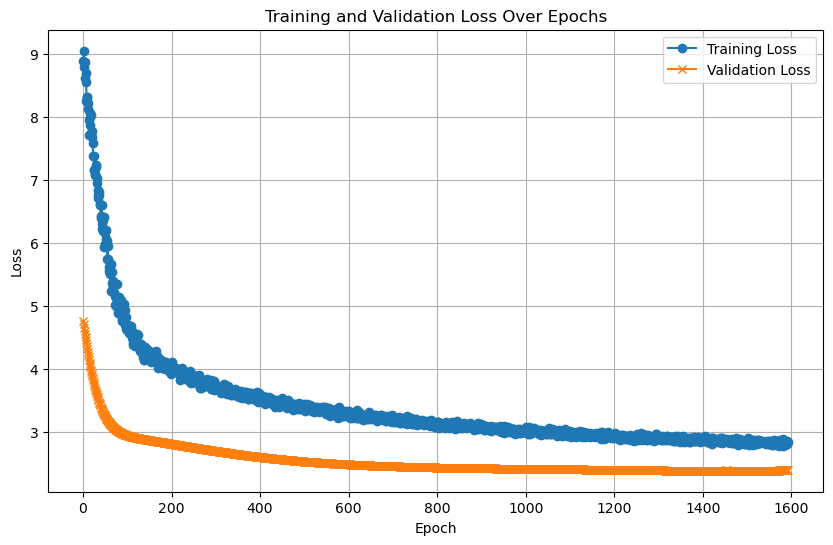

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/167], Loss: 4.1702
Test Batch [20/167], Loss: 4.3780
Test Batch [30/167], Loss: 4.4409
Test Batch [40/167], Loss: 4.3670
Test Batch [50/167], Loss: 4.3520
Test Batch [60/167], Loss: 4.0730
Test Batch [70/167], Loss: 4.0688
Test Batch [80/167], Loss: 4.8458
Test Batch [90/167], Loss: 4.8998
Test Batch [100/167], Loss: 4.8640
Test Batch [110/167], Loss: 5.0078
Test Batch [120/167], Loss: 4.9116
Test Batch [130/167], Loss: 4.9686
Test Batch [140/167], Loss: 4.9452
Test Batch [150/167], Loss: 5.1071
Test Batch [160/167], Loss: 5.4129



Test Loss: 4.6559


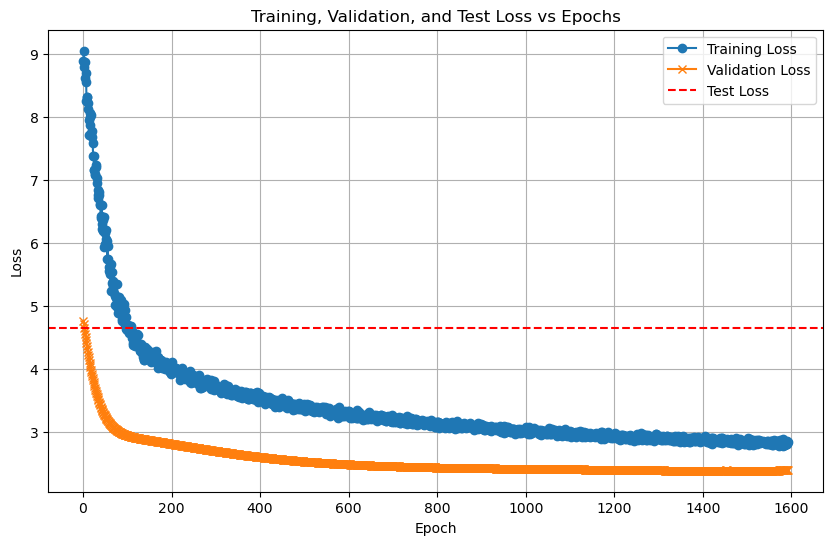

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.


  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.


  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.


  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.


  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.


Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 80.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.56      1.00      0.71         5
           2       0.57      0.80      0.67         5
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         5
           5       1.00      0.40      0.57         5
           6       0.80      0.80      0.80         5
           7       1.00      0.40      0.57         5
           8       1.00      1.00      1.00         5

    accuracy                           0.80        45
   macro avg       0.86      0.80      0.79        45
weighted avg       0.86      0.80      0.79        45


LOG: Evaluating on the test set...
Test Accuracy: 67.95%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3324  |  Val Loss: 2.3152
Validation loss improved from inf to 2.3152.


[Epoch 2/1000] Train Loss: 2.2954  |  Val Loss: 2.2851
Validation loss improved from 2.3152 to 2.2851.
[Epoch 3/1000] Train Loss: 2.2664  |  Val Loss: 2.2563
Validation loss improved from 2.2851 to 2.2563.
[Epoch 4/1000] Train Loss: 2.2354  |  Val Loss: 2.2306
Validation loss improved from 2.2563 to 2.2306.
[Epoch 5/1000] Train Loss: 2.2085  |  Val Loss: 2.2086
Validation loss improved from 2.2306 to 2.2086.
[Epoch 6/1000] Train Loss: 2.1858  |  Val Loss: 2.1881
Validation loss improved from 2.2086 to 2.1881.
[Epoch 7/1000] Train Loss: 2.1627  |  Val Loss: 2.1688
Validation loss improved from 2.1881 to 2.1688.
[Epoch 8/1000] Train Loss: 2.1418  |  Val Loss: 2.1504
Validation loss improved from 2.1688 to 2.1504.
[Epoch 9/1000] Train Loss: 2.1231  |  Val Loss: 2.1326
Validation loss improved from 2.1504 to 2.1326.
[Epoch 10/1000] Train Loss: 2.1043  |  Val Loss: 2.1159
Validation loss improved from 2.1326 to 2.1159.
[Epoch 11/1000] Train Loss: 2.0867  |  Val Loss: 2.1002
Validation loss 

[Epoch 12/1000] Train Loss: 2.0698  |  Val Loss: 2.0856
Validation loss improved from 2.1002 to 2.0856.
[Epoch 13/1000] Train Loss: 2.0546  |  Val Loss: 2.0718
Validation loss improved from 2.0856 to 2.0718.
[Epoch 14/1000] Train Loss: 2.0407  |  Val Loss: 2.0588
Validation loss improved from 2.0718 to 2.0588.
[Epoch 15/1000] Train Loss: 2.0264  |  Val Loss: 2.0464
Validation loss improved from 2.0588 to 2.0464.
[Epoch 16/1000] Train Loss: 2.0126  |  Val Loss: 2.0348
Validation loss improved from 2.0464 to 2.0348.
[Epoch 17/1000] Train Loss: 1.9989  |  Val Loss: 2.0236
Validation loss improved from 2.0348 to 2.0236.
[Epoch 18/1000] Train Loss: 1.9867  |  Val Loss: 2.0127
Validation loss improved from 2.0236 to 2.0127.
[Epoch 19/1000] Train Loss: 1.9745  |  Val Loss: 2.0019
Validation loss improved from 2.0127 to 2.0019.
[Epoch 20/1000] Train Loss: 1.9626  |  Val Loss: 1.9915
Validation loss improved from 2.0019 to 1.9915.
[Epoch 21/1000] Train Loss: 1.9509  |  Val Loss: 1.9816
Validati

[Epoch 41/1000] Train Loss: 1.7469  |  Val Loss: 1.8055
Validation loss improved from 1.8138 to 1.8055.


[Epoch 42/1000] Train Loss: 1.7379  |  Val Loss: 1.7971
Validation loss improved from 1.8055 to 1.7971.
[Epoch 43/1000] Train Loss: 1.7280  |  Val Loss: 1.7887
Validation loss improved from 1.7971 to 1.7887.
[Epoch 44/1000] Train Loss: 1.7186  |  Val Loss: 1.7802
Validation loss improved from 1.7887 to 1.7802.
[Epoch 45/1000] Train Loss: 1.7089  |  Val Loss: 1.7717
Validation loss improved from 1.7802 to 1.7717.
[Epoch 46/1000] Train Loss: 1.6992  |  Val Loss: 1.7632
Validation loss improved from 1.7717 to 1.7632.
[Epoch 47/1000] Train Loss: 1.6892  |  Val Loss: 1.7550
Validation loss improved from 1.7632 to 1.7550.
[Epoch 48/1000] Train Loss: 1.6792  |  Val Loss: 1.7469
Validation loss improved from 1.7550 to 1.7469.
[Epoch 49/1000] Train Loss: 1.6690  |  Val Loss: 1.7389
Validation loss improved from 1.7469 to 1.7389.
[Epoch 50/1000] Train Loss: 1.6590  |  Val Loss: 1.7306
Validation loss improved from 1.7389 to 1.7306.
[Epoch 51/1000] Train Loss: 1.6489  |  Val Loss: 1.7224
Validati

[Epoch 59/1000] Train Loss: 1.5706  |  Val Loss: 1.6563
Validation loss improved from 1.6640 to 1.6563.
[Epoch 60/1000] Train Loss: 1.5610  |  Val Loss: 1.6486
Validation loss improved from 1.6563 to 1.6486.
[Epoch 61/1000] Train Loss: 1.5517  |  Val Loss: 1.6408
Validation loss improved from 1.6486 to 1.6408.
[Epoch 62/1000] Train Loss: 1.5422  |  Val Loss: 1.6328
Validation loss improved from 1.6408 to 1.6328.
[Epoch 63/1000] Train Loss: 1.5327  |  Val Loss: 1.6250
Validation loss improved from 1.6328 to 1.6250.
[Epoch 64/1000] Train Loss: 1.5233  |  Val Loss: 1.6168
Validation loss improved from 1.6250 to 1.6168.
[Epoch 65/1000] Train Loss: 1.5142  |  Val Loss: 1.6087
Validation loss improved from 1.6168 to 1.6087.
[Epoch 66/1000] Train Loss: 1.5049  |  Val Loss: 1.6006
Validation loss improved from 1.6087 to 1.6006.
[Epoch 67/1000] Train Loss: 1.4959  |  Val Loss: 1.5926
Validation loss improved from 1.6006 to 1.5926.
[Epoch 68/1000] Train Loss: 1.4865  |  Val Loss: 1.5846
Validati

[Epoch 90/1000] Train Loss: 1.2942  |  Val Loss: 1.4165
Validation loss improved from 1.4234 to 1.4165.
[Epoch 91/1000] Train Loss: 1.2863  |  Val Loss: 1.4096
Validation loss improved from 1.4165 to 1.4096.
[Epoch 92/1000] Train Loss: 1.2784  |  Val Loss: 1.4026
Validation loss improved from 1.4096 to 1.4026.
[Epoch 93/1000] Train Loss: 1.2705  |  Val Loss: 1.3956
Validation loss improved from 1.4026 to 1.3956.
[Epoch 94/1000] Train Loss: 1.2627  |  Val Loss: 1.3886
Validation loss improved from 1.3956 to 1.3886.
[Epoch 95/1000] Train Loss: 1.2551  |  Val Loss: 1.3816
Validation loss improved from 1.3886 to 1.3816.
[Epoch 96/1000] Train Loss: 1.2471  |  Val Loss: 1.3746
Validation loss improved from 1.3816 to 1.3746.
[Epoch 97/1000] Train Loss: 1.2395  |  Val Loss: 1.3674
Validation loss improved from 1.3746 to 1.3674.
[Epoch 98/1000] Train Loss: 1.2317  |  Val Loss: 1.3602
Validation loss improved from 1.3674 to 1.3602.
[Epoch 99/1000] Train Loss: 1.2242  |  Val Loss: 1.3528
Validati

[Epoch 105/1000] Train Loss: 1.1759  |  Val Loss: 1.3075
Validation loss improved from 1.3156 to 1.3075.
[Epoch 106/1000] Train Loss: 1.1676  |  Val Loss: 1.2993
Validation loss improved from 1.3075 to 1.2993.
[Epoch 107/1000] Train Loss: 1.1592  |  Val Loss: 1.2913
Validation loss improved from 1.2993 to 1.2913.
[Epoch 108/1000] Train Loss: 1.1510  |  Val Loss: 1.2835
Validation loss improved from 1.2913 to 1.2835.
[Epoch 109/1000] Train Loss: 1.1428  |  Val Loss: 1.2758
Validation loss improved from 1.2835 to 1.2758.
[Epoch 110/1000] Train Loss: 1.1348  |  Val Loss: 1.2682
Validation loss improved from 1.2758 to 1.2682.
[Epoch 111/1000] Train Loss: 1.1269  |  Val Loss: 1.2606
Validation loss improved from 1.2682 to 1.2606.
[Epoch 112/1000] Train Loss: 1.1189  |  Val Loss: 1.2531
Validation loss improved from 1.2606 to 1.2531.
[Epoch 113/1000] Train Loss: 1.1108  |  Val Loss: 1.2456
Validation loss improved from 1.2531 to 1.2456.
[Epoch 114/1000] Train Loss: 1.1028  |  Val Loss: 1.238

[Epoch 137/1000] Train Loss: 0.9298  |  Val Loss: 1.0844
Validation loss improved from 1.0907 to 1.0844.
[Epoch 138/1000] Train Loss: 0.9231  |  Val Loss: 1.0782
Validation loss improved from 1.0844 to 1.0782.
[Epoch 139/1000] Train Loss: 0.9164  |  Val Loss: 1.0722
Validation loss improved from 1.0782 to 1.0722.
[Epoch 140/1000] Train Loss: 0.9096  |  Val Loss: 1.0665
Validation loss improved from 1.0722 to 1.0665.
[Epoch 141/1000] Train Loss: 0.9029  |  Val Loss: 1.0611
Validation loss improved from 1.0665 to 1.0611.
[Epoch 142/1000] Train Loss: 0.8962  |  Val Loss: 1.0558
Validation loss improved from 1.0611 to 1.0558.
[Epoch 143/1000] Train Loss: 0.8895  |  Val Loss: 1.0508
Validation loss improved from 1.0558 to 1.0508.
[Epoch 144/1000] Train Loss: 0.8828  |  Val Loss: 1.0457
Validation loss improved from 1.0508 to 1.0457.
[Epoch 145/1000] Train Loss: 0.8762  |  Val Loss: 1.0408
Validation loss improved from 1.0457 to 1.0408.
[Epoch 146/1000] Train Loss: 0.8696  |  Val Loss: 1.035

[Epoch 148/1000] Train Loss: 0.8565  |  Val Loss: 1.0262
Validation loss improved from 1.0310 to 1.0262.
[Epoch 149/1000] Train Loss: 0.8499  |  Val Loss: 1.0208
Validation loss improved from 1.0262 to 1.0208.
[Epoch 150/1000] Train Loss: 0.8433  |  Val Loss: 1.0153
Validation loss improved from 1.0208 to 1.0153.
[Epoch 151/1000] Train Loss: 0.8368  |  Val Loss: 1.0096
Validation loss improved from 1.0153 to 1.0096.
[Epoch 152/1000] Train Loss: 0.8304  |  Val Loss: 1.0040
Validation loss improved from 1.0096 to 1.0040.
[Epoch 153/1000] Train Loss: 0.8237  |  Val Loss: 0.9982
Validation loss improved from 1.0040 to 0.9982.
[Epoch 154/1000] Train Loss: 0.8173  |  Val Loss: 0.9923
Validation loss improved from 0.9982 to 0.9923.
[Epoch 155/1000] Train Loss: 0.8110  |  Val Loss: 0.9864
Validation loss improved from 0.9923 to 0.9864.
[Epoch 156/1000] Train Loss: 0.8046  |  Val Loss: 0.9809
Validation loss improved from 0.9864 to 0.9809.
[Epoch 157/1000] Train Loss: 0.7983  |  Val Loss: 0.975

[Epoch 174/1000] Train Loss: 0.6999  |  Val Loss: 0.8997
Validation loss improved from 0.9037 to 0.8997.
[Epoch 175/1000] Train Loss: 0.6944  |  Val Loss: 0.8951
Validation loss improved from 0.8997 to 0.8951.
[Epoch 176/1000] Train Loss: 0.6891  |  Val Loss: 0.8908
Validation loss improved from 0.8951 to 0.8908.
[Epoch 177/1000] Train Loss: 0.6838  |  Val Loss: 0.8863
Validation loss improved from 0.8908 to 0.8863.
[Epoch 178/1000] Train Loss: 0.6786  |  Val Loss: 0.8817
Validation loss improved from 0.8863 to 0.8817.
[Epoch 179/1000] Train Loss: 0.6735  |  Val Loss: 0.8772
Validation loss improved from 0.8817 to 0.8772.
[Epoch 180/1000] Train Loss: 0.6682  |  Val Loss: 0.8726
Validation loss improved from 0.8772 to 0.8726.
[Epoch 181/1000] Train Loss: 0.6629  |  Val Loss: 0.8681
Validation loss improved from 0.8726 to 0.8681.
[Epoch 182/1000] Train Loss: 0.6578  |  Val Loss: 0.8639
Validation loss improved from 0.8681 to 0.8639.
[Epoch 183/1000] Train Loss: 0.6527  |  Val Loss: 0.859

[Epoch 189/1000] Train Loss: 0.6228  |  Val Loss: 0.8351
Validation loss improved from 0.8396 to 0.8351.
[Epoch 190/1000] Train Loss: 0.6179  |  Val Loss: 0.8305
Validation loss improved from 0.8351 to 0.8305.
[Epoch 191/1000] Train Loss: 0.6129  |  Val Loss: 0.8263
Validation loss improved from 0.8305 to 0.8263.
[Epoch 192/1000] Train Loss: 0.6081  |  Val Loss: 0.8222
Validation loss improved from 0.8263 to 0.8222.
[Epoch 193/1000] Train Loss: 0.6032  |  Val Loss: 0.8180
Validation loss improved from 0.8222 to 0.8180.
[Epoch 194/1000] Train Loss: 0.5988  |  Val Loss: 0.8137
Validation loss improved from 0.8180 to 0.8137.
[Epoch 195/1000] Train Loss: 0.5940  |  Val Loss: 0.8100
Validation loss improved from 0.8137 to 0.8100.
[Epoch 196/1000] Train Loss: 0.5896  |  Val Loss: 0.8063
Validation loss improved from 0.8100 to 0.8063.
[Epoch 197/1000] Train Loss: 0.5848  |  Val Loss: 0.8027
Validation loss improved from 0.8063 to 0.8027.
[Epoch 198/1000] Train Loss: 0.5804  |  Val Loss: 0.799

[Epoch 220/1000] Train Loss: 0.4922  |  Val Loss: 0.7311
Validation loss improved from 0.7339 to 0.7311.
[Epoch 221/1000] Train Loss: 0.4887  |  Val Loss: 0.7283
Validation loss improved from 0.7311 to 0.7283.
[Epoch 222/1000] Train Loss: 0.4851  |  Val Loss: 0.7250
Validation loss improved from 0.7283 to 0.7250.
[Epoch 223/1000] Train Loss: 0.4818  |  Val Loss: 0.7219
Validation loss improved from 0.7250 to 0.7219.
[Epoch 224/1000] Train Loss: 0.4786  |  Val Loss: 0.7184
Validation loss improved from 0.7219 to 0.7184.
[Epoch 225/1000] Train Loss: 0.4749  |  Val Loss: 0.7152
Validation loss improved from 0.7184 to 0.7152.
[Epoch 226/1000] Train Loss: 0.4718  |  Val Loss: 0.7117
Validation loss improved from 0.7152 to 0.7117.
[Epoch 227/1000] Train Loss: 0.4684  |  Val Loss: 0.7083
Validation loss improved from 0.7117 to 0.7083.
[Epoch 228/1000] Train Loss: 0.4655  |  Val Loss: 0.7048
Validation loss improved from 0.7083 to 0.7048.
[Epoch 229/1000] Train Loss: 0.4621  |  Val Loss: 0.702

[Epoch 237/1000] Train Loss: 0.4390  |  Val Loss: 0.6823
Validation loss improved from 0.6842 to 0.6823.
[Epoch 238/1000] Train Loss: 0.4361  |  Val Loss: 0.6803
Validation loss improved from 0.6823 to 0.6803.
[Epoch 239/1000] Train Loss: 0.4332  |  Val Loss: 0.6786
Validation loss improved from 0.6803 to 0.6786.
[Epoch 240/1000] Train Loss: 0.4305  |  Val Loss: 0.6770
Validation loss improved from 0.6786 to 0.6770.
[Epoch 241/1000] Train Loss: 0.4277  |  Val Loss: 0.6753
Validation loss improved from 0.6770 to 0.6753.
[Epoch 242/1000] Train Loss: 0.4251  |  Val Loss: 0.6734
Validation loss improved from 0.6753 to 0.6734.
[Epoch 243/1000] Train Loss: 0.4225  |  Val Loss: 0.6716
Validation loss improved from 0.6734 to 0.6716.
[Epoch 244/1000] Train Loss: 0.4198  |  Val Loss: 0.6701
Validation loss improved from 0.6716 to 0.6701.
[Epoch 245/1000] Train Loss: 0.4172  |  Val Loss: 0.6687
Validation loss improved from 0.6701 to 0.6687.
[Epoch 246/1000] Train Loss: 0.4147  |  Val Loss: 0.666

[Epoch 269/1000] Train Loss: 0.3635  |  Val Loss: 0.6227
Validation loss improved from 0.6238 to 0.6227.
[Epoch 270/1000] Train Loss: 0.3614  |  Val Loss: 0.6216
Validation loss improved from 0.6227 to 0.6216.
[Epoch 271/1000] Train Loss: 0.3595  |  Val Loss: 0.6206
Validation loss improved from 0.6216 to 0.6206.
[Epoch 272/1000] Train Loss: 0.3578  |  Val Loss: 0.6194
Validation loss improved from 0.6206 to 0.6194.
[Epoch 273/1000] Train Loss: 0.3558  |  Val Loss: 0.6178
Validation loss improved from 0.6194 to 0.6178.
[Epoch 274/1000] Train Loss: 0.3538  |  Val Loss: 0.6162
Validation loss improved from 0.6178 to 0.6162.
[Epoch 275/1000] Train Loss: 0.3519  |  Val Loss: 0.6148
Validation loss improved from 0.6162 to 0.6148.
[Epoch 276/1000] Train Loss: 0.3501  |  Val Loss: 0.6133
Validation loss improved from 0.6148 to 0.6133.
[Epoch 277/1000] Train Loss: 0.3482  |  Val Loss: 0.6112
Validation loss improved from 0.6133 to 0.6112.
[Epoch 278/1000] Train Loss: 0.3465  |  Val Loss: 0.609

[Epoch 287/1000] Train Loss: 0.3313  |  Val Loss: 0.5987
Validation loss improved from 0.5997 to 0.5987.
[Epoch 288/1000] Train Loss: 0.3299  |  Val Loss: 0.5979
Validation loss improved from 0.5987 to 0.5979.
[Epoch 289/1000] Train Loss: 0.3281  |  Val Loss: 0.5970
Validation loss improved from 0.5979 to 0.5970.
[Epoch 290/1000] Train Loss: 0.3266  |  Val Loss: 0.5958
Validation loss improved from 0.5970 to 0.5958.
[Epoch 291/1000] Train Loss: 0.3252  |  Val Loss: 0.5946
Validation loss improved from 0.5958 to 0.5946.
[Epoch 292/1000] Train Loss: 0.3238  |  Val Loss: 0.5935
Validation loss improved from 0.5946 to 0.5935.
[Epoch 293/1000] Train Loss: 0.3221  |  Val Loss: 0.5926
Validation loss improved from 0.5935 to 0.5926.
[Epoch 294/1000] Train Loss: 0.3208  |  Val Loss: 0.5912
Validation loss improved from 0.5926 to 0.5912.
[Epoch 295/1000] Train Loss: 0.3192  |  Val Loss: 0.5895
Validation loss improved from 0.5912 to 0.5895.
[Epoch 296/1000] Train Loss: 0.3176  |  Val Loss: 0.587

[Epoch 309/1000] Train Loss: 0.3007  |  Val Loss: 0.5759
Validation loss improved from 0.5771 to 0.5759.
[Epoch 310/1000] Train Loss: 0.2994  |  Val Loss: 0.5745
Validation loss improved from 0.5759 to 0.5745.
[Epoch 311/1000] Train Loss: 0.2981  |  Val Loss: 0.5730
Validation loss improved from 0.5745 to 0.5730.
[Epoch 312/1000] Train Loss: 0.2972  |  Val Loss: 0.5719
Validation loss improved from 0.5730 to 0.5719.
[Epoch 313/1000] Train Loss: 0.2958  |  Val Loss: 0.5716
Validation loss improved from 0.5719 to 0.5716.
[Epoch 314/1000] Train Loss: 0.2944  |  Val Loss: 0.5716
Validation loss improved from 0.5716 to 0.5716.
[Epoch 315/1000] Train Loss: 0.2934  |  Val Loss: 0.5717
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 316/1000] Train Loss: 0.2921  |  Val Loss: 0.5715
Validation loss improved from 0.5716 to 0.5715.
[Epoch 317/1000] Train Loss: 0.2912  |  Val Loss: 0.5713
Validation loss improved from 0.5715 to 0.5713.
[Epoch 318/1000] Train Loss: 0.2898  |  Val Loss:

[Epoch 334/1000] Train Loss: 0.2719  |  Val Loss: 0.5569
Validation loss improved from 0.5570 to 0.5569.
[Epoch 335/1000] Train Loss: 0.2712  |  Val Loss: 0.5566
Validation loss improved from 0.5569 to 0.5566.
[Epoch 336/1000] Train Loss: 0.2700  |  Val Loss: 0.5564
Validation loss improved from 0.5566 to 0.5564.
[Epoch 337/1000] Train Loss: 0.2694  |  Val Loss: 0.5562
Validation loss improved from 0.5564 to 0.5562.
[Epoch 338/1000] Train Loss: 0.2684  |  Val Loss: 0.5556
Validation loss improved from 0.5562 to 0.5556.
[Epoch 339/1000] Train Loss: 0.2677  |  Val Loss: 0.5549
Validation loss improved from 0.5556 to 0.5549.
[Epoch 340/1000] Train Loss: 0.2666  |  Val Loss: 0.5539
Validation loss improved from 0.5549 to 0.5539.
[Epoch 341/1000] Train Loss: 0.2658  |  Val Loss: 0.5527
Validation loss improved from 0.5539 to 0.5527.
[Epoch 342/1000] Train Loss: 0.2648  |  Val Loss: 0.5519
Validation loss improved from 0.5527 to 0.5519.
[Epoch 343/1000] Train Loss: 0.2639  |  Val Loss: 0.550

[Epoch 353/1000] Train Loss: 0.2554  |  Val Loss: 0.5429
Validation loss improved from 0.5440 to 0.5429.
[Epoch 354/1000] Train Loss: 0.2549  |  Val Loss: 0.5421
Validation loss improved from 0.5429 to 0.5421.
[Epoch 355/1000] Train Loss: 0.2539  |  Val Loss: 0.5418
Validation loss improved from 0.5421 to 0.5418.
[Epoch 356/1000] Train Loss: 0.2530  |  Val Loss: 0.5417
Validation loss improved from 0.5418 to 0.5417.
[Epoch 357/1000] Train Loss: 0.2521  |  Val Loss: 0.5422
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 358/1000] Train Loss: 0.2514  |  Val Loss: 0.5430
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 359/1000] Train Loss: 0.2505  |  Val Loss: 0.5433
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 360/1000] Train Loss: 0.2497  |  Val Loss: 0.5441
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 361/1000] Train Loss: 0.2492  |  Val Loss: 0.5452
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 362/1000] Train Lo

[Epoch 382/1000] Train Loss: 0.2349  |  Val Loss: 0.5335
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 383/1000] Train Loss: 0.2343  |  Val Loss: 0.5339
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 384/1000] Train Loss: 0.2338  |  Val Loss: 0.5341
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 385/1000] Train Loss: 0.2333  |  Val Loss: 0.5339
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 386/1000] Train Loss: 0.2325  |  Val Loss: 0.5333
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 387/1000] Train Loss: 0.2319  |  Val Loss: 0.5326
Validation loss improved from 0.5331 to 0.5326.
[Epoch 388/1000] Train Loss: 0.2312  |  Val Loss: 0.5321
Validation loss improved from 0.5326 to 0.5321.
[Epoch 389/1000] Train Loss: 0.2306  |  Val Loss: 0.5314
Validation loss improved from 0.5321 to 0.5314.
[Epoch 390/1000] Train Loss: 0.2302  |  Val Loss: 0.5308
Validation loss improved from 0.5314 to 0.5308.
[Epoch 391/1000] Train Lo

[Epoch 398/1000] Train Loss: 0.2255  |  Val Loss: 0.5326
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 399/1000] Train Loss: 0.2250  |  Val Loss: 0.5332
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 400/1000] Train Loss: 0.2244  |  Val Loss: 0.5334
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 401/1000] Train Loss: 0.2242  |  Val Loss: 0.5336
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 402/1000] Train Loss: 0.2233  |  Val Loss: 0.5345
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 403/1000] Train Loss: 0.2227  |  Val Loss: 0.5347
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 404/1000] Train Loss: 0.2223  |  Val Loss: 0.5346
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 405/1000] Train Loss: 0.2216  |  Val Loss: 0.5336
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 406/1000] Train Loss: 0.2210  |  Val Loss: 0.5325
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 426/1000] Train Loss: 0.2110  |  Val Loss: 0.5310
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 427/1000] Train Loss: 0.2105  |  Val Loss: 0.5308
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 428/1000] Train Loss: 0.2104  |  Val Loss: 0.5310
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 429/1000] Train Loss: 0.2096  |  Val Loss: 0.5318
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 430/1000] Train Loss: 0.2093  |  Val Loss: 0.5325
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 431/1000] Train Loss: 0.2089  |  Val Loss: 0.5330
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 432/1000] Train Loss: 0.2085  |  Val Loss: 0.5330
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 433/1000] Train Loss: 0.2080  |  Val Loss: 0.5327
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 434/1000] Train Loss: 0.2074  |  Val Loss: 0.5319
!! Validation loss did NOT improve !! Patience:

[Epoch 440/1000] Train Loss: 0.2057  |  Val Loss: 0.5237
Validation loss improved from 0.5244 to 0.5237.
[Epoch 441/1000] Train Loss: 0.2054  |  Val Loss: 0.5238
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 442/1000] Train Loss: 0.2044  |  Val Loss: 0.5246
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 443/1000] Train Loss: 0.2037  |  Val Loss: 0.5258
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 444/1000] Train Loss: 0.2034  |  Val Loss: 0.5267
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 445/1000] Train Loss: 0.2023  |  Val Loss: 0.5273
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 446/1000] Train Loss: 0.2019  |  Val Loss: 0.5284
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 447/1000] Train Loss: 0.2015  |  Val Loss: 0.5292
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 448/1000] Train Loss: 0.2011  |  Val Loss: 0.5296
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 473/1000] Train Loss: 0.1919  |  Val Loss: 0.5376
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 474/1000] Train Loss: 0.1912  |  Val Loss: 0.5368
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 475/1000] Train Loss: 0.1909  |  Val Loss: 0.5359
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 476/1000] Train Loss: 0.1902  |  Val Loss: 0.5349
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 477/1000] Train Loss: 0.1892  |  Val Loss: 0.5328
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 478/1000] Train Loss: 0.1887  |  Val Loss: 0.5306
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 479/1000] Train Loss: 0.1887  |  Val Loss: 0.5290
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 480/1000] Train Loss: 0.1884  |  Val Loss: 0.5282
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 481/1000] Train Loss: 0.1882  |  Val Loss: 0.5273
!! Validation loss did NOT improve !! Patience:

[Epoch 484/1000] Train Loss: 0.1872  |  Val Loss: 0.5263
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 485/1000] Train Loss: 0.1865  |  Val Loss: 0.5272
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 486/1000] Train Loss: 0.1861  |  Val Loss: 0.5283
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 487/1000] Train Loss: 0.1856  |  Val Loss: 0.5292
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 488/1000] Train Loss: 0.1851  |  Val Loss: 0.5298
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 489/1000] Train Loss: 0.1848  |  Val Loss: 0.5304
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 490/1000] Train Loss: 0.1843  |  Val Loss: 0.5316
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 491/1000] Train Loss: 0.1840  |  Val Loss: 0.5330
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 492/1000] Train Loss: 0.1837  |  Val Loss: 0.5347
!! Validation loss did NOT improve !! Patience:

[Epoch 514/1000] Train Loss: 0.1764  |  Val Loss: 0.5369
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 515/1000] Train Loss: 0.1761  |  Val Loss: 0.5369
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 516/1000] Train Loss: 0.1759  |  Val Loss: 0.5369
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 517/1000] Train Loss: 0.1755  |  Val Loss: 0.5374
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 518/1000] Train Loss: 0.1752  |  Val Loss: 0.5383
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 519/1000] Train Loss: 0.1749  |  Val Loss: 0.5393
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 520/1000] Train Loss: 0.1748  |  Val Loss: 0.5404
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 521/1000] Train Loss: 0.1744  |  Val Loss: 0.5407
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 522/1000] Train Loss: 0.1742  |  Val Loss: 0.5410
!! Validation loss did NOT improve !! Patience:

[Epoch 524/1000] Train Loss: 0.1734  |  Val Loss: 0.5412
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 525/1000] Train Loss: 0.1735  |  Val Loss: 0.5417
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 526/1000] Train Loss: 0.1729  |  Val Loss: 0.5411
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 527/1000] Train Loss: 0.1727  |  Val Loss: 0.5397
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 528/1000] Train Loss: 0.1720  |  Val Loss: 0.5389
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 529/1000] Train Loss: 0.1718  |  Val Loss: 0.5379
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 530/1000] Train Loss: 0.1713  |  Val Loss: 0.5377
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 531/1000] Train Loss: 0.1710  |  Val Loss: 0.5377
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 532/1000] Train Loss: 0.1710  |  Val Loss: 0.5380
!! Validation loss did NOT improve !! Patience:

[Epoch 560/1000] Train Loss: 0.1630  |  Val Loss: 0.5390
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 560 !!
No improvement for 100 epochs.


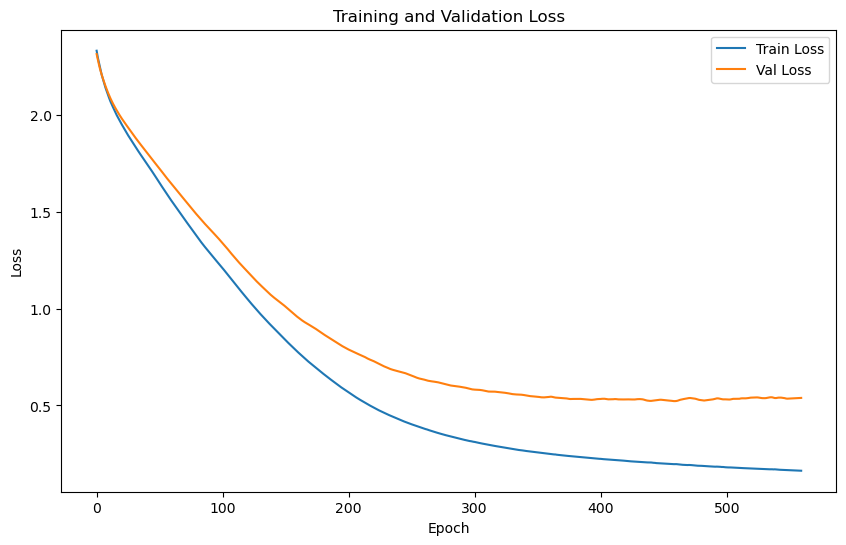

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.1151 | Test Accuracy: 64.25%


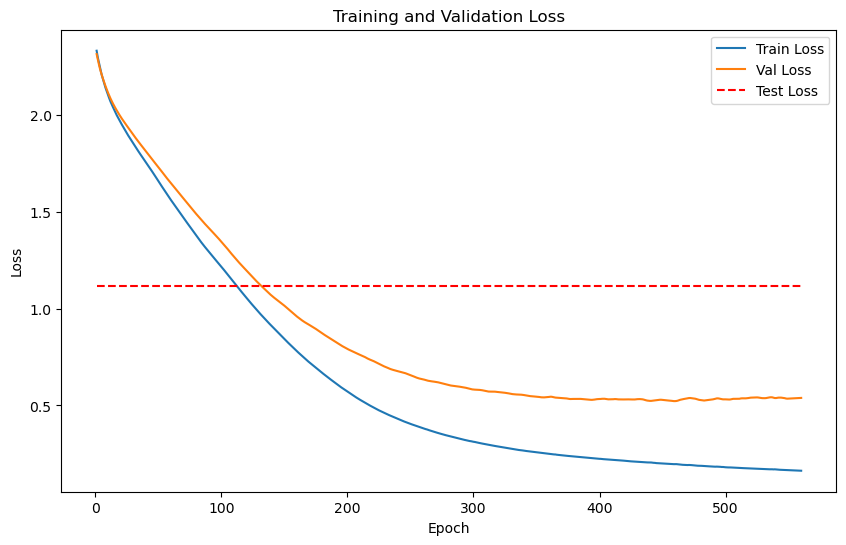

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42641, 64), 
Test labels shape: (42641,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4720
LOG: Epoch [1/2000] - Validation


    Batch [1/1], Val Loss: 0.4806
Epoch [1/2000], Avg Train Loss: 0.4720, Avg Val Loss: 0.4806

Validation loss improved from inf to 0.4806. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4800
Epoch [2/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.4800

Validation loss improved from 0.4806 to 0.4800. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.4706
LOG: Epoch [3/2000] - Validation


    Batch [1/1], Val Loss: 0.4788
Epoch [3/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.4788

Validation loss improved from 0.4800 to 0.4788. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [4/2000] - Validation


    Batch [1/1], Val Loss: 0.4766
Epoch [4/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.4766

Validation loss improved from 0.4788 to 0.4766. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.4606
LOG: Epoch [5/2000] - Validation


    Batch [1/1], Val Loss: 0.4746
Epoch [5/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.4746

Validation loss improved from 0.4766 to 0.4746. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4701
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.4721
Epoch [6/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.4721

Validation loss improved from 0.4746 to 0.4721. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [7/2000] - Validation


    Batch [1/1], Val Loss: 0.4697
Epoch [7/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.4697

Validation loss improved from 0.4721 to 0.4697. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.4674
Epoch [8/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.4674

Validation loss improved from 0.4697 to 0.4674. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [9/2000] - Validation


    Batch [1/1], Val Loss: 0.4655
Epoch [9/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.4655

Validation loss improved from 0.4674 to 0.4655. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4607
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.4634
Epoch [10/2000], Avg Train Loss: 0.4607, Avg Val Loss: 0.4634

Validation loss improved from 0.4655 to 0.4634. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [11/2000] - Validation


    Batch [1/1], Val Loss: 0.4617
Epoch [11/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.4617

Validation loss improved from 0.4634 to 0.4617. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.4595
Epoch [12/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.4595

Validation loss improved from 0.4617 to 0.4595. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.4576
Epoch [13/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.4576

Validation loss improved from 0.4595 to 0.4576. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [14/2000] - Validation


    Batch [1/1], Val Loss: 0.4559
Epoch [14/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.4559

Validation loss improved from 0.4576 to 0.4559. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.4542
Epoch [15/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.4542

Validation loss improved from 0.4559 to 0.4542. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [16/2000] - Validation


    Batch [1/1], Val Loss: 0.4526
Epoch [16/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.4526

Validation loss improved from 0.4542 to 0.4526. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.4512
Epoch [17/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.4512

Validation loss improved from 0.4526 to 0.4512. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.4501
Epoch [18/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.4501

Validation loss improved from 0.4512 to 0.4501. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4580
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.4492
Epoch [19/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.4492

Validation loss improved from 0.4501 to 0.4492. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.4483
Epoch [20/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.4483

Validation loss improved from 0.4492 to 0.4483. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.4475
Epoch [21/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.4475

Validation loss improved from 0.4483 to 0.4475. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.4469
Epoch [22/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.4469

Validation loss improved from 0.4475 to 0.4469. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.4464
Epoch [23/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.4464

Validation loss improved from 0.4469 to 0.4464. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.4458
Epoch [24/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.4458

Validation loss improved from 0.4464 to 0.4458. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [25/2000] - Validation


    Batch [1/1], Val Loss: 0.4454
Epoch [25/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.4454

Validation loss improved from 0.4458 to 0.4454. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.4449
Epoch [26/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.4449

Validation loss improved from 0.4454 to 0.4449. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.4445
Epoch [27/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.4445

Validation loss improved from 0.4449 to 0.4445. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.4441
Epoch [28/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.4441

Validation loss improved from 0.4445 to 0.4441. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.4437
Epoch [29/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.4437

Validation loss improved from 0.4441 to 0.4437. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [30/2000] - Validation


    Batch [1/1], Val Loss: 0.4433
Epoch [30/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.4433

Validation loss improved from 0.4437 to 0.4433. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.4429
Epoch [31/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.4429

Validation loss improved from 0.4433 to 0.4429. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.4425
Epoch [32/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.4425

Validation loss improved from 0.4429 to 0.4425. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.4421
Epoch [33/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.4421

Validation loss improved from 0.4425 to 0.4421. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.4416
Epoch [34/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.4416

Validation loss improved from 0.4421 to 0.4416. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.4412
Epoch [35/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.4412

Validation loss improved from 0.4416 to 0.4412. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.4408
Epoch [36/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.4408

Validation loss improved from 0.4412 to 0.4408. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [37/2000] - Validation


    Batch [1/1], Val Loss: 0.4404
Epoch [37/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.4404

Validation loss improved from 0.4408 to 0.4404. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.4401
Epoch [38/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.4401

Validation loss improved from 0.4404 to 0.4401. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.4398
Epoch [39/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.4398

Validation loss improved from 0.4401 to 0.4398. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.4394
Epoch [40/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.4394

Validation loss improved from 0.4398 to 0.4394. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.4386
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.4389
Epoch [41/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.4389

Validation loss improved from 0.4394 to 0.4389. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4343
LOG: Epoch [42/2000] - Validation


    Batch [1/1], Val Loss: 0.4385
Epoch [42/2000], Avg Train Loss: 0.4343, Avg Val Loss: 0.4385

Validation loss improved from 0.4389 to 0.4385. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4393
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.4381
Epoch [43/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.4381

Validation loss improved from 0.4385 to 0.4381. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [44/2000] - Validation


    Batch [1/1], Val Loss: 0.4377
Epoch [44/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.4377

Validation loss improved from 0.4381 to 0.4377. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.4372
Epoch [45/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.4372

Validation loss improved from 0.4377 to 0.4372. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.4368
Epoch [46/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.4368

Validation loss improved from 0.4372 to 0.4368. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.4363
Epoch [47/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.4363

Validation loss improved from 0.4368 to 0.4363. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.4359
Epoch [48/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.4359

Validation loss improved from 0.4363 to 0.4359. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [49/2000] - Validation


    Batch [1/1], Val Loss: 0.4354
Epoch [49/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.4354

Validation loss improved from 0.4359 to 0.4354. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.4350
Epoch [50/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.4350

Validation loss improved from 0.4354 to 0.4350. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [51/2000] - Validation


    Batch [1/1], Val Loss: 0.4345
Epoch [51/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.4345

Validation loss improved from 0.4350 to 0.4345. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.4341
Epoch [52/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.4341

Validation loss improved from 0.4345 to 0.4341. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [53/2000] - Validation


    Batch [1/1], Val Loss: 0.4337
Epoch [53/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.4337

Validation loss improved from 0.4341 to 0.4337. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.4332
Epoch [54/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.4332

Validation loss improved from 0.4337 to 0.4332. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4184
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.4328
Epoch [55/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.4328

Validation loss improved from 0.4332 to 0.4328. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.4324
Epoch [56/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.4324

Validation loss improved from 0.4328 to 0.4324. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.4319
Epoch [57/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.4319

Validation loss improved from 0.4324 to 0.4319. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.4315
Epoch [58/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.4315

Validation loss improved from 0.4319 to 0.4315. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.4311
Epoch [59/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.4311

Validation loss improved from 0.4315 to 0.4311. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.4307
Epoch [60/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.4307

Validation loss improved from 0.4311 to 0.4307. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.4303
Epoch [61/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.4303

Validation loss improved from 0.4307 to 0.4303. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.4299
Epoch [62/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.4299

Validation loss improved from 0.4303 to 0.4299. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.4294
Epoch [63/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.4294

Validation loss improved from 0.4299 to 0.4294. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.4290
Epoch [64/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.4290

Validation loss improved from 0.4294 to 0.4290. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.4286
Epoch [65/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.4286

Validation loss improved from 0.4290 to 0.4286. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4211
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.4281
Epoch [66/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.4281

Validation loss improved from 0.4286 to 0.4281. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.4277
Epoch [67/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.4277

Validation loss improved from 0.4281 to 0.4277. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [68/2000] - Validation


    Batch [1/1], Val Loss: 0.4273
Epoch [68/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.4273

Validation loss improved from 0.4277 to 0.4273. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.4269
Epoch [69/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.4269

Validation loss improved from 0.4273 to 0.4269. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.4112
LOG: Epoch [70/2000] - Validation


    Batch [1/1], Val Loss: 0.4264
Epoch [70/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.4264

Validation loss improved from 0.4269 to 0.4264. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.4260
Epoch [71/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.4260

Validation loss improved from 0.4264 to 0.4260. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.4115
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.4256
Epoch [72/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.4256

Validation loss improved from 0.4260 to 0.4256. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4115
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.4252
Epoch [73/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.4252

Validation loss improved from 0.4256 to 0.4252. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.4248
Epoch [74/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.4248

Validation loss improved from 0.4252 to 0.4248. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.4245
Epoch [75/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.4245

Validation loss improved from 0.4248 to 0.4245. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.4241
Epoch [76/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.4241

Validation loss improved from 0.4245 to 0.4241. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.4238
Epoch [77/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.4238

Validation loss improved from 0.4241 to 0.4238. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.4234
Epoch [78/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.4234

Validation loss improved from 0.4238 to 0.4234. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.4231
Epoch [79/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.4231

Validation loss improved from 0.4234 to 0.4231. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.4228
Epoch [80/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.4228

Validation loss improved from 0.4231 to 0.4228. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [81/2000] - Validation


    Batch [1/1], Val Loss: 0.4224
Epoch [81/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.4224

Validation loss improved from 0.4228 to 0.4224. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.4220
Epoch [82/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.4220

Validation loss improved from 0.4224 to 0.4220. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.4217
Epoch [83/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.4217

Validation loss improved from 0.4220 to 0.4217. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.4213
Epoch [84/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.4213

Validation loss improved from 0.4217 to 0.4213. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.4210
Epoch [85/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.4210

Validation loss improved from 0.4213 to 0.4210. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.4207
Epoch [86/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.4207

Validation loss improved from 0.4210 to 0.4207. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.4204
Epoch [87/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.4204

Validation loss improved from 0.4207 to 0.4204. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [88/2000] - Validation


    Batch [1/1], Val Loss: 0.4201
Epoch [88/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.4201

Validation loss improved from 0.4204 to 0.4201. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.4197
Epoch [89/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.4197

Validation loss improved from 0.4201 to 0.4197. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.4194
Epoch [90/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.4194

Validation loss improved from 0.4197 to 0.4194. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.4191
Epoch [91/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.4191

Validation loss improved from 0.4194 to 0.4191. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.4188
Epoch [92/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.4188

Validation loss improved from 0.4191 to 0.4188. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.4185
Epoch [93/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.4185

Validation loss improved from 0.4188 to 0.4185. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.4182
Epoch [94/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.4182

Validation loss improved from 0.4185 to 0.4182. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [95/2000] - Validation


    Batch [1/1], Val Loss: 0.4180
Epoch [95/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.4180

Validation loss improved from 0.4182 to 0.4180. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.4177
Epoch [96/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.4177

Validation loss improved from 0.4180 to 0.4177. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.4174
Epoch [97/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.4174

Validation loss improved from 0.4177 to 0.4174. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.4171
Epoch [98/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.4171

Validation loss improved from 0.4174 to 0.4171. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.4168
Epoch [99/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.4168

Validation loss improved from 0.4171 to 0.4168. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.4165
Epoch [100/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.4165

Validation loss improved from 0.4168 to 0.4165. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.4163
Epoch [101/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.4163

Validation loss improved from 0.4165 to 0.4163. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [102/2000] - Validation


    Batch [1/1], Val Loss: 0.4160
Epoch [102/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.4160

Validation loss improved from 0.4163 to 0.4160. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.4157
Epoch [103/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.4157

Validation loss improved from 0.4160 to 0.4157. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [104/2000] - Validation


    Batch [1/1], Val Loss: 0.4154
Epoch [104/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.4154

Validation loss improved from 0.4157 to 0.4154. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.4151
Epoch [105/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.4151

Validation loss improved from 0.4154 to 0.4151. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [106/2000] - Validation


    Batch [1/1], Val Loss: 0.4149
Epoch [106/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.4149

Validation loss improved from 0.4151 to 0.4149. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.4146
Epoch [107/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.4146

Validation loss improved from 0.4149 to 0.4146. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [108/2000] - Validation


    Batch [1/1], Val Loss: 0.4143
Epoch [108/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.4143

Validation loss improved from 0.4146 to 0.4143. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.4141
Epoch [109/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.4141

Validation loss improved from 0.4143 to 0.4141. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.4138
Epoch [110/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.4138

Validation loss improved from 0.4141 to 0.4138. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.4136
Epoch [111/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.4136

Validation loss improved from 0.4138 to 0.4136. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.4134
Epoch [112/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.4134

Validation loss improved from 0.4136 to 0.4134. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [113/2000] - Validation


    Batch [1/1], Val Loss: 0.4132
Epoch [113/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.4132

Validation loss improved from 0.4134 to 0.4132. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3859
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.4129
Epoch [114/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.4129

Validation loss improved from 0.4132 to 0.4129. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.4127
Epoch [115/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.4127

Validation loss improved from 0.4129 to 0.4127. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.4125
Epoch [116/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.4125

Validation loss improved from 0.4127 to 0.4125. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.4123
Epoch [117/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.4123

Validation loss improved from 0.4125 to 0.4123. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [118/2000] - Validation


    Batch [1/1], Val Loss: 0.4120
Epoch [118/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.4120

Validation loss improved from 0.4123 to 0.4120. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.4118
Epoch [119/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.4118

Validation loss improved from 0.4120 to 0.4118. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.4116
Epoch [120/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.4116

Validation loss improved from 0.4118 to 0.4116. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.4114
Epoch [121/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.4114

Validation loss improved from 0.4116 to 0.4114. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.4111
Epoch [122/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.4111

Validation loss improved from 0.4114 to 0.4111. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.4109
Epoch [123/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.4109

Validation loss improved from 0.4111 to 0.4109. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.4107
Epoch [124/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.4107

Validation loss improved from 0.4109 to 0.4107. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.4105
Epoch [125/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.4105

Validation loss improved from 0.4107 to 0.4105. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.4103
Epoch [126/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.4103

Validation loss improved from 0.4105 to 0.4103. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.4101
Epoch [127/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.4101

Validation loss improved from 0.4103 to 0.4101. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [128/2000] - Validation


    Batch [1/1], Val Loss: 0.4099
Epoch [128/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.4099

Validation loss improved from 0.4101 to 0.4099. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.4097
Epoch [129/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.4097

Validation loss improved from 0.4099 to 0.4097. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.4095
Epoch [130/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.4095

Validation loss improved from 0.4097 to 0.4095. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.4093
Epoch [131/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.4093

Validation loss improved from 0.4095 to 0.4093. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.4091
Epoch [132/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.4091

Validation loss improved from 0.4093 to 0.4091. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [133/2000] - Validation


    Batch [1/1], Val Loss: 0.4089
Epoch [133/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.4089

Validation loss improved from 0.4091 to 0.4089. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.4087
Epoch [134/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.4087

Validation loss improved from 0.4089 to 0.4087. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3768
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.4085
Epoch [135/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.4085

Validation loss improved from 0.4087 to 0.4085. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.4082
Epoch [136/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.4082

Validation loss improved from 0.4085 to 0.4082. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.4080
Epoch [137/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.4080

Validation loss improved from 0.4082 to 0.4080. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [138/2000] - Validation


    Batch [1/1], Val Loss: 0.4078
Epoch [138/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.4078

Validation loss improved from 0.4080 to 0.4078. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.4076
Epoch [139/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.4076

Validation loss improved from 0.4078 to 0.4076. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.4074
Epoch [140/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.4074

Validation loss improved from 0.4076 to 0.4074. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.4072
Epoch [141/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.4072

Validation loss improved from 0.4074 to 0.4072. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.4069
Epoch [142/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.4069

Validation loss improved from 0.4072 to 0.4069. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [143/2000] - Validation


    Batch [1/1], Val Loss: 0.4067
Epoch [143/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.4067

Validation loss improved from 0.4069 to 0.4067. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.4065
Epoch [144/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.4065

Validation loss improved from 0.4067 to 0.4065. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3719
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.4063
Epoch [145/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.4063

Validation loss improved from 0.4065 to 0.4063. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.4061
Epoch [146/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.4061

Validation loss improved from 0.4063 to 0.4061. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.4059
Epoch [147/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.4059

Validation loss improved from 0.4061 to 0.4059. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.4057
Epoch [148/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.4057

Validation loss improved from 0.4059 to 0.4057. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3719
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.4055
Epoch [149/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.4055

Validation loss improved from 0.4057 to 0.4055. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [150/2000] - Validation


    Batch [1/1], Val Loss: 0.4053
Epoch [150/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.4053

Validation loss improved from 0.4055 to 0.4053. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.4051
Epoch [151/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.4051

Validation loss improved from 0.4053 to 0.4051. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.4050
Epoch [152/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.4050

Validation loss improved from 0.4051 to 0.4050. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.4048
Epoch [153/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.4048

Validation loss improved from 0.4050 to 0.4048. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.4046
Epoch [154/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.4046

Validation loss improved from 0.4048 to 0.4046. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3576
LOG: Epoch [155/2000] - Validation


    Batch [1/1], Val Loss: 0.4044
Epoch [155/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.4044

Validation loss improved from 0.4046 to 0.4044. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.4043
Epoch [156/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.4043

Validation loss improved from 0.4044 to 0.4043. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.4041
Epoch [157/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.4041

Validation loss improved from 0.4043 to 0.4041. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.4039
Epoch [158/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.4039

Validation loss improved from 0.4041 to 0.4039. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3594
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.4037
Epoch [159/2000], Avg Train Loss: 0.3594, Avg Val Loss: 0.4037

Validation loss improved from 0.4039 to 0.4037. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.3563
LOG: Epoch [160/2000] - Validation


    Batch [1/1], Val Loss: 0.4035
Epoch [160/2000], Avg Train Loss: 0.3563, Avg Val Loss: 0.4035

Validation loss improved from 0.4037 to 0.4035. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.4033
Epoch [161/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.4033

Validation loss improved from 0.4035 to 0.4033. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [162/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.4031

Validation loss improved from 0.4033 to 0.4031. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3591
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [163/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.4030

Validation loss improved from 0.4031 to 0.4030. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3585
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.4028
Epoch [164/2000], Avg Train Loss: 0.3585, Avg Val Loss: 0.4028

Validation loss improved from 0.4030 to 0.4028. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3580
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.4026
Epoch [165/2000], Avg Train Loss: 0.3580, Avg Val Loss: 0.4026

Validation loss improved from 0.4028 to 0.4026. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3560
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.4024
Epoch [166/2000], Avg Train Loss: 0.3560, Avg Val Loss: 0.4024

Validation loss improved from 0.4026 to 0.4024. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3562
LOG: Epoch [167/2000] - Validation


    Batch [1/1], Val Loss: 0.4022
Epoch [167/2000], Avg Train Loss: 0.3562, Avg Val Loss: 0.4022

Validation loss improved from 0.4024 to 0.4022. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.3564
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.4021
Epoch [168/2000], Avg Train Loss: 0.3564, Avg Val Loss: 0.4021

Validation loss improved from 0.4022 to 0.4021. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [169/2000] - Validation


    Batch [1/1], Val Loss: 0.4019
Epoch [169/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.4019

Validation loss improved from 0.4021 to 0.4019. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.4017
Epoch [170/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.4017

Validation loss improved from 0.4019 to 0.4017. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.3556
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.4015
Epoch [171/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.4015

Validation loss improved from 0.4017 to 0.4015. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3525
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.4013
Epoch [172/2000], Avg Train Loss: 0.3525, Avg Val Loss: 0.4013

Validation loss improved from 0.4015 to 0.4013. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3509
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.4011
Epoch [173/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.4011

Validation loss improved from 0.4013 to 0.4011. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3499
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.4008
Epoch [174/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.4008

Validation loss improved from 0.4011 to 0.4008. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.4006
Epoch [175/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.4006

Validation loss improved from 0.4008 to 0.4006. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [176/2000] - Validation


    Batch [1/1], Val Loss: 0.4004
Epoch [176/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.4004

Validation loss improved from 0.4006 to 0.4004. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.4002
Epoch [177/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.4002

Validation loss improved from 0.4004 to 0.4002. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [178/2000] - Validation


    Batch [1/1], Val Loss: 0.4001
Epoch [178/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.4001

Validation loss improved from 0.4002 to 0.4001. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3999
Epoch [179/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.3999

Validation loss improved from 0.4001 to 0.3999. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.3537
LOG: Epoch [180/2000] - Validation


    Batch [1/1], Val Loss: 0.3997
Epoch [180/2000], Avg Train Loss: 0.3537, Avg Val Loss: 0.3997

Validation loss improved from 0.3999 to 0.3997. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.3522
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.3995
Epoch [181/2000], Avg Train Loss: 0.3522, Avg Val Loss: 0.3995

Validation loss improved from 0.3997 to 0.3995. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.3535
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3993
Epoch [182/2000], Avg Train Loss: 0.3535, Avg Val Loss: 0.3993

Validation loss improved from 0.3995 to 0.3993. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.3991
Epoch [183/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.3991

Validation loss improved from 0.3993 to 0.3991. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.3525
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3989
Epoch [184/2000], Avg Train Loss: 0.3525, Avg Val Loss: 0.3989

Validation loss improved from 0.3991 to 0.3989. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3988
Epoch [185/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.3988

Validation loss improved from 0.3989 to 0.3988. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3986
Epoch [186/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.3986

Validation loss improved from 0.3988 to 0.3986. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3984
Epoch [187/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.3984

Validation loss improved from 0.3986 to 0.3984. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.3981
Epoch [188/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.3981

Validation loss improved from 0.3984 to 0.3981. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3980
Epoch [189/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.3980

Validation loss improved from 0.3981 to 0.3980. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3978
Epoch [190/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.3978

Validation loss improved from 0.3980 to 0.3978. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3392
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3975
Epoch [191/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.3975

Validation loss improved from 0.3978 to 0.3975. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.3413
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3973
Epoch [192/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.3973

Validation loss improved from 0.3975 to 0.3973. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.3971
Epoch [193/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.3971

Validation loss improved from 0.3973 to 0.3971. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3969
Epoch [194/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.3969

Validation loss improved from 0.3971 to 0.3969. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.3967
Epoch [195/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.3967

Validation loss improved from 0.3969 to 0.3967. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3363
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3965
Epoch [196/2000], Avg Train Loss: 0.3363, Avg Val Loss: 0.3965

Validation loss improved from 0.3967 to 0.3965. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.3963
Epoch [197/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.3963

Validation loss improved from 0.3965 to 0.3963. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [198/2000] - Validation


    Batch [1/1], Val Loss: 0.3961
Epoch [198/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.3961

Validation loss improved from 0.3963 to 0.3961. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.3391
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.3959
Epoch [199/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.3959

Validation loss improved from 0.3961 to 0.3959. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3957
Epoch [200/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.3957

Validation loss improved from 0.3959 to 0.3957. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3955
Epoch [201/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.3955

Validation loss improved from 0.3957 to 0.3955. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3953
Epoch [202/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.3953

Validation loss improved from 0.3955 to 0.3953. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3361
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3951
Epoch [203/2000], Avg Train Loss: 0.3361, Avg Val Loss: 0.3951

Validation loss improved from 0.3953 to 0.3951. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.3374
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3949
Epoch [204/2000], Avg Train Loss: 0.3374, Avg Val Loss: 0.3949

Validation loss improved from 0.3951 to 0.3949. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.3344
LOG: Epoch [205/2000] - Validation


    Batch [1/1], Val Loss: 0.3947
Epoch [205/2000], Avg Train Loss: 0.3344, Avg Val Loss: 0.3947

Validation loss improved from 0.3949 to 0.3947. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.3359
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.3945
Epoch [206/2000], Avg Train Loss: 0.3359, Avg Val Loss: 0.3945

Validation loss improved from 0.3947 to 0.3945. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.3300
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3943
Epoch [207/2000], Avg Train Loss: 0.3300, Avg Val Loss: 0.3943

Validation loss improved from 0.3945 to 0.3943. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3293
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.3941
Epoch [208/2000], Avg Train Loss: 0.3293, Avg Val Loss: 0.3941

Validation loss improved from 0.3943 to 0.3941. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.3367
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3939
Epoch [209/2000], Avg Train Loss: 0.3367, Avg Val Loss: 0.3939

Validation loss improved from 0.3941 to 0.3939. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.3267
LOG: Epoch [210/2000] - Validation


    Batch [1/1], Val Loss: 0.3937
Epoch [210/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.3937

Validation loss improved from 0.3939 to 0.3937. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.3357
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3935
Epoch [211/2000], Avg Train Loss: 0.3357, Avg Val Loss: 0.3935

Validation loss improved from 0.3937 to 0.3935. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.3375
LOG: Epoch [212/2000] - Validation


    Batch [1/1], Val Loss: 0.3933
Epoch [212/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.3933

Validation loss improved from 0.3935 to 0.3933. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.3381
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.3931
Epoch [213/2000], Avg Train Loss: 0.3381, Avg Val Loss: 0.3931

Validation loss improved from 0.3933 to 0.3931. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.3364
LOG: Epoch [214/2000] - Validation


    Batch [1/1], Val Loss: 0.3929
Epoch [214/2000], Avg Train Loss: 0.3364, Avg Val Loss: 0.3929

Validation loss improved from 0.3931 to 0.3929. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.3927
Epoch [215/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.3927

Validation loss improved from 0.3929 to 0.3927. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.3350
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.3925
Epoch [216/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.3925

Validation loss improved from 0.3927 to 0.3925. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3296
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3923
Epoch [217/2000], Avg Train Loss: 0.3296, Avg Val Loss: 0.3923

Validation loss improved from 0.3925 to 0.3923. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.3307
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.3921
Epoch [218/2000], Avg Train Loss: 0.3307, Avg Val Loss: 0.3921

Validation loss improved from 0.3923 to 0.3921. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3309
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.3919
Epoch [219/2000], Avg Train Loss: 0.3309, Avg Val Loss: 0.3919

Validation loss improved from 0.3921 to 0.3919. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.3283
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3917
Epoch [220/2000], Avg Train Loss: 0.3283, Avg Val Loss: 0.3917

Validation loss improved from 0.3919 to 0.3917. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3264
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3916
Epoch [221/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.3916

Validation loss improved from 0.3917 to 0.3916. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.3236
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3914
Epoch [222/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.3914

Validation loss improved from 0.3916 to 0.3914. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3320
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [223/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.3913

Validation loss improved from 0.3914 to 0.3913. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.3338
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.3912
Epoch [224/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.3912

Validation loss improved from 0.3913 to 0.3912. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.3321
LOG: Epoch [225/2000] - Validation


    Batch [1/1], Val Loss: 0.3911
Epoch [225/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.3911

Validation loss improved from 0.3912 to 0.3911. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.3911
Epoch [226/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.3911

Validation loss improved from 0.3911 to 0.3911. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3232
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3910
Epoch [227/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.3910

Validation loss improved from 0.3911 to 0.3910. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.3308
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.3910
Epoch [228/2000], Avg Train Loss: 0.3308, Avg Val Loss: 0.3910

Validation loss improved from 0.3910 to 0.3910. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3282
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3909
Epoch [229/2000], Avg Train Loss: 0.3282, Avg Val Loss: 0.3909

Validation loss improved from 0.3910 to 0.3909. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.3251
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3908
Epoch [230/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.3908

Validation loss improved from 0.3909 to 0.3908. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3247
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3907
Epoch [231/2000], Avg Train Loss: 0.3247, Avg Val Loss: 0.3907

Validation loss improved from 0.3908 to 0.3907. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.3907
Epoch [232/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.3907

Validation loss improved from 0.3907 to 0.3907. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.3260
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3905
Epoch [233/2000], Avg Train Loss: 0.3260, Avg Val Loss: 0.3905

Validation loss improved from 0.3907 to 0.3905. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3904
Epoch [234/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.3904

Validation loss improved from 0.3905 to 0.3904. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.3220
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.3903
Epoch [235/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.3903

Validation loss improved from 0.3904 to 0.3903. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.3238
LOG: Epoch [236/2000] - Validation


    Batch [1/1], Val Loss: 0.3902
Epoch [236/2000], Avg Train Loss: 0.3238, Avg Val Loss: 0.3902

Validation loss improved from 0.3903 to 0.3902. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3901
Epoch [237/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.3901

Validation loss improved from 0.3902 to 0.3901. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.3225
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.3899
Epoch [238/2000], Avg Train Loss: 0.3225, Avg Val Loss: 0.3899

Validation loss improved from 0.3901 to 0.3899. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3270
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.3898
Epoch [239/2000], Avg Train Loss: 0.3270, Avg Val Loss: 0.3898

Validation loss improved from 0.3899 to 0.3898. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.3221
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.3897
Epoch [240/2000], Avg Train Loss: 0.3221, Avg Val Loss: 0.3897

Validation loss improved from 0.3898 to 0.3897. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.3210
LOG: Epoch [241/2000] - Validation


    Batch [1/1], Val Loss: 0.3895
Epoch [241/2000], Avg Train Loss: 0.3210, Avg Val Loss: 0.3895

Validation loss improved from 0.3897 to 0.3895. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.3134
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3894
Epoch [242/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.3894

Validation loss improved from 0.3895 to 0.3894. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.3165
LOG: Epoch [243/2000] - Validation


    Batch [1/1], Val Loss: 0.3892
Epoch [243/2000], Avg Train Loss: 0.3165, Avg Val Loss: 0.3892

Validation loss improved from 0.3894 to 0.3892. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.3138
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3891
Epoch [244/2000], Avg Train Loss: 0.3138, Avg Val Loss: 0.3891

Validation loss improved from 0.3892 to 0.3891. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [245/2000] - Validation


    Batch [1/1], Val Loss: 0.3890
Epoch [245/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.3890

Validation loss improved from 0.3891 to 0.3890. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.3297
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3888
Epoch [246/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.3888

Validation loss improved from 0.3890 to 0.3888. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.3195
LOG: Epoch [247/2000] - Validation


    Batch [1/1], Val Loss: 0.3886
Epoch [247/2000], Avg Train Loss: 0.3195, Avg Val Loss: 0.3886

Validation loss improved from 0.3888 to 0.3886. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.3185
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3885
Epoch [248/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.3885

Validation loss improved from 0.3886 to 0.3885. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.3250
LOG: Epoch [249/2000] - Validation


    Batch [1/1], Val Loss: 0.3883
Epoch [249/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.3883

Validation loss improved from 0.3885 to 0.3883. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.3136
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.3882
Epoch [250/2000], Avg Train Loss: 0.3136, Avg Val Loss: 0.3882

Validation loss improved from 0.3883 to 0.3882. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.3237
LOG: Epoch [251/2000] - Validation


    Batch [1/1], Val Loss: 0.3880
Epoch [251/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.3880

Validation loss improved from 0.3882 to 0.3880. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.3200
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.3878
Epoch [252/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.3878

Validation loss improved from 0.3880 to 0.3878. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.3198
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3877
Epoch [253/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.3877

Validation loss improved from 0.3878 to 0.3877. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3115
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.3876
Epoch [254/2000], Avg Train Loss: 0.3115, Avg Val Loss: 0.3876

Validation loss improved from 0.3877 to 0.3876. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3875
Epoch [255/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.3875

Validation loss improved from 0.3876 to 0.3875. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3153
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.3873
Epoch [256/2000], Avg Train Loss: 0.3153, Avg Val Loss: 0.3873

Validation loss improved from 0.3875 to 0.3873. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.3153
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3871
Epoch [257/2000], Avg Train Loss: 0.3153, Avg Val Loss: 0.3871

Validation loss improved from 0.3873 to 0.3871. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.3052
LOG: Epoch [258/2000] - Validation


    Batch [1/1], Val Loss: 0.3869
Epoch [258/2000], Avg Train Loss: 0.3052, Avg Val Loss: 0.3869

Validation loss improved from 0.3871 to 0.3869. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.3191
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.3868
Epoch [259/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.3868

Validation loss improved from 0.3869 to 0.3868. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.3131
LOG: Epoch [260/2000] - Validation


    Batch [1/1], Val Loss: 0.3866
Epoch [260/2000], Avg Train Loss: 0.3131, Avg Val Loss: 0.3866

Validation loss improved from 0.3868 to 0.3866. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.3202
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3865
Epoch [261/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.3865

Validation loss improved from 0.3866 to 0.3865. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.3126
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3863
Epoch [262/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.3863

Validation loss improved from 0.3865 to 0.3863. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3103
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.3861
Epoch [263/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.3861

Validation loss improved from 0.3863 to 0.3861. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.3046
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3858
Epoch [264/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.3858

Validation loss improved from 0.3861 to 0.3858. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.3166
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.3857
Epoch [265/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.3857

Validation loss improved from 0.3858 to 0.3857. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.3064
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.3855
Epoch [266/2000], Avg Train Loss: 0.3064, Avg Val Loss: 0.3855

Validation loss improved from 0.3857 to 0.3855. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.3216
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.3854
Epoch [267/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.3854

Validation loss improved from 0.3855 to 0.3854. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.3044
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.3852
Epoch [268/2000], Avg Train Loss: 0.3044, Avg Val Loss: 0.3852

Validation loss improved from 0.3854 to 0.3852. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.3851
Epoch [269/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.3851

Validation loss improved from 0.3852 to 0.3851. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.3123
LOG: Epoch [270/2000] - Validation


    Batch [1/1], Val Loss: 0.3850
Epoch [270/2000], Avg Train Loss: 0.3123, Avg Val Loss: 0.3850

Validation loss improved from 0.3851 to 0.3850. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.3094
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3849
Epoch [271/2000], Avg Train Loss: 0.3094, Avg Val Loss: 0.3849

Validation loss improved from 0.3850 to 0.3849. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.3087
LOG: Epoch [272/2000] - Validation


    Batch [1/1], Val Loss: 0.3848
Epoch [272/2000], Avg Train Loss: 0.3087, Avg Val Loss: 0.3848

Validation loss improved from 0.3849 to 0.3848. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.2970
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.3847
Epoch [273/2000], Avg Train Loss: 0.2970, Avg Val Loss: 0.3847

Validation loss improved from 0.3848 to 0.3847. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.3075
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [274/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.3846

Validation loss improved from 0.3847 to 0.3846. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3098
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [275/2000], Avg Train Loss: 0.3098, Avg Val Loss: 0.3845

Validation loss improved from 0.3846 to 0.3845. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.3077
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3843
Epoch [276/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.3843

Validation loss improved from 0.3845 to 0.3843. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.2991
LOG: Epoch [277/2000] - Validation


    Batch [1/1], Val Loss: 0.3842
Epoch [277/2000], Avg Train Loss: 0.2991, Avg Val Loss: 0.3842

Validation loss improved from 0.3843 to 0.3842. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.3841
Epoch [278/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.3841

Validation loss improved from 0.3842 to 0.3841. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.3840
Epoch [279/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.3840

Validation loss improved from 0.3841 to 0.3840. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.3088
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.3839
Epoch [280/2000], Avg Train Loss: 0.3088, Avg Val Loss: 0.3839

Validation loss improved from 0.3840 to 0.3839. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.3068
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.3838
Epoch [281/2000], Avg Train Loss: 0.3068, Avg Val Loss: 0.3838

Validation loss improved from 0.3839 to 0.3838. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.3038
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.3837
Epoch [282/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.3837

Validation loss improved from 0.3838 to 0.3837. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.3006
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3836
Epoch [283/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.3836

Validation loss improved from 0.3837 to 0.3836. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.2952
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.3835
Epoch [284/2000], Avg Train Loss: 0.2952, Avg Val Loss: 0.3835

Validation loss improved from 0.3836 to 0.3835. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.3047
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3834
Epoch [285/2000], Avg Train Loss: 0.3047, Avg Val Loss: 0.3834

Validation loss improved from 0.3835 to 0.3834. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.3038
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.3833
Epoch [286/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.3833

Validation loss improved from 0.3834 to 0.3833. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2982
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3831
Epoch [287/2000], Avg Train Loss: 0.2982, Avg Val Loss: 0.3831

Validation loss improved from 0.3833 to 0.3831. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.3064
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.3830
Epoch [288/2000], Avg Train Loss: 0.3064, Avg Val Loss: 0.3830

Validation loss improved from 0.3831 to 0.3830. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.2993
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.3828
Epoch [289/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.3828

Validation loss improved from 0.3830 to 0.3828. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.3046
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3827
Epoch [290/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.3827

Validation loss improved from 0.3828 to 0.3827. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.2956
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.3826
Epoch [291/2000], Avg Train Loss: 0.2956, Avg Val Loss: 0.3826

Validation loss improved from 0.3827 to 0.3826. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.3824
Epoch [292/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.3824

Validation loss improved from 0.3826 to 0.3824. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.3009
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.3823
Epoch [293/2000], Avg Train Loss: 0.3009, Avg Val Loss: 0.3823

Validation loss improved from 0.3824 to 0.3823. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.2939
LOG: Epoch [294/2000] - Validation


    Batch [1/1], Val Loss: 0.3822
Epoch [294/2000], Avg Train Loss: 0.2939, Avg Val Loss: 0.3822

Validation loss improved from 0.3823 to 0.3822. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.3052
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.3821
Epoch [295/2000], Avg Train Loss: 0.3052, Avg Val Loss: 0.3821

Validation loss improved from 0.3822 to 0.3821. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.3080
LOG: Epoch [296/2000] - Validation


    Batch [1/1], Val Loss: 0.3819
Epoch [296/2000], Avg Train Loss: 0.3080, Avg Val Loss: 0.3819

Validation loss improved from 0.3821 to 0.3819. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.2996
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.3818
Epoch [297/2000], Avg Train Loss: 0.2996, Avg Val Loss: 0.3818

Validation loss improved from 0.3819 to 0.3818. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.2974
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.3817
Epoch [298/2000], Avg Train Loss: 0.2974, Avg Val Loss: 0.3817

Validation loss improved from 0.3818 to 0.3817. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.2977
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.3816
Epoch [299/2000], Avg Train Loss: 0.2977, Avg Val Loss: 0.3816

Validation loss improved from 0.3817 to 0.3816. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.2988
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.3816
Epoch [300/2000], Avg Train Loss: 0.2988, Avg Val Loss: 0.3816

Validation loss improved from 0.3816 to 0.3816. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.2957
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3815
Epoch [301/2000], Avg Train Loss: 0.2957, Avg Val Loss: 0.3815

Validation loss improved from 0.3816 to 0.3815. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2911
LOG: Epoch [302/2000] - Validation


    Batch [1/1], Val Loss: 0.3814
Epoch [302/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.3814

Validation loss improved from 0.3815 to 0.3814. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.3022
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.3812
Epoch [303/2000], Avg Train Loss: 0.3022, Avg Val Loss: 0.3812

Validation loss improved from 0.3814 to 0.3812. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2925
LOG: Epoch [304/2000] - Validation


    Batch [1/1], Val Loss: 0.3811
Epoch [304/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.3811

Validation loss improved from 0.3812 to 0.3811. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.2986
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.3809
Epoch [305/2000], Avg Train Loss: 0.2986, Avg Val Loss: 0.3809

Validation loss improved from 0.3811 to 0.3809. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2914
LOG: Epoch [306/2000] - Validation


    Batch [1/1], Val Loss: 0.3808
Epoch [306/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.3808

Validation loss improved from 0.3809 to 0.3808. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.2996
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.3807
Epoch [307/2000], Avg Train Loss: 0.2996, Avg Val Loss: 0.3807

Validation loss improved from 0.3808 to 0.3807. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.3044
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.3806
Epoch [308/2000], Avg Train Loss: 0.3044, Avg Val Loss: 0.3806

Validation loss improved from 0.3807 to 0.3806. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.2923
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3805
Epoch [309/2000], Avg Train Loss: 0.2923, Avg Val Loss: 0.3805

Validation loss improved from 0.3806 to 0.3805. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.2917
LOG: Epoch [310/2000] - Validation


    Batch [1/1], Val Loss: 0.3804
Epoch [310/2000], Avg Train Loss: 0.2917, Avg Val Loss: 0.3804

Validation loss improved from 0.3805 to 0.3804. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2883
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.3803
Epoch [311/2000], Avg Train Loss: 0.2883, Avg Val Loss: 0.3803

Validation loss improved from 0.3804 to 0.3803. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.2921
LOG: Epoch [312/2000] - Validation


    Batch [1/1], Val Loss: 0.3802
Epoch [312/2000], Avg Train Loss: 0.2921, Avg Val Loss: 0.3802

Validation loss improved from 0.3803 to 0.3802. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.2966
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3801
Epoch [313/2000], Avg Train Loss: 0.2966, Avg Val Loss: 0.3801

Validation loss improved from 0.3802 to 0.3801. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.3800
Epoch [314/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.3800

Validation loss improved from 0.3801 to 0.3800. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.2859
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3799
Epoch [315/2000], Avg Train Loss: 0.2859, Avg Val Loss: 0.3799

Validation loss improved from 0.3800 to 0.3799. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2844
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.3799
Epoch [316/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.3799

Validation loss improved from 0.3799 to 0.3799. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.2915
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3798
Epoch [317/2000], Avg Train Loss: 0.2915, Avg Val Loss: 0.3798

Validation loss improved from 0.3799 to 0.3798. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2843
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3797
Epoch [318/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.3797

Validation loss improved from 0.3798 to 0.3797. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.2864
LOG: Epoch [319/2000] - Validation


    Batch [1/1], Val Loss: 0.3795
Epoch [319/2000], Avg Train Loss: 0.2864, Avg Val Loss: 0.3795

Validation loss improved from 0.3797 to 0.3795. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.3794
Epoch [320/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.3794

Validation loss improved from 0.3795 to 0.3794. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.2932
LOG: Epoch [321/2000] - Validation


    Batch [1/1], Val Loss: 0.3792
Epoch [321/2000], Avg Train Loss: 0.2932, Avg Val Loss: 0.3792

Validation loss improved from 0.3794 to 0.3792. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2919
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3790
Epoch [322/2000], Avg Train Loss: 0.2919, Avg Val Loss: 0.3790

Validation loss improved from 0.3792 to 0.3790. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.2881
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.3789
Epoch [323/2000], Avg Train Loss: 0.2881, Avg Val Loss: 0.3789

Validation loss improved from 0.3790 to 0.3789. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3787
Epoch [324/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.3787

Validation loss improved from 0.3789 to 0.3787. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2851
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.3786
Epoch [325/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.3786

Validation loss improved from 0.3787 to 0.3786. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [326/2000] - Validation


    Batch [1/1], Val Loss: 0.3785
Epoch [326/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.3785

Validation loss improved from 0.3786 to 0.3785. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3784
Epoch [327/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.3784

Validation loss improved from 0.3785 to 0.3784. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.2855
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.3784
Epoch [328/2000], Avg Train Loss: 0.2855, Avg Val Loss: 0.3784

Validation loss improved from 0.3784 to 0.3784. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.3784
Epoch [329/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.3784

Validation loss improved from 0.3784 to 0.3784. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.3783
Epoch [330/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.3783

Validation loss improved from 0.3784 to 0.3783. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.3784
Epoch [331/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.3784

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.2888
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.3784
Epoch [332/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.3784

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.2872
LOG: Epoch [333/2000] - Validation


    Batch [1/1], Val Loss: 0.3784
Epoch [333/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.3784

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.2746
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.3784
Epoch [334/2000], Avg Train Loss: 0.2746, Avg Val Loss: 0.3784

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2862
LOG: Epoch [335/2000] - Validation


    Batch [1/1], Val Loss: 0.3784
Epoch [335/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.3784

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3783
Epoch [336/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.3783

Validation loss improved from 0.3783 to 0.3783. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [337/2000] - Validation


    Batch [1/1], Val Loss: 0.3782
Epoch [337/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.3782

Validation loss improved from 0.3783 to 0.3782. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.3781
Epoch [338/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.3781

Validation loss improved from 0.3782 to 0.3781. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.3780
Epoch [339/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.3780

Validation loss improved from 0.3781 to 0.3780. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.3778
Epoch [340/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.3778

Validation loss improved from 0.3780 to 0.3778. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.3777
Epoch [341/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.3777

Validation loss improved from 0.3778 to 0.3777. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.2738
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3776
Epoch [342/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.3776

Validation loss improved from 0.3777 to 0.3776. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.3775
Epoch [343/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.3775

Validation loss improved from 0.3776 to 0.3775. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.3774
Epoch [344/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.3774

Validation loss improved from 0.3775 to 0.3774. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.3773
Epoch [345/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.3773

Validation loss improved from 0.3774 to 0.3773. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [346/2000] - Validation


    Batch [1/1], Val Loss: 0.3772
Epoch [346/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.3772

Validation loss improved from 0.3773 to 0.3772. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3770
Epoch [347/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.3770

Validation loss improved from 0.3772 to 0.3770. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.3769
Epoch [348/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.3769

Validation loss improved from 0.3770 to 0.3769. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.3767
Epoch [349/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.3767

Validation loss improved from 0.3769 to 0.3767. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.3766
Epoch [350/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.3766

Validation loss improved from 0.3767 to 0.3766. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [351/2000] - Validation


    Batch [1/1], Val Loss: 0.3764
Epoch [351/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.3764

Validation loss improved from 0.3766 to 0.3764. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.3762
Epoch [352/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.3762

Validation loss improved from 0.3764 to 0.3762. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.3761
Epoch [353/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.3761

Validation loss improved from 0.3762 to 0.3761. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.3760
Epoch [354/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.3760

Validation loss improved from 0.3761 to 0.3760. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3759
Epoch [355/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.3759

Validation loss improved from 0.3760 to 0.3759. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [356/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.3757

Validation loss improved from 0.3759 to 0.3757. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [357/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.3756

Validation loss improved from 0.3757 to 0.3756. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [358/2000] - Validation


    Batch [1/1], Val Loss: 0.3755
Epoch [358/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.3755

Validation loss improved from 0.3756 to 0.3755. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.3753
Epoch [359/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.3753

Validation loss improved from 0.3755 to 0.3753. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [360/2000] - Validation


    Batch [1/1], Val Loss: 0.3752
Epoch [360/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.3752

Validation loss improved from 0.3753 to 0.3752. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [361/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.3751

Validation loss improved from 0.3752 to 0.3751. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.2698
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [362/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.3751

Validation loss improved from 0.3751 to 0.3751. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.3750
Epoch [363/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.3750

Validation loss improved from 0.3751 to 0.3750. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.2724
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3750
Epoch [364/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.3750

Validation loss improved from 0.3750 to 0.3750. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [365/2000] - Validation


    Batch [1/1], Val Loss: 0.3749
Epoch [365/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.3749

Validation loss improved from 0.3750 to 0.3749. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.3750
Epoch [366/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.3750

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [367/2000] - Validation


    Batch [1/1], Val Loss: 0.3750
Epoch [367/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.3750

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.3750
Epoch [368/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.3750

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.3750
Epoch [369/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.3750

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.3750
Epoch [370/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.3750

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [371/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.3751

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [372/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.3751

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.2709
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [373/2000], Avg Train Loss: 0.2709, Avg Val Loss: 0.3751

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [374/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.3751

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [375/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.3751

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [376/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.3751

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [377/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.3751

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.2735
LOG: Epoch [378/2000] - Validation


    Batch [1/1], Val Loss: 0.3751
Epoch [378/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.3751

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3750
Epoch [379/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.3750

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3749
Epoch [380/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.3749

Validation loss improved from 0.3749 to 0.3749. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2634
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.3748
Epoch [381/2000], Avg Train Loss: 0.2634, Avg Val Loss: 0.3748

Validation loss improved from 0.3749 to 0.3748. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.3746
Epoch [382/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.3746

Validation loss improved from 0.3748 to 0.3746. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.3745
Epoch [383/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.3745

Validation loss improved from 0.3746 to 0.3745. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.3743
Epoch [384/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.3743

Validation loss improved from 0.3745 to 0.3743. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.2594
LOG: Epoch [385/2000] - Validation


    Batch [1/1], Val Loss: 0.3741
Epoch [385/2000], Avg Train Loss: 0.2594, Avg Val Loss: 0.3741

Validation loss improved from 0.3743 to 0.3741. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.3739
Epoch [386/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.3739

Validation loss improved from 0.3741 to 0.3739. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [387/2000] - Validation


    Batch [1/1], Val Loss: 0.3736
Epoch [387/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.3736

Validation loss improved from 0.3739 to 0.3736. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.2586
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.3733
Epoch [388/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.3733

Validation loss improved from 0.3736 to 0.3733. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [389/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.3731

Validation loss improved from 0.3733 to 0.3731. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2546
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.3729
Epoch [390/2000], Avg Train Loss: 0.2546, Avg Val Loss: 0.3729

Validation loss improved from 0.3731 to 0.3729. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.2566
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.3728
Epoch [391/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.3728

Validation loss improved from 0.3729 to 0.3728. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [392/2000] - Validation


    Batch [1/1], Val Loss: 0.3726
Epoch [392/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.3726

Validation loss improved from 0.3728 to 0.3726. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.3725
Epoch [393/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.3725

Validation loss improved from 0.3726 to 0.3725. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.2532
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.3724
Epoch [394/2000], Avg Train Loss: 0.2532, Avg Val Loss: 0.3724

Validation loss improved from 0.3725 to 0.3724. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.2630
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.3723
Epoch [395/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.3723

Validation loss improved from 0.3724 to 0.3723. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2587
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.3722
Epoch [396/2000], Avg Train Loss: 0.2587, Avg Val Loss: 0.3722

Validation loss improved from 0.3723 to 0.3722. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.2616
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.3721
Epoch [397/2000], Avg Train Loss: 0.2616, Avg Val Loss: 0.3721

Validation loss improved from 0.3722 to 0.3721. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.2601
LOG: Epoch [398/2000] - Validation


    Batch [1/1], Val Loss: 0.3720
Epoch [398/2000], Avg Train Loss: 0.2601, Avg Val Loss: 0.3720

Validation loss improved from 0.3721 to 0.3720. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.2593
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.3719
Epoch [399/2000], Avg Train Loss: 0.2593, Avg Val Loss: 0.3719

Validation loss improved from 0.3720 to 0.3719. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.2513
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.3719
Epoch [400/2000], Avg Train Loss: 0.2513, Avg Val Loss: 0.3719

Validation loss improved from 0.3719 to 0.3719. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.2540
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.3718
Epoch [401/2000], Avg Train Loss: 0.2540, Avg Val Loss: 0.3718

Validation loss improved from 0.3719 to 0.3718. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.2504
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.3718
Epoch [402/2000], Avg Train Loss: 0.2504, Avg Val Loss: 0.3718

Validation loss improved from 0.3718 to 0.3718. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.2555
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.3717
Epoch [403/2000], Avg Train Loss: 0.2555, Avg Val Loss: 0.3717

Validation loss improved from 0.3718 to 0.3717. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.3717
Epoch [404/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.3717

Validation loss improved from 0.3717 to 0.3717. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.2523
LOG: Epoch [405/2000] - Validation


    Batch [1/1], Val Loss: 0.3716
Epoch [405/2000], Avg Train Loss: 0.2523, Avg Val Loss: 0.3716

Validation loss improved from 0.3717 to 0.3716. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.2519
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.3715
Epoch [406/2000], Avg Train Loss: 0.2519, Avg Val Loss: 0.3715

Validation loss improved from 0.3716 to 0.3715. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.2527
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3715
Epoch [407/2000], Avg Train Loss: 0.2527, Avg Val Loss: 0.3715

Validation loss improved from 0.3715 to 0.3715. Saving model...
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.2573
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.3715
Epoch [408/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.3715

Validation loss improved from 0.3715 to 0.3715. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2532
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3715
Epoch [409/2000], Avg Train Loss: 0.2532, Avg Val Loss: 0.3715

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3715
Epoch [410/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.3715

Validation loss improved from 0.3715 to 0.3715. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2576
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.3715
Epoch [411/2000], Avg Train Loss: 0.2576, Avg Val Loss: 0.3715

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.2584
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3715
Epoch [412/2000], Avg Train Loss: 0.2584, Avg Val Loss: 0.3715

Validation loss improved from 0.3715 to 0.3715. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.2588
LOG: Epoch [413/2000] - Validation


    Batch [1/1], Val Loss: 0.3715
Epoch [413/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.3715

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.2529
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3715
Epoch [414/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.3715

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2454
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.3715
Epoch [415/2000], Avg Train Loss: 0.2454, Avg Val Loss: 0.3715

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.2509
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.3715
Epoch [416/2000], Avg Train Loss: 0.2509, Avg Val Loss: 0.3715

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.2544
LOG: Epoch [417/2000] - Validation


    Batch [1/1], Val Loss: 0.3715
Epoch [417/2000], Avg Train Loss: 0.2544, Avg Val Loss: 0.3715

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.2555
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.3715
Epoch [418/2000], Avg Train Loss: 0.2555, Avg Val Loss: 0.3715

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3714
Epoch [419/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.3714

Validation loss improved from 0.3715 to 0.3714. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2556
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.3713
Epoch [420/2000], Avg Train Loss: 0.2556, Avg Val Loss: 0.3713

Validation loss improved from 0.3714 to 0.3713. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.2606
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.3712
Epoch [421/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.3712

Validation loss improved from 0.3713 to 0.3712. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2409
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.3712
Epoch [422/2000], Avg Train Loss: 0.2409, Avg Val Loss: 0.3712

Validation loss improved from 0.3712 to 0.3712. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.2472
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3711
Epoch [423/2000], Avg Train Loss: 0.2472, Avg Val Loss: 0.3711

Validation loss improved from 0.3712 to 0.3711. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2564
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.3710
Epoch [424/2000], Avg Train Loss: 0.2564, Avg Val Loss: 0.3710

Validation loss improved from 0.3711 to 0.3710. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.2443
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3709
Epoch [425/2000], Avg Train Loss: 0.2443, Avg Val Loss: 0.3709

Validation loss improved from 0.3710 to 0.3709. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2536
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.3708
Epoch [426/2000], Avg Train Loss: 0.2536, Avg Val Loss: 0.3708

Validation loss improved from 0.3709 to 0.3708. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.3707
Epoch [427/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.3707

Validation loss improved from 0.3708 to 0.3707. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.2498
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3706
Epoch [428/2000], Avg Train Loss: 0.2498, Avg Val Loss: 0.3706

Validation loss improved from 0.3707 to 0.3706. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.2487
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.3704
Epoch [429/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.3704

Validation loss improved from 0.3706 to 0.3704. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.3704
Epoch [430/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.3704

Validation loss improved from 0.3704 to 0.3704. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.2531
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.3703
Epoch [431/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.3703

Validation loss improved from 0.3704 to 0.3703. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.2547
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3702
Epoch [432/2000], Avg Train Loss: 0.2547, Avg Val Loss: 0.3702

Validation loss improved from 0.3703 to 0.3702. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.2478
LOG: Epoch [433/2000] - Validation


    Batch [1/1], Val Loss: 0.3702
Epoch [433/2000], Avg Train Loss: 0.2478, Avg Val Loss: 0.3702

Validation loss improved from 0.3702 to 0.3702. Saving model...
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.2552
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.3702
Epoch [434/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.3702

Validation loss improved from 0.3702 to 0.3702. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.2504
LOG: Epoch [435/2000] - Validation


    Batch [1/1], Val Loss: 0.3701
Epoch [435/2000], Avg Train Loss: 0.2504, Avg Val Loss: 0.3701

Validation loss improved from 0.3702 to 0.3701. Saving model...
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.2414
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.3701
Epoch [436/2000], Avg Train Loss: 0.2414, Avg Val Loss: 0.3701

Validation loss improved from 0.3701 to 0.3701. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.2458
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.3701
Epoch [437/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.3701

Validation loss improved from 0.3701 to 0.3701. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.3699
Epoch [438/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.3699

Validation loss improved from 0.3701 to 0.3699. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.2485
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.3698
Epoch [439/2000], Avg Train Loss: 0.2485, Avg Val Loss: 0.3698

Validation loss improved from 0.3699 to 0.3698. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.2428
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.3697
Epoch [440/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.3697

Validation loss improved from 0.3698 to 0.3697. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.2381
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.3695
Epoch [441/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.3695

Validation loss improved from 0.3697 to 0.3695. Saving model...
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.2431
LOG: Epoch [442/2000] - Validation


    Batch [1/1], Val Loss: 0.3693
Epoch [442/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.3693

Validation loss improved from 0.3695 to 0.3693. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.2490
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.3692
Epoch [443/2000], Avg Train Loss: 0.2490, Avg Val Loss: 0.3692

Validation loss improved from 0.3693 to 0.3692. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.2520
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.3691
Epoch [444/2000], Avg Train Loss: 0.2520, Avg Val Loss: 0.3691

Validation loss improved from 0.3692 to 0.3691. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.2433
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.3691
Epoch [445/2000], Avg Train Loss: 0.2433, Avg Val Loss: 0.3691

Validation loss improved from 0.3691 to 0.3691. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.2448
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.3691
Epoch [446/2000], Avg Train Loss: 0.2448, Avg Val Loss: 0.3691

Validation loss improved from 0.3691 to 0.3691. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.2329
LOG: Epoch [447/2000] - Validation


    Batch [1/1], Val Loss: 0.3690
Epoch [447/2000], Avg Train Loss: 0.2329, Avg Val Loss: 0.3690

Validation loss improved from 0.3691 to 0.3690. Saving model...
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.2437
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.3690
Epoch [448/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.3690

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.2496
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.3691
Epoch [449/2000], Avg Train Loss: 0.2496, Avg Val Loss: 0.3691

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.2474
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.3691
Epoch [450/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.3691

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.2419
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.3690
Epoch [451/2000], Avg Train Loss: 0.2419, Avg Val Loss: 0.3690

Validation loss improved from 0.3690 to 0.3690. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.2464
LOG: Epoch [452/2000] - Validation


    Batch [1/1], Val Loss: 0.3690
Epoch [452/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.3690

Validation loss improved from 0.3690 to 0.3690. Saving model...
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.2354
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.3689
Epoch [453/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.3689

Validation loss improved from 0.3690 to 0.3689. Saving model...
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.2401
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.3688
Epoch [454/2000], Avg Train Loss: 0.2401, Avg Val Loss: 0.3688

Validation loss improved from 0.3689 to 0.3688. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.2387
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.3687
Epoch [455/2000], Avg Train Loss: 0.2387, Avg Val Loss: 0.3687

Validation loss improved from 0.3688 to 0.3687. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.2431
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.3687
Epoch [456/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.3687

Validation loss improved from 0.3687 to 0.3687. Saving model...
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.2362
LOG: Epoch [457/2000] - Validation


    Batch [1/1], Val Loss: 0.3686
Epoch [457/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.3686

Validation loss improved from 0.3687 to 0.3686. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.2341
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.3685
Epoch [458/2000], Avg Train Loss: 0.2341, Avg Val Loss: 0.3685

Validation loss improved from 0.3686 to 0.3685. Saving model...
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.2394
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.3684
Epoch [459/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.3684

Validation loss improved from 0.3685 to 0.3684. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.2328
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.3683
Epoch [460/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.3683

Validation loss improved from 0.3684 to 0.3683. Saving model...
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.2409
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.3682
Epoch [461/2000], Avg Train Loss: 0.2409, Avg Val Loss: 0.3682

Validation loss improved from 0.3683 to 0.3682. Saving model...
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.2394
LOG: Epoch [462/2000] - Validation


    Batch [1/1], Val Loss: 0.3681
Epoch [462/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.3681

Validation loss improved from 0.3682 to 0.3681. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.2377
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.3679
Epoch [463/2000], Avg Train Loss: 0.2377, Avg Val Loss: 0.3679

Validation loss improved from 0.3681 to 0.3679. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.2359
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.3678
Epoch [464/2000], Avg Train Loss: 0.2359, Avg Val Loss: 0.3678

Validation loss improved from 0.3679 to 0.3678. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.2428
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.3677
Epoch [465/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.3677

Validation loss improved from 0.3678 to 0.3677. Saving model...
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.2408
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.3677
Epoch [466/2000], Avg Train Loss: 0.2408, Avg Val Loss: 0.3677

Validation loss improved from 0.3677 to 0.3677. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.2320
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.3676
Epoch [467/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.3676

Validation loss improved from 0.3677 to 0.3676. Saving model...
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.2304
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.3675
Epoch [468/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.3675

Validation loss improved from 0.3676 to 0.3675. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.2432
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.3675
Epoch [469/2000], Avg Train Loss: 0.2432, Avg Val Loss: 0.3675

Validation loss improved from 0.3675 to 0.3675. Saving model...
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.2415
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.3675
Epoch [470/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.3675

Validation loss improved from 0.3675 to 0.3675. Saving model...
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.2291
LOG: Epoch [471/2000] - Validation


    Batch [1/1], Val Loss: 0.3674
Epoch [471/2000], Avg Train Loss: 0.2291, Avg Val Loss: 0.3674

Validation loss improved from 0.3675 to 0.3674. Saving model...
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.2368
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.3674
Epoch [472/2000], Avg Train Loss: 0.2368, Avg Val Loss: 0.3674

Validation loss improved from 0.3674 to 0.3674. Saving model...
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.2357
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.3672
Epoch [473/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.3672

Validation loss improved from 0.3674 to 0.3672. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.2346
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.3671
Epoch [474/2000], Avg Train Loss: 0.2346, Avg Val Loss: 0.3671

Validation loss improved from 0.3672 to 0.3671. Saving model...
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.2378
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.3669
Epoch [475/2000], Avg Train Loss: 0.2378, Avg Val Loss: 0.3669

Validation loss improved from 0.3671 to 0.3669. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.2338
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.3668
Epoch [476/2000], Avg Train Loss: 0.2338, Avg Val Loss: 0.3668

Validation loss improved from 0.3669 to 0.3668. Saving model...
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.2305
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.3666
Epoch [477/2000], Avg Train Loss: 0.2305, Avg Val Loss: 0.3666

Validation loss improved from 0.3668 to 0.3666. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.2223
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.3665
Epoch [478/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.3665

Validation loss improved from 0.3666 to 0.3665. Saving model...
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.2424
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.3663
Epoch [479/2000], Avg Train Loss: 0.2424, Avg Val Loss: 0.3663

Validation loss improved from 0.3665 to 0.3663. Saving model...
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.2235
LOG: Epoch [480/2000] - Validation


    Batch [1/1], Val Loss: 0.3661
Epoch [480/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.3661

Validation loss improved from 0.3663 to 0.3661. Saving model...
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.2226
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.3660
Epoch [481/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.3660

Validation loss improved from 0.3661 to 0.3660. Saving model...
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.2324
LOG: Epoch [482/2000] - Validation


    Batch [1/1], Val Loss: 0.3659
Epoch [482/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.3659

Validation loss improved from 0.3660 to 0.3659. Saving model...
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.2326
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.3658
Epoch [483/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.3658

Validation loss improved from 0.3659 to 0.3658. Saving model...
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.2353
LOG: Epoch [484/2000] - Validation


    Batch [1/1], Val Loss: 0.3658
Epoch [484/2000], Avg Train Loss: 0.2353, Avg Val Loss: 0.3658

Validation loss improved from 0.3658 to 0.3658. Saving model...
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.2318
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.3658
Epoch [485/2000], Avg Train Loss: 0.2318, Avg Val Loss: 0.3658

Validation loss improved from 0.3658 to 0.3658. Saving model...
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.2259
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.3657
Epoch [486/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.3657

Validation loss improved from 0.3658 to 0.3657. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.2319
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.3657
Epoch [487/2000], Avg Train Loss: 0.2319, Avg Val Loss: 0.3657

Validation loss improved from 0.3657 to 0.3657. Saving model...
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.2283
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.3656
Epoch [488/2000], Avg Train Loss: 0.2283, Avg Val Loss: 0.3656

Validation loss improved from 0.3657 to 0.3656. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.2260
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.3656
Epoch [489/2000], Avg Train Loss: 0.2260, Avg Val Loss: 0.3656

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.2396
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.3656
Epoch [490/2000], Avg Train Loss: 0.2396, Avg Val Loss: 0.3656

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [491/2000] - Validation


    Batch [1/1], Val Loss: 0.3656
Epoch [491/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.3656

Validation loss improved from 0.3656 to 0.3656. Saving model...
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.2309
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.3655
Epoch [492/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.3655

Validation loss improved from 0.3656 to 0.3655. Saving model...
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.2244
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.3655
Epoch [493/2000], Avg Train Loss: 0.2244, Avg Val Loss: 0.3655

Validation loss improved from 0.3655 to 0.3655. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.2267
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.3655
Epoch [494/2000], Avg Train Loss: 0.2267, Avg Val Loss: 0.3655

Validation loss improved from 0.3655 to 0.3655. Saving model...
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.2211
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.3654
Epoch [495/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.3654

Validation loss improved from 0.3655 to 0.3654. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.2324
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.3653
Epoch [496/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.3653

Validation loss improved from 0.3654 to 0.3653. Saving model...
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.3652
Epoch [497/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.3652

Validation loss improved from 0.3653 to 0.3652. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.2196
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.3651
Epoch [498/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.3651

Validation loss improved from 0.3652 to 0.3651. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.2183
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.3651
Epoch [499/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.3651

Validation loss improved from 0.3651 to 0.3651. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.2322
LOG: Epoch [500/2000] - Validation


    Batch [1/1], Val Loss: 0.3650
Epoch [500/2000], Avg Train Loss: 0.2322, Avg Val Loss: 0.3650

Validation loss improved from 0.3651 to 0.3650. Saving model...
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.2228
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.3648
Epoch [501/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.3648

Validation loss improved from 0.3650 to 0.3648. Saving model...
LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 0.2298
LOG: Epoch [502/2000] - Validation


    Batch [1/1], Val Loss: 0.3648
Epoch [502/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.3648

Validation loss improved from 0.3648 to 0.3648. Saving model...
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.2305
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.3647
Epoch [503/2000], Avg Train Loss: 0.2305, Avg Val Loss: 0.3647

Validation loss improved from 0.3648 to 0.3647. Saving model...
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.2304
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.3647
Epoch [504/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.3647

Validation loss improved from 0.3647 to 0.3647. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.2266
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.3646
Epoch [505/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.3646

Validation loss improved from 0.3647 to 0.3646. Saving model...
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.2244
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.3645
Epoch [506/2000], Avg Train Loss: 0.2244, Avg Val Loss: 0.3645

Validation loss improved from 0.3646 to 0.3645. Saving model...
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.2218
LOG: Epoch [507/2000] - Validation


    Batch [1/1], Val Loss: 0.3645
Epoch [507/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.3645

Validation loss improved from 0.3645 to 0.3645. Saving model...
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.3645
Epoch [508/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.3645

Validation loss improved from 0.3645 to 0.3645. Saving model...
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.2226
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.3645
Epoch [509/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.2191
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.3645
Epoch [510/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.2250
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.3646
Epoch [511/2000], Avg Train Loss: 0.2250, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.2211
LOG: Epoch [512/2000] - Validation


    Batch [1/1], Val Loss: 0.3646
Epoch [512/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.2221
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.3646
Epoch [513/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.2156
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.3646
Epoch [514/2000], Avg Train Loss: 0.2156, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.2256
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.3645
Epoch [515/2000], Avg Train Loss: 0.2256, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.2220
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.3645
Epoch [516/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.2124
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.3645
Epoch [517/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.2166
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.3646
Epoch [518/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.2218
LOG: Epoch [519/2000] - Validation


    Batch [1/1], Val Loss: 0.3646
Epoch [519/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.2254
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.3646
Epoch [520/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.2266
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.3645
Epoch [521/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.2168
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.3644
Epoch [522/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.3644

Validation loss improved from 0.3645 to 0.3644. Saving model...
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.2205
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.3643
Epoch [523/2000], Avg Train Loss: 0.2205, Avg Val Loss: 0.3643

Validation loss improved from 0.3644 to 0.3643. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.2183
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.3641
Epoch [524/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.3641

Validation loss improved from 0.3643 to 0.3641. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.2135
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.3640
Epoch [525/2000], Avg Train Loss: 0.2135, Avg Val Loss: 0.3640

Validation loss improved from 0.3641 to 0.3640. Saving model...
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.2339
LOG: Epoch [526/2000] - Validation


    Batch [1/1], Val Loss: 0.3638
Epoch [526/2000], Avg Train Loss: 0.2339, Avg Val Loss: 0.3638

Validation loss improved from 0.3640 to 0.3638. Saving model...
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.2228
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.3637
Epoch [527/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.3637

Validation loss improved from 0.3638 to 0.3637. Saving model...
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.2234
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.3637
Epoch [528/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.3637

Validation loss improved from 0.3637 to 0.3637. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.2159
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.3636
Epoch [529/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.3636

Validation loss improved from 0.3637 to 0.3636. Saving model...
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.2146
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.3635
Epoch [530/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.3635

Validation loss improved from 0.3636 to 0.3635. Saving model...
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.2183
LOG: Epoch [531/2000] - Validation


    Batch [1/1], Val Loss: 0.3633
Epoch [531/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.3633

Validation loss improved from 0.3635 to 0.3633. Saving model...
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.2254
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.3633
Epoch [532/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.3633

Validation loss improved from 0.3633 to 0.3633. Saving model...
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.2163
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.3632
Epoch [533/2000], Avg Train Loss: 0.2163, Avg Val Loss: 0.3632

Validation loss improved from 0.3633 to 0.3632. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.2106
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.3630
Epoch [534/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.3630

Validation loss improved from 0.3632 to 0.3630. Saving model...
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.3629
Epoch [535/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.3629

Validation loss improved from 0.3630 to 0.3629. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.2086
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.3628
Epoch [536/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.3628

Validation loss improved from 0.3629 to 0.3628. Saving model...
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.2198
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.3627
Epoch [537/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.3627

Validation loss improved from 0.3628 to 0.3627. Saving model...
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.2123
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.3625
Epoch [538/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.3625

Validation loss improved from 0.3627 to 0.3625. Saving model...
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.2153
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.3624
Epoch [539/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.3624

Validation loss improved from 0.3625 to 0.3624. Saving model...
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.2179
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.3623
Epoch [540/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.3623

Validation loss improved from 0.3624 to 0.3623. Saving model...
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.2156
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.3621
Epoch [541/2000], Avg Train Loss: 0.2156, Avg Val Loss: 0.3621

Validation loss improved from 0.3623 to 0.3621. Saving model...
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.2192
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.3620
Epoch [542/2000], Avg Train Loss: 0.2192, Avg Val Loss: 0.3620

Validation loss improved from 0.3621 to 0.3620. Saving model...
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.2200
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.3619
Epoch [543/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.3619

Validation loss improved from 0.3620 to 0.3619. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.2162
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.3617
Epoch [544/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.3617

Validation loss improved from 0.3619 to 0.3617. Saving model...
LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 0.2133
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [545/2000], Avg Train Loss: 0.2133, Avg Val Loss: 0.3616

Validation loss improved from 0.3617 to 0.3616. Saving model...
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.2179
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.3615
Epoch [546/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.3615

Validation loss improved from 0.3616 to 0.3615. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.2094
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.3615
Epoch [547/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.3615

Validation loss improved from 0.3615 to 0.3615. Saving model...
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.2141
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.3615
Epoch [548/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.3615

Validation loss improved from 0.3615 to 0.3615. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.2169
LOG: Epoch [549/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [549/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.3614

Validation loss improved from 0.3615 to 0.3614. Saving model...
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.2078
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.3615
Epoch [550/2000], Avg Train Loss: 0.2078, Avg Val Loss: 0.3615

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.2072
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.3615
Epoch [551/2000], Avg Train Loss: 0.2072, Avg Val Loss: 0.3615

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.2072
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [552/2000], Avg Train Loss: 0.2072, Avg Val Loss: 0.3616

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.2042
LOG: Epoch [553/2000] - Validation


    Batch [1/1], Val Loss: 0.3616
Epoch [553/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.3616

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.2145
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [554/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.3616

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 0.2178
LOG: Epoch [555/2000] - Validation


    Batch [1/1], Val Loss: 0.3615
Epoch [555/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.3615

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.2073
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [556/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.3614

Validation loss improved from 0.3614 to 0.3614. Saving model...
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.2115
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [557/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.3614

Validation loss improved from 0.3614 to 0.3614. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.2169
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.3613
Epoch [558/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.3613

Validation loss improved from 0.3614 to 0.3613. Saving model...
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.2184
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.3612
Epoch [559/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.3612

Validation loss improved from 0.3613 to 0.3612. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.2122
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.3611
Epoch [560/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.3611

Validation loss improved from 0.3612 to 0.3611. Saving model...
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.2116
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.3610
Epoch [561/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.3610

Validation loss improved from 0.3611 to 0.3610. Saving model...
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [562/2000] - Validation


    Batch [1/1], Val Loss: 0.3610
Epoch [562/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.3610

Validation loss improved from 0.3610 to 0.3610. Saving model...
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.2103
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.3609
Epoch [563/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.3609

Validation loss improved from 0.3610 to 0.3609. Saving model...
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.2077
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.3607
Epoch [564/2000], Avg Train Loss: 0.2077, Avg Val Loss: 0.3607

Validation loss improved from 0.3609 to 0.3607. Saving model...
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.3606
Epoch [565/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.3606

Validation loss improved from 0.3607 to 0.3606. Saving model...
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.2097
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.3606
Epoch [566/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.3606

Validation loss improved from 0.3606 to 0.3606. Saving model...
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.2175
LOG: Epoch [567/2000] - Validation


    Batch [1/1], Val Loss: 0.3606
Epoch [567/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.3606

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.2188
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.3606
Epoch [568/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.3606

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.2078
LOG: Epoch [569/2000] - Validation


    Batch [1/1], Val Loss: 0.3607
Epoch [569/2000], Avg Train Loss: 0.2078, Avg Val Loss: 0.3607

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 0.2094
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.3608
Epoch [570/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.3608

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.3608
Epoch [571/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.3608

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.2139
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.3608
Epoch [572/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.3608

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.3608
Epoch [573/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.3608

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.2094
LOG: Epoch [574/2000] - Validation


    Batch [1/1], Val Loss: 0.3608
Epoch [574/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.3608

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.3609
Epoch [575/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.3609

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.3609
Epoch [576/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.3609

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.3610
Epoch [577/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3610

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.2038
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.3610
Epoch [578/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.3610

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.2038
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.3611
Epoch [579/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.3611

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.2134
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.3611
Epoch [580/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.3611

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [581/2000] - Validation


    Batch [1/1], Val Loss: 0.3610
Epoch [581/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.3610

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.2095
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.3608
Epoch [582/2000], Avg Train Loss: 0.2095, Avg Val Loss: 0.3608

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.2100
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.3605
Epoch [583/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.3605

Validation loss improved from 0.3606 to 0.3605. Saving model...
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.2027
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.3603
Epoch [584/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.3603

Validation loss improved from 0.3605 to 0.3603. Saving model...
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.3601
Epoch [585/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.3601

Validation loss improved from 0.3603 to 0.3601. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.3600
Epoch [586/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.3600

Validation loss improved from 0.3601 to 0.3600. Saving model...
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.3599
Epoch [587/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.3599

Validation loss improved from 0.3600 to 0.3599. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.2066
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.3598
Epoch [588/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.3598

Validation loss improved from 0.3599 to 0.3598. Saving model...
LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.3597
Epoch [589/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3597

Validation loss improved from 0.3598 to 0.3597. Saving model...
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.2078
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.3595
Epoch [590/2000], Avg Train Loss: 0.2078, Avg Val Loss: 0.3595

Validation loss improved from 0.3597 to 0.3595. Saving model...
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.2005
LOG: Epoch [591/2000] - Validation
    Batch [1/1], Val Loss: 0.3594
Epoch [591/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.3594

Validation loss improved from 0.3595 to 0.3594. Saving model...
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.3593
Epoch [592/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.3593

Validation loss improved from 0.3594 to 0.3593. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.2066
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.3592
Epoch [593/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.3592

Validation loss improved from 0.3593 to 0.3592. Saving model...
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.3592
Epoch [594/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.3592

Validation loss improved from 0.3592 to 0.3592. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.3591
Epoch [595/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3591

Validation loss improved from 0.3592 to 0.3591. Saving model...
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.3590
Epoch [596/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.3590

Validation loss improved from 0.3591 to 0.3590. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.3590
Epoch [597/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.3590

Validation loss improved from 0.3590 to 0.3590. Saving model...
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.3591
Epoch [598/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.3591

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [599/2000] - Validation


    Batch [1/1], Val Loss: 0.3591
Epoch [599/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.3591

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.3592
Epoch [600/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3592

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [601/2000] - Validation


    Batch [1/1], Val Loss: 0.3592
Epoch [601/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.3592

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.3592
Epoch [602/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.3592

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 0.1891
LOG: Epoch [603/2000] - Validation


    Batch [1/1], Val Loss: 0.3591
Epoch [603/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.3591

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.3590
Epoch [604/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.3590

Validation loss improved from 0.3590 to 0.3590. Saving model...
LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [605/2000] - Validation


    Batch [1/1], Val Loss: 0.3589
Epoch [605/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.3589

Validation loss improved from 0.3590 to 0.3589. Saving model...
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.2079
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.3587
Epoch [606/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.3587

Validation loss improved from 0.3589 to 0.3587. Saving model...
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.3586
Epoch [607/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.3586

Validation loss improved from 0.3587 to 0.3586. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.3586
Epoch [608/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3586

Validation loss improved from 0.3586 to 0.3586. Saving model...
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.2005
LOG: Epoch [609/2000] - Validation
    Batch [1/1], Val Loss: 0.3585
Epoch [609/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.3585

Validation loss improved from 0.3586 to 0.3585. Saving model...
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.3584
Epoch [610/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.3584

Validation loss improved from 0.3585 to 0.3584. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.3583
Epoch [611/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.3583

Validation loss improved from 0.3584 to 0.3583. Saving model...
LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.3581
Epoch [612/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.3581

Validation loss improved from 0.3583 to 0.3581. Saving model...
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [613/2000] - Validation


    Batch [1/1], Val Loss: 0.3581
Epoch [613/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.3581

Validation loss improved from 0.3581 to 0.3581. Saving model...
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.3581
Epoch [614/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.3581

Validation loss improved from 0.3581 to 0.3581. Saving model...
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [615/2000] - Validation


    Batch [1/1], Val Loss: 0.3580
Epoch [615/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.3580

Validation loss improved from 0.3581 to 0.3580. Saving model...
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.3579
Epoch [616/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.3579

Validation loss improved from 0.3580 to 0.3579. Saving model...
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.3579
Epoch [617/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.3579

Validation loss improved from 0.3579 to 0.3579. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.3578
Epoch [618/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.3578

Validation loss improved from 0.3579 to 0.3578. Saving model...
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.3578
Epoch [619/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3578

Validation loss improved from 0.3578 to 0.3578. Saving model...
LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 0.1860
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.3578
Epoch [620/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.3578

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.2042
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.3578
Epoch [621/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.3578

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.3579
Epoch [622/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.3579

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.3580
Epoch [623/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.3580

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.2043
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.3580
Epoch [624/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.3580

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.1890
LOG: Epoch [625/2000] - Validation


    Batch [1/1], Val Loss: 0.3580
Epoch [625/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.3580

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.3580
Epoch [626/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.3580

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.1830
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.3579
Epoch [627/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.3579

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.3578
Epoch [628/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.3578

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.1870
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.3578
Epoch [629/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.3578

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.3578
Epoch [630/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.3578

Validation loss improved from 0.3578 to 0.3578. Saving model...
LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 0.1887
LOG: Epoch [631/2000] - Validation


    Batch [1/1], Val Loss: 0.3577
Epoch [631/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.3577

Validation loss improved from 0.3578 to 0.3577. Saving model...
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.3575
Epoch [632/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.3575

Validation loss improved from 0.3577 to 0.3575. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [633/2000] - Validation
    Batch [1/1], Val Loss: 0.3574
Epoch [633/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3574

Validation loss improved from 0.3575 to 0.3574. Saving model...
LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [634/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.3573

Validation loss improved from 0.3574 to 0.3573. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [635/2000] - Validation
    Batch [1/1], Val Loss: 0.3572
Epoch [635/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.3572

Validation loss improved from 0.3573 to 0.3572. Saving model...
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.1812
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.3572
Epoch [636/2000], Avg Train Loss: 0.1812, Avg Val Loss: 0.3572

Validation loss improved from 0.3572 to 0.3572. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [637/2000] - Validation
    Batch [1/1], Val Loss: 0.3571
Epoch [637/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.3571

Validation loss improved from 0.3572 to 0.3571. Saving model...
LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.3570
Epoch [638/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.3570

Validation loss improved from 0.3571 to 0.3570. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.1851
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.3569
Epoch [639/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.3569

Validation loss improved from 0.3570 to 0.3569. Saving model...
LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.3567
Epoch [640/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.3567

Validation loss improved from 0.3569 to 0.3567. Saving model...
LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [641/2000] - Validation


    Batch [1/1], Val Loss: 0.3566
Epoch [641/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.3566

Validation loss improved from 0.3567 to 0.3566. Saving model...
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.1879
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.3565
Epoch [642/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.3565

Validation loss improved from 0.3566 to 0.3565. Saving model...
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.1885
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.3564
Epoch [643/2000], Avg Train Loss: 0.1885, Avg Val Loss: 0.3564

Validation loss improved from 0.3565 to 0.3564. Saving model...
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [644/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.3563

Validation loss improved from 0.3564 to 0.3563. Saving model...
LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [645/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.3563

Validation loss improved from 0.3563 to 0.3563. Saving model...
LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 0.1863
LOG: Epoch [646/2000] - Validation


    Batch [1/1], Val Loss: 0.3562
Epoch [646/2000], Avg Train Loss: 0.1863, Avg Val Loss: 0.3562

Validation loss improved from 0.3563 to 0.3562. Saving model...
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.1849
LOG: Epoch [647/2000] - Validation
    Batch [1/1], Val Loss: 0.3560
Epoch [647/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.3560

Validation loss improved from 0.3562 to 0.3560. Saving model...
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [648/2000] - Validation


    Batch [1/1], Val Loss: 0.3558
Epoch [648/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.3558

Validation loss improved from 0.3560 to 0.3558. Saving model...
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [649/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.3557

Validation loss improved from 0.3558 to 0.3557. Saving model...
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.1858
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.3556
Epoch [650/2000], Avg Train Loss: 0.1858, Avg Val Loss: 0.3556

Validation loss improved from 0.3557 to 0.3556. Saving model...
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [651/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [651/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.3554

Validation loss improved from 0.3556 to 0.3554. Saving model...
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.1878
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.3553
Epoch [652/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.3553

Validation loss improved from 0.3554 to 0.3553. Saving model...
LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 0.1865
LOG: Epoch [653/2000] - Validation


    Batch [1/1], Val Loss: 0.3551
Epoch [653/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.3551

Validation loss improved from 0.3553 to 0.3551. Saving model...
LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.3550
Epoch [654/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.3550

Validation loss improved from 0.3551 to 0.3550. Saving model...
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [655/2000] - Validation
    Batch [1/1], Val Loss: 0.3549
Epoch [655/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.3549

Validation loss improved from 0.3550 to 0.3549. Saving model...
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.1820
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.3548
Epoch [656/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.3548

Validation loss improved from 0.3549 to 0.3548. Saving model...
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [657/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.3547

Validation loss improved from 0.3548 to 0.3547. Saving model...
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.1828
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [658/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.3546

Validation loss improved from 0.3547 to 0.3546. Saving model...
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.1829
LOG: Epoch [659/2000] - Validation
    Batch [1/1], Val Loss: 0.3545
Epoch [659/2000], Avg Train Loss: 0.1829, Avg Val Loss: 0.3545

Validation loss improved from 0.3546 to 0.3545. Saving model...
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [660/2000] - Validation
    Batch [1/1], Val Loss: 0.3543
Epoch [660/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.3543

Validation loss improved from 0.3545 to 0.3543. Saving model...
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.1820
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.3543
Epoch [661/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.3543

Validation loss improved from 0.3543 to 0.3543. Saving model...
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.1887
LOG: Epoch [662/2000] - Validation


    Batch [1/1], Val Loss: 0.3542
Epoch [662/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.3542

Validation loss improved from 0.3543 to 0.3542. Saving model...
LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 0.1841
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.3541
Epoch [663/2000], Avg Train Loss: 0.1841, Avg Val Loss: 0.3541

Validation loss improved from 0.3542 to 0.3541. Saving model...
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.1819
LOG: Epoch [664/2000] - Validation
    Batch [1/1], Val Loss: 0.3540
Epoch [664/2000], Avg Train Loss: 0.1819, Avg Val Loss: 0.3540

Validation loss improved from 0.3541 to 0.3540. Saving model...
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.1754
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.3540
Epoch [665/2000], Avg Train Loss: 0.1754, Avg Val Loss: 0.3540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.1730
LOG: Epoch [666/2000] - Validation
    Batch [1/1], Val Loss: 0.3540
Epoch [666/2000], Avg Train Loss: 0.1730, Avg Val Loss: 0.3540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 0.1799
LOG: Epoch [667/2000] - Validation


    Batch [1/1], Val Loss: 0.3541
Epoch [667/2000], Avg Train Loss: 0.1799, Avg Val Loss: 0.3541

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.1799
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.3541
Epoch [668/2000], Avg Train Loss: 0.1799, Avg Val Loss: 0.3541

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [669/2000] - Validation
    Batch [1/1], Val Loss: 0.3540
Epoch [669/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.3540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.3540
Epoch [670/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.3540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 0.1804
LOG: Epoch [671/2000] - Validation
    Batch [1/1], Val Loss: 0.3540
Epoch [671/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.3540

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 0.1831
LOG: Epoch [672/2000] - Validation
    Batch [1/1], Val Loss: 0.3539
Epoch [672/2000], Avg Train Loss: 0.1831, Avg Val Loss: 0.3539

Validation loss improved from 0.3540 to 0.3539. Saving model...
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.1755
LOG: Epoch [673/2000] - Validation
    Batch [1/1], Val Loss: 0.3539
Epoch [673/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.3539

Validation loss improved from 0.3539 to 0.3539. Saving model...
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.1792
LOG: Epoch [674/2000] - Validation
    Batch [1/1], Val Loss: 0.3539
Epoch [674/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.3539

Validation loss improved from 0.3539 to 0.3539. Saving model...
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.1819
LOG: Epoch [675/2000] - Validation


    Batch [1/1], Val Loss: 0.3538
Epoch [675/2000], Avg Train Loss: 0.1819, Avg Val Loss: 0.3538

Validation loss improved from 0.3539 to 0.3538. Saving model...
LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 0.1891
LOG: Epoch [676/2000] - Validation
    Batch [1/1], Val Loss: 0.3537
Epoch [676/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.3537

Validation loss improved from 0.3538 to 0.3537. Saving model...
LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 0.1852
LOG: Epoch [677/2000] - Validation
    Batch [1/1], Val Loss: 0.3536
Epoch [677/2000], Avg Train Loss: 0.1852, Avg Val Loss: 0.3536

Validation loss improved from 0.3537 to 0.3536. Saving model...
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.1793
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.3534
Epoch [678/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.3534

Validation loss improved from 0.3536 to 0.3534. Saving model...
LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 0.1825
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.3534
Epoch [679/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.3534

Validation loss improved from 0.3534 to 0.3534. Saving model...
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.1838
LOG: Epoch [680/2000] - Validation
    Batch [1/1], Val Loss: 0.3531
Epoch [680/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.3531

Validation loss improved from 0.3534 to 0.3531. Saving model...
LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 0.1804
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.3529
Epoch [681/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.3529

Validation loss improved from 0.3531 to 0.3529. Saving model...
LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [682/2000] - Validation


    Batch [1/1], Val Loss: 0.3527
Epoch [682/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.3527

Validation loss improved from 0.3529 to 0.3527. Saving model...
LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 0.1842
LOG: Epoch [683/2000] - Validation
    Batch [1/1], Val Loss: 0.3524
Epoch [683/2000], Avg Train Loss: 0.1842, Avg Val Loss: 0.3524

Validation loss improved from 0.3527 to 0.3524. Saving model...
LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 0.1729
LOG: Epoch [684/2000] - Validation
    Batch [1/1], Val Loss: 0.3523
Epoch [684/2000], Avg Train Loss: 0.1729, Avg Val Loss: 0.3523

Validation loss improved from 0.3524 to 0.3523. Saving model...
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.1846
LOG: Epoch [685/2000] - Validation
    Batch [1/1], Val Loss: 0.3522
Epoch [685/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.3522

Validation loss improved from 0.3523 to 0.3522. Saving model...
LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 0.1753
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.3521
Epoch [686/2000], Avg Train Loss: 0.1753, Avg Val Loss: 0.3521

Validation loss improved from 0.3522 to 0.3521. Saving model...
LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [687/2000] - Validation


    Batch [1/1], Val Loss: 0.3522
Epoch [687/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.3522

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 0.1788
LOG: Epoch [688/2000] - Validation
    Batch [1/1], Val Loss: 0.3522
Epoch [688/2000], Avg Train Loss: 0.1788, Avg Val Loss: 0.3522

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [689/2000] - Validation
    Batch [1/1], Val Loss: 0.3522
Epoch [689/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.3522

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.1845
LOG: Epoch [690/2000] - Validation
    Batch [1/1], Val Loss: 0.3523
Epoch [690/2000], Avg Train Loss: 0.1845, Avg Val Loss: 0.3523

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 0.1807
LOG: Epoch [691/2000] - Validation
    Batch [1/1], Val Loss: 0.3523
Epoch [691/2000], Avg Train Loss: 0.1807, Avg Val Loss: 0.3523

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.1752
LOG: Epoch [692/2000] - Validation
    Batch [1/1], Val Loss: 0.3522
Epoch [692/2000], Avg Train Loss: 0.1752, Avg Val Loss: 0.3522

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 0.1832
LOG: Epoch [693/2000] - Validation
    Batch [1/1], Val Loss: 0.3521
Epoch [693/2000], Avg Train Loss: 0.1832, Avg Val Loss: 0.3521

Validation loss improved from 0.3521 to 0.3521. Saving model...
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.1614
LOG: Epoch [694/2000] - Validation
    Batch [1/1], Val Loss: 0.3520
Epoch [694/2000], Avg Train Loss: 0.1614, Avg Val Loss: 0.3520

Validation loss improved from 0.3521 to 0.3520. Saving model...
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.1781
LOG: Epoch [695/2000] - Validation
    Batch [1/1], Val Loss: 0.3520
Epoch [695/2000], Avg Train Loss: 0.1781, Avg Val Loss: 0.3520

Validation loss improved from 0.3520 to 0.3520. Saving model...
LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [696/2000] - Validation


    Batch [1/1], Val Loss: 0.3519
Epoch [696/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.3519

Validation loss improved from 0.3520 to 0.3519. Saving model...
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [697/2000] - Validation
    Batch [1/1], Val Loss: 0.3518
Epoch [697/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.3518

Validation loss improved from 0.3519 to 0.3518. Saving model...
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.1748
LOG: Epoch [698/2000] - Validation
    Batch [1/1], Val Loss: 0.3519
Epoch [698/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.3519

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.1831
LOG: Epoch [699/2000] - Validation
    Batch [1/1], Val Loss: 0.3521
Epoch [699/2000], Avg Train Loss: 0.1831, Avg Val Loss: 0.3521

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 0.1895
LOG: Epoch [700/2000] - Validation
    Batch [1/1], Val Loss: 0.3521
Epoch [700/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.3521

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 0.1724
LOG: Epoch [701/2000] - Validation


    Batch [1/1], Val Loss: 0.3521
Epoch [701/2000], Avg Train Loss: 0.1724, Avg Val Loss: 0.3521

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [702/2000] - Validation
    Batch [1/1], Val Loss: 0.3522
Epoch [702/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.3522

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [703/2000] - Validation


    Batch [1/1], Val Loss: 0.3522
Epoch [703/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.3522

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 0.1684
LOG: Epoch [704/2000] - Validation
    Batch [1/1], Val Loss: 0.3521
Epoch [704/2000], Avg Train Loss: 0.1684, Avg Val Loss: 0.3521

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 0.1791
LOG: Epoch [705/2000] - Validation
    Batch [1/1], Val Loss: 0.3520
Epoch [705/2000], Avg Train Loss: 0.1791, Avg Val Loss: 0.3520

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.1746
LOG: Epoch [706/2000] - Validation
    Batch [1/1], Val Loss: 0.3519
Epoch [706/2000], Avg Train Loss: 0.1746, Avg Val Loss: 0.3519

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [707/2000] - Validation
    Batch [1/1], Val Loss: 0.3517
Epoch [707/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.3517

Validation loss improved from 0.3518 to 0.3517. Saving model...
LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 0.1713
LOG: Epoch [708/2000] - Validation


    Batch [1/1], Val Loss: 0.3516
Epoch [708/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.3516

Validation loss improved from 0.3517 to 0.3516. Saving model...
LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 0.1679
LOG: Epoch [709/2000] - Validation
    Batch [1/1], Val Loss: 0.3514
Epoch [709/2000], Avg Train Loss: 0.1679, Avg Val Loss: 0.3514

Validation loss improved from 0.3516 to 0.3514. Saving model...
LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 0.1675
LOG: Epoch [710/2000] - Validation


    Batch [1/1], Val Loss: 0.3514
Epoch [710/2000], Avg Train Loss: 0.1675, Avg Val Loss: 0.3514

Validation loss improved from 0.3514 to 0.3514. Saving model...
LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 0.1849
LOG: Epoch [711/2000] - Validation
    Batch [1/1], Val Loss: 0.3513
Epoch [711/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.3513

Validation loss improved from 0.3514 to 0.3513. Saving model...
LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 0.1762
LOG: Epoch [712/2000] - Validation
    Batch [1/1], Val Loss: 0.3512
Epoch [712/2000], Avg Train Loss: 0.1762, Avg Val Loss: 0.3512

Validation loss improved from 0.3513 to 0.3512. Saving model...
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.1691
LOG: Epoch [713/2000] - Validation
    Batch [1/1], Val Loss: 0.3511
Epoch [713/2000], Avg Train Loss: 0.1691, Avg Val Loss: 0.3511

Validation loss improved from 0.3512 to 0.3511. Saving model...
LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 0.1701
LOG: Epoch [714/2000] - Validation
    Batch [1/1], Val Loss: 0.3510
Epoch [714/2000], Avg Train Loss: 0.1701, Avg Val Loss: 0.3510

Validation loss improved from 0.3511 to 0.3510. Saving model...
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [715/2000] - Validation
    Batch [1/1], Val Loss: 0.3511
Epoch [715/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.3511

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 0.1686
LOG: Epoch [716/2000] - Validation
    Batch [1/1], Val Loss: 0.3511
Epoch [716/2000], Avg Train Loss: 0.1686, Avg Val Loss: 0.3511

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 0.1867


LOG: Epoch [717/2000] - Validation
    Batch [1/1], Val Loss: 0.3511
Epoch [717/2000], Avg Train Loss: 0.1867, Avg Val Loss: 0.3511

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 0.1708
LOG: Epoch [718/2000] - Validation
    Batch [1/1], Val Loss: 0.3511
Epoch [718/2000], Avg Train Loss: 0.1708, Avg Val Loss: 0.3511

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.1609
LOG: Epoch [719/2000] - Validation
    Batch [1/1], Val Loss: 0.3511
Epoch [719/2000], Avg Train Loss: 0.1609, Avg Val Loss: 0.3511

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 0.1731
LOG: Epoch [720/2000] - Validation
    Batch [1/1], Val Loss: 0.3510
Epoch [720/2000], Avg Train Loss: 0.1731, Avg Val Loss: 0.3510

Validation loss improved from 0.3510 to 0.3510. Saving model...
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.1815
LOG: Epoch [721/2000] - Validation
    Batch [1/1], Val Loss: 0.3510
Epoch [721/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.3510

Validation loss improved from 0.3510 to 0.3510. Saving model...
LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 0.1756
LOG: Epoch [722/2000] - Validation
    Batch [1/1], Val Loss: 0.3509
Epoch [722/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.3509

Validation loss improved from 0.3510 to 0.3509. Saving model...
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.1740
LOG: Epoch [723/2000] - Validation
    Batch [1/1], Val Loss: 0.3508
Epoch [723/2000], Avg Train Loss: 0.1740, Avg Val Loss: 0.3508

Validation loss improved from 0.3509 to 0.3508. Saving model...
LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 0.1640
LOG: Epoch [724/2000] - Validation
    Batch [1/1], Val Loss: 0.3507
Epoch [724/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.3507

Validation loss improved from 0.3508 to 0.3507. Saving model...
LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 0.1785
LOG: Epoch [725/2000] - Validation


    Batch [1/1], Val Loss: 0.3505
Epoch [725/2000], Avg Train Loss: 0.1785, Avg Val Loss: 0.3505

Validation loss improved from 0.3507 to 0.3505. Saving model...
LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 0.1649
LOG: Epoch [726/2000] - Validation
    Batch [1/1], Val Loss: 0.3503
Epoch [726/2000], Avg Train Loss: 0.1649, Avg Val Loss: 0.3503

Validation loss improved from 0.3505 to 0.3503. Saving model...
LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 0.1746
LOG: Epoch [727/2000] - Validation
    Batch [1/1], Val Loss: 0.3502
Epoch [727/2000], Avg Train Loss: 0.1746, Avg Val Loss: 0.3502

Validation loss improved from 0.3503 to 0.3502. Saving model...
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.1787
LOG: Epoch [728/2000] - Validation
    Batch [1/1], Val Loss: 0.3501
Epoch [728/2000], Avg Train Loss: 0.1787, Avg Val Loss: 0.3501

Validation loss improved from 0.3502 to 0.3501. Saving model...
LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 0.1708
LOG: Epoch [729/2000] - Validation
    Batch [1/1], Val Loss: 0.3499
Epoch [729/2000], Avg Train Loss: 0.1708, Avg Val Loss: 0.3499

Validation loss improved from 0.3501 to 0.3499. Saving model...
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.1660
LOG: Epoch [730/2000] - Validation
    Batch [1/1], Val Loss: 0.3498
Epoch [730/2000], Avg Train Loss: 0.1660, Avg Val Loss: 0.3498

Validation loss improved from 0.3499 to 0.3498. Saving model...
LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 0.1633
LOG: Epoch [731/2000] - Validation
    Batch [1/1], Val Loss: 0.3496
Epoch [731/2000], Avg Train Loss: 0.1633, Avg Val Loss: 0.3496

Validation loss improved from 0.3498 to 0.3496. Saving model...
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.1751
LOG: Epoch [732/2000] - Validation
    Batch [1/1], Val Loss: 0.3495
Epoch [732/2000], Avg Train Loss: 0.1751, Avg Val Loss: 0.3495

Validation loss improved from 0.3496 to 0.3495. Saving model...
LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 0.1737
LOG: Epoch [733/2000] - Validation
    Batch [1/1], Val Loss: 0.3493
Epoch [733/2000], Avg Train Loss: 0.1737, Avg Val Loss: 0.3493

Validation loss improved from 0.3495 to 0.3493. Saving model...
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.1755
LOG: Epoch [734/2000] - Validation
    Batch [1/1], Val Loss: 0.3491
Epoch [734/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.3491

Validation loss improved from 0.3493 to 0.3491. Saving model...
LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [735/2000] - Validation
    Batch [1/1], Val Loss: 0.3489
Epoch [735/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.3489

Validation loss improved from 0.3491 to 0.3489. Saving model...
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.1626
LOG: Epoch [736/2000] - Validation
    Batch [1/1], Val Loss: 0.3487
Epoch [736/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.3487

Validation loss improved from 0.3489 to 0.3487. Saving model...
LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 0.1800
LOG: Epoch [737/2000] - Validation
    Batch [1/1], Val Loss: 0.3485
Epoch [737/2000], Avg Train Loss: 0.1800, Avg Val Loss: 0.3485

Validation loss improved from 0.3487 to 0.3485. Saving model...
LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 0.1713
LOG: Epoch [738/2000] - Validation


    Batch [1/1], Val Loss: 0.3485
Epoch [738/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.3485

Validation loss improved from 0.3485 to 0.3485. Saving model...
LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 0.1678
LOG: Epoch [739/2000] - Validation
    Batch [1/1], Val Loss: 0.3485
Epoch [739/2000], Avg Train Loss: 0.1678, Avg Val Loss: 0.3485

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 0.1646
LOG: Epoch [740/2000] - Validation


    Batch [1/1], Val Loss: 0.3486
Epoch [740/2000], Avg Train Loss: 0.1646, Avg Val Loss: 0.3486

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 0.1654
LOG: Epoch [741/2000] - Validation
    Batch [1/1], Val Loss: 0.3486
Epoch [741/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.3486

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 0.1659
LOG: Epoch [742/2000] - Validation


    Batch [1/1], Val Loss: 0.3486
Epoch [742/2000], Avg Train Loss: 0.1659, Avg Val Loss: 0.3486

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 0.1648
LOG: Epoch [743/2000] - Validation
    Batch [1/1], Val Loss: 0.3485
Epoch [743/2000], Avg Train Loss: 0.1648, Avg Val Loss: 0.3485

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 0.1704
LOG: Epoch [744/2000] - Validation
    Batch [1/1], Val Loss: 0.3483
Epoch [744/2000], Avg Train Loss: 0.1704, Avg Val Loss: 0.3483

Validation loss improved from 0.3485 to 0.3483. Saving model...
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [745/2000] - Validation
    Batch [1/1], Val Loss: 0.3482
Epoch [745/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.3482

Validation loss improved from 0.3483 to 0.3482. Saving model...
LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 0.1672
LOG: Epoch [746/2000] - Validation
    Batch [1/1], Val Loss: 0.3481
Epoch [746/2000], Avg Train Loss: 0.1672, Avg Val Loss: 0.3481

Validation loss improved from 0.3482 to 0.3481. Saving model...
LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 0.1650
LOG: Epoch [747/2000] - Validation


    Batch [1/1], Val Loss: 0.3480
Epoch [747/2000], Avg Train Loss: 0.1650, Avg Val Loss: 0.3480

Validation loss improved from 0.3481 to 0.3480. Saving model...
LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 0.1694
LOG: Epoch [748/2000] - Validation
    Batch [1/1], Val Loss: 0.3479
Epoch [748/2000], Avg Train Loss: 0.1694, Avg Val Loss: 0.3479

Validation loss improved from 0.3480 to 0.3479. Saving model...
LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 0.1598
LOG: Epoch [749/2000] - Validation


    Batch [1/1], Val Loss: 0.3479
Epoch [749/2000], Avg Train Loss: 0.1598, Avg Val Loss: 0.3479

Validation loss improved from 0.3479 to 0.3479. Saving model...
LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 0.1627
LOG: Epoch [750/2000] - Validation
    Batch [1/1], Val Loss: 0.3478
Epoch [750/2000], Avg Train Loss: 0.1627, Avg Val Loss: 0.3478

Validation loss improved from 0.3479 to 0.3478. Saving model...
LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 0.1669
LOG: Epoch [751/2000] - Validation


    Batch [1/1], Val Loss: 0.3478
Epoch [751/2000], Avg Train Loss: 0.1669, Avg Val Loss: 0.3478

Validation loss improved from 0.3478 to 0.3478. Saving model...
LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 0.1688
LOG: Epoch [752/2000] - Validation
    Batch [1/1], Val Loss: 0.3477
Epoch [752/2000], Avg Train Loss: 0.1688, Avg Val Loss: 0.3477

Validation loss improved from 0.3478 to 0.3477. Saving model...
LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 0.1728
LOG: Epoch [753/2000] - Validation
    Batch [1/1], Val Loss: 0.3476
Epoch [753/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.3476

Validation loss improved from 0.3477 to 0.3476. Saving model...
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.1604
LOG: Epoch [754/2000] - Validation
    Batch [1/1], Val Loss: 0.3475
Epoch [754/2000], Avg Train Loss: 0.1604, Avg Val Loss: 0.3475

Validation loss improved from 0.3476 to 0.3475. Saving model...
LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 0.1568
LOG: Epoch [755/2000] - Validation
    Batch [1/1], Val Loss: 0.3474
Epoch [755/2000], Avg Train Loss: 0.1568, Avg Val Loss: 0.3474

Validation loss improved from 0.3475 to 0.3474. Saving model...
LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 0.1585
LOG: Epoch [756/2000] - Validation


    Batch [1/1], Val Loss: 0.3473
Epoch [756/2000], Avg Train Loss: 0.1585, Avg Val Loss: 0.3473

Validation loss improved from 0.3474 to 0.3473. Saving model...
LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 0.1638
LOG: Epoch [757/2000] - Validation
    Batch [1/1], Val Loss: 0.3472
Epoch [757/2000], Avg Train Loss: 0.1638, Avg Val Loss: 0.3472

Validation loss improved from 0.3473 to 0.3472. Saving model...
LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 0.1668
LOG: Epoch [758/2000] - Validation
    Batch [1/1], Val Loss: 0.3471
Epoch [758/2000], Avg Train Loss: 0.1668, Avg Val Loss: 0.3471

Validation loss improved from 0.3472 to 0.3471. Saving model...
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.1667
LOG: Epoch [759/2000] - Validation
    Batch [1/1], Val Loss: 0.3471
Epoch [759/2000], Avg Train Loss: 0.1667, Avg Val Loss: 0.3471

Validation loss improved from 0.3471 to 0.3471. Saving model...
LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 0.1637
LOG: Epoch [760/2000] - Validation
    Batch [1/1], Val Loss: 0.3471
Epoch [760/2000], Avg Train Loss: 0.1637, Avg Val Loss: 0.3471

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 0.1640
LOG: Epoch [761/2000] - Validation


    Batch [1/1], Val Loss: 0.3472
Epoch [761/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.3472

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 0.1589
LOG: Epoch [762/2000] - Validation
    Batch [1/1], Val Loss: 0.3473
Epoch [762/2000], Avg Train Loss: 0.1589, Avg Val Loss: 0.3473

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 0.1535
LOG: Epoch [763/2000] - Validation
    Batch [1/1], Val Loss: 0.3474
Epoch [763/2000], Avg Train Loss: 0.1535, Avg Val Loss: 0.3474

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.1652
LOG: Epoch [764/2000] - Validation
    Batch [1/1], Val Loss: 0.3474
Epoch [764/2000], Avg Train Loss: 0.1652, Avg Val Loss: 0.3474

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 0.1633
LOG: Epoch [765/2000] - Validation
    Batch [1/1], Val Loss: 0.3474
Epoch [765/2000], Avg Train Loss: 0.1633, Avg Val Loss: 0.3474

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.1577
LOG: Epoch [766/2000] - Validation
    Batch [1/1], Val Loss: 0.3473
Epoch [766/2000], Avg Train Loss: 0.1577, Avg Val Loss: 0.3473

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 0.1595
LOG: Epoch [767/2000] - Validation
    Batch [1/1], Val Loss: 0.3472
Epoch [767/2000], Avg Train Loss: 0.1595, Avg Val Loss: 0.3472

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 0.1634
LOG: Epoch [768/2000] - Validation
    Batch [1/1], Val Loss: 0.3471
Epoch [768/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.3471

Validation loss improved from 0.3471 to 0.3471. Saving model...
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.1713
LOG: Epoch [769/2000] - Validation
    Batch [1/1], Val Loss: 0.3470
Epoch [769/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.3470

Validation loss improved from 0.3471 to 0.3470. Saving model...
LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 0.1634
LOG: Epoch [770/2000] - Validation
    Batch [1/1], Val Loss: 0.3468
Epoch [770/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.3468

Validation loss improved from 0.3470 to 0.3468. Saving model...
LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 0.1527
LOG: Epoch [771/2000] - Validation


    Batch [1/1], Val Loss: 0.3466
Epoch [771/2000], Avg Train Loss: 0.1527, Avg Val Loss: 0.3466

Validation loss improved from 0.3468 to 0.3466. Saving model...
LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 0.1528
LOG: Epoch [772/2000] - Validation
    Batch [1/1], Val Loss: 0.3463
Epoch [772/2000], Avg Train Loss: 0.1528, Avg Val Loss: 0.3463

Validation loss improved from 0.3466 to 0.3463. Saving model...
LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 0.1666
LOG: Epoch [773/2000] - Validation
    Batch [1/1], Val Loss: 0.3461


Epoch [773/2000], Avg Train Loss: 0.1666, Avg Val Loss: 0.3461

Validation loss improved from 0.3463 to 0.3461. Saving model...
LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 0.1614
LOG: Epoch [774/2000] - Validation
    Batch [1/1], Val Loss: 0.3459
Epoch [774/2000], Avg Train Loss: 0.1614, Avg Val Loss: 0.3459

Validation loss improved from 0.3461 to 0.3459. Saving model...
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.1596
LOG: Epoch [775/2000] - Validation
    Batch [1/1], Val Loss: 0.3457
Epoch [775/2000], Avg Train Loss: 0.1596, Avg Val Loss: 0.3457

Validation loss improved from 0.3459 to 0.3457. Saving model...
LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 0.1553
LOG: Epoch [776/2000] - Validation
    Batch [1/1], Val Loss: 0.3455
Epoch [776/2000], Avg Train Loss: 0.1553, Avg Val Loss: 0.3455

Validation loss improved from 0.3457 to 0.3455. Saving model...
LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 0.1728
LOG: Epoch [777/2000] - Validation


    Batch [1/1], Val Loss: 0.3454
Epoch [777/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.3454

Validation loss improved from 0.3455 to 0.3454. Saving model...
LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 0.1610
LOG: Epoch [778/2000] - Validation
    Batch [1/1], Val Loss: 0.3452
Epoch [778/2000], Avg Train Loss: 0.1610, Avg Val Loss: 0.3452

Validation loss improved from 0.3454 to 0.3452. Saving model...
LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 0.1578
LOG: Epoch [779/2000] - Validation
    Batch [1/1], Val Loss: 0.3451
Epoch [779/2000], Avg Train Loss: 0.1578, Avg Val Loss: 0.3451

Validation loss improved from 0.3452 to 0.3451. Saving model...
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.1541
LOG: Epoch [780/2000] - Validation
    Batch [1/1], Val Loss: 0.3451
Epoch [780/2000], Avg Train Loss: 0.1541, Avg Val Loss: 0.3451

Validation loss improved from 0.3451 to 0.3451. Saving model...
LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 0.1628
LOG: Epoch [781/2000] - Validation
    Batch [1/1], Val Loss: 0.3452
Epoch [781/2000], Avg Train Loss: 0.1628, Avg Val Loss: 0.3452

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.1645
LOG: Epoch [782/2000] - Validation
    Batch [1/1], Val Loss: 0.3454
Epoch [782/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.3454

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 0.1580
LOG: Epoch [783/2000] - Validation
    Batch [1/1], Val Loss: 0.3455
Epoch [783/2000], Avg Train Loss: 0.1580, Avg Val Loss: 0.3455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.1569
LOG: Epoch [784/2000] - Validation
    Batch [1/1], Val Loss: 0.3456
Epoch [784/2000], Avg Train Loss: 0.1569, Avg Val Loss: 0.3456

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 0.1527
LOG: Epoch [785/2000] - Validation
    Batch [1/1], Val Loss: 0.3456
Epoch [785/2000], Avg Train Loss: 0.1527, Avg Val Loss: 0.3456

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 0.1618
LOG: Epoch [786/2000] - Validation


    Batch [1/1], Val Loss: 0.3455
Epoch [786/2000], Avg Train Loss: 0.1618, Avg Val Loss: 0.3455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 0.1687
LOG: Epoch [787/2000] - Validation
    Batch [1/1], Val Loss: 0.3455
Epoch [787/2000], Avg Train Loss: 0.1687, Avg Val Loss: 0.3455

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 0.1560
LOG: Epoch [788/2000] - Validation


    Batch [1/1], Val Loss: 0.3454
Epoch [788/2000], Avg Train Loss: 0.1560, Avg Val Loss: 0.3454

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 0.1483
LOG: Epoch [789/2000] - Validation
    Batch [1/1], Val Loss: 0.3452
Epoch [789/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.3452

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 0.1651
LOG: Epoch [790/2000] - Validation


    Batch [1/1], Val Loss: 0.3450
Epoch [790/2000], Avg Train Loss: 0.1651, Avg Val Loss: 0.3450

Validation loss improved from 0.3451 to 0.3450. Saving model...
LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 0.1537
LOG: Epoch [791/2000] - Validation
    Batch [1/1], Val Loss: 0.3449
Epoch [791/2000], Avg Train Loss: 0.1537, Avg Val Loss: 0.3449

Validation loss improved from 0.3450 to 0.3449. Saving model...
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.1618
LOG: Epoch [792/2000] - Validation
    Batch [1/1], Val Loss: 0.3447
Epoch [792/2000], Avg Train Loss: 0.1618, Avg Val Loss: 0.3447

Validation loss improved from 0.3449 to 0.3447. Saving model...
LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 0.1598
LOG: Epoch [793/2000] - Validation
    Batch [1/1], Val Loss: 0.3445
Epoch [793/2000], Avg Train Loss: 0.1598, Avg Val Loss: 0.3445

Validation loss improved from 0.3447 to 0.3445. Saving model...
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.1570
LOG: Epoch [794/2000] - Validation
    Batch [1/1], Val Loss: 0.3443
Epoch [794/2000], Avg Train Loss: 0.1570, Avg Val Loss: 0.3443

Validation loss improved from 0.3445 to 0.3443. Saving model...
LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 0.1585
LOG: Epoch [795/2000] - Validation
    Batch [1/1], Val Loss: 0.3442
Epoch [795/2000], Avg Train Loss: 0.1585, Avg Val Loss: 0.3442

Validation loss improved from 0.3443 to 0.3442. Saving model...
LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 0.1478
LOG: Epoch [796/2000] - Validation


    Batch [1/1], Val Loss: 0.3441
Epoch [796/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.3441

Validation loss improved from 0.3442 to 0.3441. Saving model...
LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 0.1622
LOG: Epoch [797/2000] - Validation
    Batch [1/1], Val Loss: 0.3440
Epoch [797/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.3440

Validation loss improved from 0.3441 to 0.3440. Saving model...
LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 0.1543
LOG: Epoch [798/2000] - Validation
    Batch [1/1], Val Loss: 0.3440
Epoch [798/2000], Avg Train Loss: 0.1543, Avg Val Loss: 0.3440

Validation loss improved from 0.3440 to 0.3440. Saving model...
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.1493
LOG: Epoch [799/2000] - Validation
    Batch [1/1], Val Loss: 0.3440
Epoch [799/2000], Avg Train Loss: 0.1493, Avg Val Loss: 0.3440

Validation loss improved from 0.3440 to 0.3440. Saving model...
LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 0.1488
LOG: Epoch [800/2000] - Validation
    Batch [1/1], Val Loss: 0.3439
Epoch [800/2000], Avg Train Loss: 0.1488, Avg Val Loss: 0.3439

Validation loss improved from 0.3440 to 0.3439. Saving model...
LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 0.1597
LOG: Epoch [801/2000] - Validation


    Batch [1/1], Val Loss: 0.3438
Epoch [801/2000], Avg Train Loss: 0.1597, Avg Val Loss: 0.3438

Validation loss improved from 0.3439 to 0.3438. Saving model...
LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 0.1592
LOG: Epoch [802/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [802/2000], Avg Train Loss: 0.1592, Avg Val Loss: 0.3437

Validation loss improved from 0.3438 to 0.3437. Saving model...
LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 0.1594
LOG: Epoch [803/2000] - Validation


    Batch [1/1], Val Loss: 0.3436
Epoch [803/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.3436

Validation loss improved from 0.3437 to 0.3436. Saving model...
LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 0.1547
LOG: Epoch [804/2000] - Validation
    Batch [1/1], Val Loss: 0.3435
Epoch [804/2000], Avg Train Loss: 0.1547, Avg Val Loss: 0.3435

Validation loss improved from 0.3436 to 0.3435. Saving model...
LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 0.1536
LOG: Epoch [805/2000] - Validation
    Batch [1/1], Val Loss: 0.3435
Epoch [805/2000], Avg Train Loss: 0.1536, Avg Val Loss: 0.3435

Validation loss improved from 0.3435 to 0.3435. Saving model...
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.1549
LOG: Epoch [806/2000] - Validation
    Batch [1/1], Val Loss: 0.3434
Epoch [806/2000], Avg Train Loss: 0.1549, Avg Val Loss: 0.3434

Validation loss improved from 0.3435 to 0.3434. Saving model...
LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 0.1645
LOG: Epoch [807/2000] - Validation
    Batch [1/1], Val Loss: 0.3435
Epoch [807/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.3435

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [808/2000] - Validation


    Batch [1/1], Val Loss: 0.3434
Epoch [808/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.3434

Validation loss improved from 0.3434 to 0.3434. Saving model...
LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 0.1563
LOG: Epoch [809/2000] - Validation
    Batch [1/1], Val Loss: 0.3434
Epoch [809/2000], Avg Train Loss: 0.1563, Avg Val Loss: 0.3434

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 0.1551
LOG: Epoch [810/2000] - Validation
    Batch [1/1], Val Loss: 0.3435
Epoch [810/2000], Avg Train Loss: 0.1551, Avg Val Loss: 0.3435

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.1504
LOG: Epoch [811/2000] - Validation
    Batch [1/1], Val Loss: 0.3435
Epoch [811/2000], Avg Train Loss: 0.1504, Avg Val Loss: 0.3435

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 0.1438
LOG: Epoch [812/2000] - Validation
    Batch [1/1], Val Loss: 0.3434
Epoch [812/2000], Avg Train Loss: 0.1438, Avg Val Loss: 0.3434

Validation loss improved from 0.3434 to 0.3434. Saving model...
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.1597
LOG: Epoch [813/2000] - Validation
    Batch [1/1], Val Loss: 0.3434
Epoch [813/2000], Avg Train Loss: 0.1597, Avg Val Loss: 0.3434

Validation loss improved from 0.3434 to 0.3434. Saving model...
LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 0.1567
LOG: Epoch [814/2000] - Validation
    Batch [1/1], Val Loss: 0.3435
Epoch [814/2000], Avg Train Loss: 0.1567, Avg Val Loss: 0.3435

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.1511
LOG: Epoch [815/2000] - Validation
    Batch [1/1], Val Loss: 0.3436
Epoch [815/2000], Avg Train Loss: 0.1511, Avg Val Loss: 0.3436

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 0.1459
LOG: Epoch [816/2000] - Validation
    Batch [1/1], Val Loss: 0.3436
Epoch [816/2000], Avg Train Loss: 0.1459, Avg Val Loss: 0.3436

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 0.1490
LOG: Epoch [817/2000] - Validation


    Batch [1/1], Val Loss: 0.3436
Epoch [817/2000], Avg Train Loss: 0.1490, Avg Val Loss: 0.3436

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 0.1436
LOG: Epoch [818/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [818/2000], Avg Train Loss: 0.1436, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 0.1582
LOG: Epoch [819/2000] - Validation


    Batch [1/1], Val Loss: 0.3438
Epoch [819/2000], Avg Train Loss: 0.1582, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 0.1385
LOG: Epoch [820/2000] - Validation
    Batch [1/1], Val Loss: 0.3438
Epoch [820/2000], Avg Train Loss: 0.1385, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 0.1496
LOG: Epoch [821/2000] - Validation
    Batch [1/1], Val Loss: 0.3439
Epoch [821/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.3439

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.1578
LOG: Epoch [822/2000] - Validation
    Batch [1/1], Val Loss: 0.3439
Epoch [822/2000], Avg Train Loss: 0.1578, Avg Val Loss: 0.3439

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [823/2000] - Training
    Batch [1/1], Train Loss: 0.1490
LOG: Epoch [823/2000] - Validation
    Batch [1/1], Val Loss: 0.3438
Epoch [823/2000], Avg Train Loss: 0.1490, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [824/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [824/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [825/2000] - Training
    Batch [1/1], Train Loss: 0.1451
LOG: Epoch [825/2000] - Validation
    Batch [1/1], Val Loss: 0.3436
Epoch [825/2000], Avg Train Loss: 0.1451, Avg Val Loss: 0.3436

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 0.1425
LOG: Epoch [826/2000] - Validation


    Batch [1/1], Val Loss: 0.3434
Epoch [826/2000], Avg Train Loss: 0.1425, Avg Val Loss: 0.3434

Validation loss improved from 0.3434 to 0.3434. Saving model...
LOG: Epoch [827/2000] - Training
    Batch [1/1], Train Loss: 0.1512
LOG: Epoch [827/2000] - Validation
    Batch [1/1], Val Loss: 0.3432
Epoch [827/2000], Avg Train Loss: 0.1512, Avg Val Loss: 0.3432

Validation loss improved from 0.3434 to 0.3432. Saving model...
LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 0.1492
LOG: Epoch [828/2000] - Validation
    Batch [1/1], Val Loss: 0.3431
Epoch [828/2000], Avg Train Loss: 0.1492, Avg Val Loss: 0.3431

Validation loss improved from 0.3432 to 0.3431. Saving model...
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.1540
LOG: Epoch [829/2000] - Validation
    Batch [1/1], Val Loss: 0.3428
Epoch [829/2000], Avg Train Loss: 0.1540, Avg Val Loss: 0.3428

Validation loss improved from 0.3431 to 0.3428. Saving model...
LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 0.1452
LOG: Epoch [830/2000] - Validation
    Batch [1/1], Val Loss: 0.3426
Epoch [830/2000], Avg Train Loss: 0.1452, Avg Val Loss: 0.3426

Validation loss improved from 0.3428 to 0.3426. Saving model...
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.1577
LOG: Epoch [831/2000] - Validation
    Batch [1/1], Val Loss: 0.3424
Epoch [831/2000], Avg Train Loss: 0.1577, Avg Val Loss: 0.3424

Validation loss improved from 0.3426 to 0.3424. Saving model...
LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 0.1519
LOG: Epoch [832/2000] - Validation
    Batch [1/1], Val Loss: 0.3423
Epoch [832/2000], Avg Train Loss: 0.1519, Avg Val Loss: 0.3423

Validation loss improved from 0.3424 to 0.3423. Saving model...
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.1505
LOG: Epoch [833/2000] - Validation
    Batch [1/1], Val Loss: 0.3422
Epoch [833/2000], Avg Train Loss: 0.1505, Avg Val Loss: 0.3422

Validation loss improved from 0.3423 to 0.3422. Saving model...
LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 0.1524
LOG: Epoch [834/2000] - Validation
    Batch [1/1], Val Loss: 0.3422
Epoch [834/2000], Avg Train Loss: 0.1524, Avg Val Loss: 0.3422

Validation loss improved from 0.3422 to 0.3422. Saving model...
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.1491
LOG: Epoch [835/2000] - Validation
    Batch [1/1], Val Loss: 0.3421
Epoch [835/2000], Avg Train Loss: 0.1491, Avg Val Loss: 0.3421

Validation loss improved from 0.3422 to 0.3421. Saving model...
LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 0.1496
LOG: Epoch [836/2000] - Validation
    Batch [1/1], Val Loss: 0.3420
Epoch [836/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.3420

Validation loss improved from 0.3421 to 0.3420. Saving model...
LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 0.1423
LOG: Epoch [837/2000] - Validation


    Batch [1/1], Val Loss: 0.3419
Epoch [837/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.3419

Validation loss improved from 0.3420 to 0.3419. Saving model...
LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 0.1517
LOG: Epoch [838/2000] - Validation
    Batch [1/1], Val Loss: 0.3418
Epoch [838/2000], Avg Train Loss: 0.1517, Avg Val Loss: 0.3418

Validation loss improved from 0.3419 to 0.3418. Saving model...
LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 0.1466
LOG: Epoch [839/2000] - Validation
    Batch [1/1], Val Loss: 0.3415
Epoch [839/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.3415

Validation loss improved from 0.3418 to 0.3415. Saving model...
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.1484
LOG: Epoch [840/2000] - Validation
    Batch [1/1], Val Loss: 0.3413
Epoch [840/2000], Avg Train Loss: 0.1484, Avg Val Loss: 0.3413

Validation loss improved from 0.3415 to 0.3413. Saving model...
LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 0.1505
LOG: Epoch [841/2000] - Validation
    Batch [1/1], Val Loss: 0.3412
Epoch [841/2000], Avg Train Loss: 0.1505, Avg Val Loss: 0.3412

Validation loss improved from 0.3413 to 0.3412. Saving model...
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.1473
LOG: Epoch [842/2000] - Validation
    Batch [1/1], Val Loss: 0.3411
Epoch [842/2000], Avg Train Loss: 0.1473, Avg Val Loss: 0.3411

Validation loss improved from 0.3412 to 0.3411. Saving model...
LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 0.1410
LOG: Epoch [843/2000] - Validation
    Batch [1/1], Val Loss: 0.3410
Epoch [843/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.3410

Validation loss improved from 0.3411 to 0.3410. Saving model...
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.1373
LOG: Epoch [844/2000] - Validation
    Batch [1/1], Val Loss: 0.3409
Epoch [844/2000], Avg Train Loss: 0.1373, Avg Val Loss: 0.3409

Validation loss improved from 0.3410 to 0.3409. Saving model...
LOG: Epoch [845/2000] - Training
    Batch [1/1], Train Loss: 0.1513
LOG: Epoch [845/2000] - Validation
    Batch [1/1], Val Loss: 0.3408
Epoch [845/2000], Avg Train Loss: 0.1513, Avg Val Loss: 0.3408

Validation loss improved from 0.3409 to 0.3408. Saving model...
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.1460
LOG: Epoch [846/2000] - Validation
    Batch [1/1], Val Loss: 0.3407
Epoch [846/2000], Avg Train Loss: 0.1460, Avg Val Loss: 0.3407

Validation loss improved from 0.3408 to 0.3407. Saving model...
LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 0.1466
LOG: Epoch [847/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [847/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.3405

Validation loss improved from 0.3407 to 0.3405. Saving model...
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.1395
LOG: Epoch [848/2000] - Validation
    Batch [1/1], Val Loss: 0.3403
Epoch [848/2000], Avg Train Loss: 0.1395, Avg Val Loss: 0.3403

Validation loss improved from 0.3405 to 0.3403. Saving model...
LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 0.1430
LOG: Epoch [849/2000] - Validation
    Batch [1/1], Val Loss: 0.3402
Epoch [849/2000], Avg Train Loss: 0.1430, Avg Val Loss: 0.3402

Validation loss improved from 0.3403 to 0.3402. Saving model...
LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 0.1421
LOG: Epoch [850/2000] - Validation


    Batch [1/1], Val Loss: 0.3401
Epoch [850/2000], Avg Train Loss: 0.1421, Avg Val Loss: 0.3401

Validation loss improved from 0.3402 to 0.3401. Saving model...
LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 0.1404
LOG: Epoch [851/2000] - Validation
    Batch [1/1], Val Loss: 0.3400
Epoch [851/2000], Avg Train Loss: 0.1404, Avg Val Loss: 0.3400

Validation loss improved from 0.3401 to 0.3400. Saving model...
LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 0.1309
LOG: Epoch [852/2000] - Validation


    Batch [1/1], Val Loss: 0.3399
Epoch [852/2000], Avg Train Loss: 0.1309, Avg Val Loss: 0.3399

Validation loss improved from 0.3400 to 0.3399. Saving model...
LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 0.1548
LOG: Epoch [853/2000] - Validation
    Batch [1/1], Val Loss: 0.3398
Epoch [853/2000], Avg Train Loss: 0.1548, Avg Val Loss: 0.3398

Validation loss improved from 0.3399 to 0.3398. Saving model...
LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 0.1483
LOG: Epoch [854/2000] - Validation


    Batch [1/1], Val Loss: 0.3398
Epoch [854/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.3398

Validation loss improved from 0.3398 to 0.3398. Saving model...
LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 0.1434
LOG: Epoch [855/2000] - Validation
    Batch [1/1], Val Loss: 0.3398
Epoch [855/2000], Avg Train Loss: 0.1434, Avg Val Loss: 0.3398

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 0.1470
LOG: Epoch [856/2000] - Validation
    Batch [1/1], Val Loss: 0.3399
Epoch [856/2000], Avg Train Loss: 0.1470, Avg Val Loss: 0.3399

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 0.1456
LOG: Epoch [857/2000] - Validation
    Batch [1/1], Val Loss: 0.3401
Epoch [857/2000], Avg Train Loss: 0.1456, Avg Val Loss: 0.3401

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [858/2000] - Training


    Batch [1/1], Train Loss: 0.1380
LOG: Epoch [858/2000] - Validation
    Batch [1/1], Val Loss: 0.3401
Epoch [858/2000], Avg Train Loss: 0.1380, Avg Val Loss: 0.3401

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [859/2000] - Training
    Batch [1/1], Train Loss: 0.1378
LOG: Epoch [859/2000] - Validation
    Batch [1/1], Val Loss: 0.3402
Epoch [859/2000], Avg Train Loss: 0.1378, Avg Val Loss: 0.3402

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 0.1397
LOG: Epoch [860/2000] - Validation
    Batch [1/1], Val Loss: 0.3404
Epoch [860/2000], Avg Train Loss: 0.1397, Avg Val Loss: 0.3404

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.1474
LOG: Epoch [861/2000] - Validation
    Batch [1/1], Val Loss: 0.3404
Epoch [861/2000], Avg Train Loss: 0.1474, Avg Val Loss: 0.3404

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 0.1432
LOG: Epoch [862/2000] - Validation
    Batch [1/1], Val Loss: 0.3406
Epoch [862/2000], Avg Train Loss: 0.1432, Avg Val Loss: 0.3406

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [863/2000] - Validation


    Batch [1/1], Val Loss: 0.3406
Epoch [863/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.3406

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 0.1590
LOG: Epoch [864/2000] - Validation
    Batch [1/1], Val Loss: 0.3407
Epoch [864/2000], Avg Train Loss: 0.1590, Avg Val Loss: 0.3407

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 0.1410
LOG: Epoch [865/2000] - Validation


    Batch [1/1], Val Loss: 0.3407
Epoch [865/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.3407

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 0.1403
LOG: Epoch [866/2000] - Validation
    Batch [1/1], Val Loss: 0.3407
Epoch [866/2000], Avg Train Loss: 0.1403, Avg Val Loss: 0.3407

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [867/2000] - Training
    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [867/2000] - Validation


    Batch [1/1], Val Loss: 0.3406
Epoch [867/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.3406

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 0.1498
LOG: Epoch [868/2000] - Validation
    Batch [1/1], Val Loss: 0.3406
Epoch [868/2000], Avg Train Loss: 0.1498, Avg Val Loss: 0.3406

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [869/2000] - Training
    Batch [1/1], Train Loss: 0.1377
LOG: Epoch [869/2000] - Validation


    Batch [1/1], Val Loss: 0.3407
Epoch [869/2000], Avg Train Loss: 0.1377, Avg Val Loss: 0.3407

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [870/2000] - Training
    Batch [1/1], Train Loss: 0.1335
LOG: Epoch [870/2000] - Validation
    Batch [1/1], Val Loss: 0.3407
Epoch [870/2000], Avg Train Loss: 0.1335, Avg Val Loss: 0.3407

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [871/2000] - Training
    Batch [1/1], Train Loss: 0.1383
LOG: Epoch [871/2000] - Validation


    Batch [1/1], Val Loss: 0.3406
Epoch [871/2000], Avg Train Loss: 0.1383, Avg Val Loss: 0.3406

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 0.1451
LOG: Epoch [872/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [872/2000], Avg Train Loss: 0.1451, Avg Val Loss: 0.3405

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 0.1339
LOG: Epoch [873/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [873/2000], Avg Train Loss: 0.1339, Avg Val Loss: 0.3405

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.1429
LOG: Epoch [874/2000] - Validation
    Batch [1/1], Val Loss: 0.3404
Epoch [874/2000], Avg Train Loss: 0.1429, Avg Val Loss: 0.3404

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 0.1453
LOG: Epoch [875/2000] - Validation
    Batch [1/1], Val Loss: 0.3403
Epoch [875/2000], Avg Train Loss: 0.1453, Avg Val Loss: 0.3403

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 0.1451
LOG: Epoch [876/2000] - Validation


    Batch [1/1], Val Loss: 0.3401
Epoch [876/2000], Avg Train Loss: 0.1451, Avg Val Loss: 0.3401

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 0.1423
LOG: Epoch [877/2000] - Validation
    Batch [1/1], Val Loss: 0.3399
Epoch [877/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.3399

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 0.1424
LOG: Epoch [878/2000] - Validation


    Batch [1/1], Val Loss: 0.3397
Epoch [878/2000], Avg Train Loss: 0.1424, Avg Val Loss: 0.3397

Validation loss improved from 0.3398 to 0.3397. Saving model...
LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 0.1374
LOG: Epoch [879/2000] - Validation
    Batch [1/1], Val Loss: 0.3395
Epoch [879/2000], Avg Train Loss: 0.1374, Avg Val Loss: 0.3395

Validation loss improved from 0.3397 to 0.3395. Saving model...
LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 0.1471
LOG: Epoch [880/2000] - Validation


    Batch [1/1], Val Loss: 0.3392
Epoch [880/2000], Avg Train Loss: 0.1471, Avg Val Loss: 0.3392

Validation loss improved from 0.3395 to 0.3392. Saving model...
LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 0.1400
LOG: Epoch [881/2000] - Validation
    Batch [1/1], Val Loss: 0.3390
Epoch [881/2000], Avg Train Loss: 0.1400, Avg Val Loss: 0.3390

Validation loss improved from 0.3392 to 0.3390. Saving model...
LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 0.1440
LOG: Epoch [882/2000] - Validation
    Batch [1/1], Val Loss: 0.3390
Epoch [882/2000], Avg Train Loss: 0.1440, Avg Val Loss: 0.3390

Validation loss improved from 0.3390 to 0.3390. Saving model...
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.1338
LOG: Epoch [883/2000] - Validation
    Batch [1/1], Val Loss: 0.3390
Epoch [883/2000], Avg Train Loss: 0.1338, Avg Val Loss: 0.3390

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 0.1494
LOG: Epoch [884/2000] - Validation
    Batch [1/1], Val Loss: 0.3390
Epoch [884/2000], Avg Train Loss: 0.1494, Avg Val Loss: 0.3390

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.1439
LOG: Epoch [885/2000] - Validation
    Batch [1/1], Val Loss: 0.3390
Epoch [885/2000], Avg Train Loss: 0.1439, Avg Val Loss: 0.3390

Validation loss improved from 0.3390 to 0.3390. Saving model...
LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 0.1490
LOG: Epoch [886/2000] - Validation
    Batch [1/1], Val Loss: 0.3389
Epoch [886/2000], Avg Train Loss: 0.1490, Avg Val Loss: 0.3389

Validation loss improved from 0.3390 to 0.3389. Saving model...
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.1441
LOG: Epoch [887/2000] - Validation
    Batch [1/1], Val Loss: 0.3388
Epoch [887/2000], Avg Train Loss: 0.1441, Avg Val Loss: 0.3388

Validation loss improved from 0.3389 to 0.3388. Saving model...
LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 0.1471
LOG: Epoch [888/2000] - Validation
    Batch [1/1], Val Loss: 0.3387
Epoch [888/2000], Avg Train Loss: 0.1471, Avg Val Loss: 0.3387

Validation loss improved from 0.3388 to 0.3387. Saving model...
LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 0.1300
LOG: Epoch [889/2000] - Validation


    Batch [1/1], Val Loss: 0.3385
Epoch [889/2000], Avg Train Loss: 0.1300, Avg Val Loss: 0.3385

Validation loss improved from 0.3387 to 0.3385. Saving model...
LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 0.1293
LOG: Epoch [890/2000] - Validation
    Batch [1/1], Val Loss: 0.3383
Epoch [890/2000], Avg Train Loss: 0.1293, Avg Val Loss: 0.3383

Validation loss improved from 0.3385 to 0.3383. Saving model...
LOG: Epoch [891/2000] - Training
    Batch [1/1], Train Loss: 0.1515
LOG: Epoch [891/2000] - Validation
    Batch [1/1], Val Loss: 0.3384
Epoch [891/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.3384

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.1455
LOG: Epoch [892/2000] - Validation
    Batch [1/1], Val Loss: 0.3384
Epoch [892/2000], Avg Train Loss: 0.1455, Avg Val Loss: 0.3384

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 0.1395
LOG: Epoch [893/2000] - Validation
    Batch [1/1], Val Loss: 0.3383
Epoch [893/2000], Avg Train Loss: 0.1395, Avg Val Loss: 0.3383

Validation loss improved from 0.3383 to 0.3383. Saving model...
LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 0.1305
LOG: Epoch [894/2000] - Validation


    Batch [1/1], Val Loss: 0.3383
Epoch [894/2000], Avg Train Loss: 0.1305, Avg Val Loss: 0.3383

Validation loss improved from 0.3383 to 0.3383. Saving model...
LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 0.1466
LOG: Epoch [895/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [895/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.3381

Validation loss improved from 0.3383 to 0.3381. Saving model...
LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 0.1384
LOG: Epoch [896/2000] - Validation
    Batch [1/1], Val Loss: 0.3380
Epoch [896/2000], Avg Train Loss: 0.1384, Avg Val Loss: 0.3380

Validation loss improved from 0.3381 to 0.3380. Saving model...
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.1290
LOG: Epoch [897/2000] - Validation
    Batch [1/1], Val Loss: 0.3379
Epoch [897/2000], Avg Train Loss: 0.1290, Avg Val Loss: 0.3379

Validation loss improved from 0.3380 to 0.3379. Saving model...
LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 0.1401
LOG: Epoch [898/2000] - Validation
    Batch [1/1], Val Loss: 0.3379
Epoch [898/2000], Avg Train Loss: 0.1401, Avg Val Loss: 0.3379

Validation loss improved from 0.3379 to 0.3379. Saving model...
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.1378
LOG: Epoch [899/2000] - Validation
    Batch [1/1], Val Loss: 0.3378
Epoch [899/2000], Avg Train Loss: 0.1378, Avg Val Loss: 0.3378

Validation loss improved from 0.3379 to 0.3378. Saving model...
LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 0.1399
LOG: Epoch [900/2000] - Validation
    Batch [1/1], Val Loss: 0.3379
Epoch [900/2000], Avg Train Loss: 0.1399, Avg Val Loss: 0.3379

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 0.1418
LOG: Epoch [901/2000] - Validation


    Batch [1/1], Val Loss: 0.3380
Epoch [901/2000], Avg Train Loss: 0.1418, Avg Val Loss: 0.3380

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 0.1453
LOG: Epoch [902/2000] - Validation
    Batch [1/1], Val Loss: 0.3380
Epoch [902/2000], Avg Train Loss: 0.1453, Avg Val Loss: 0.3380

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 0.1329
LOG: Epoch [903/2000] - Validation


    Batch [1/1], Val Loss: 0.3381
Epoch [903/2000], Avg Train Loss: 0.1329, Avg Val Loss: 0.3381

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 0.1459
LOG: Epoch [904/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [904/2000], Avg Train Loss: 0.1459, Avg Val Loss: 0.3381

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 0.1375
LOG: Epoch [905/2000] - Validation
    Batch [1/1], Val Loss: 0.3382
Epoch [905/2000], Avg Train Loss: 0.1375, Avg Val Loss: 0.3382

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.1367
LOG: Epoch [906/2000] - Validation
    Batch [1/1], Val Loss: 0.3382
Epoch [906/2000], Avg Train Loss: 0.1367, Avg Val Loss: 0.3382

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [907/2000] - Training
    Batch [1/1], Train Loss: 0.1380
LOG: Epoch [907/2000] - Validation
    Batch [1/1], Val Loss: 0.3382
Epoch [907/2000], Avg Train Loss: 0.1380, Avg Val Loss: 0.3382

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [908/2000] - Training
    Batch [1/1], Train Loss: 0.1292
LOG: Epoch [908/2000] - Validation


    Batch [1/1], Val Loss: 0.3382
Epoch [908/2000], Avg Train Loss: 0.1292, Avg Val Loss: 0.3382

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [909/2000] - Training
    Batch [1/1], Train Loss: 0.1371
LOG: Epoch [909/2000] - Validation
    Batch [1/1], Val Loss: 0.3382
Epoch [909/2000], Avg Train Loss: 0.1371, Avg Val Loss: 0.3382

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [910/2000] - Training
    Batch [1/1], Train Loss: 0.1423
LOG: Epoch [910/2000] - Validation
    Batch [1/1], Val Loss: 0.3383
Epoch [910/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.3383

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.1413
LOG: Epoch [911/2000] - Validation
    Batch [1/1], Val Loss: 0.3384
Epoch [911/2000], Avg Train Loss: 0.1413, Avg Val Loss: 0.3384

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 0.1260
LOG: Epoch [912/2000] - Validation
    Batch [1/1], Val Loss: 0.3384
Epoch [912/2000], Avg Train Loss: 0.1260, Avg Val Loss: 0.3384

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 0.1346
LOG: Epoch [913/2000] - Validation


    Batch [1/1], Val Loss: 0.3385
Epoch [913/2000], Avg Train Loss: 0.1346, Avg Val Loss: 0.3385

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 0.1399
LOG: Epoch [914/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [914/2000], Avg Train Loss: 0.1399, Avg Val Loss: 0.3385

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [915/2000] - Validation


    Batch [1/1], Val Loss: 0.3385
Epoch [915/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.3385

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 0.1309
LOG: Epoch [916/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [916/2000], Avg Train Loss: 0.1309, Avg Val Loss: 0.3385

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 0.1361
LOG: Epoch [917/2000] - Validation
    Batch [1/1], Val Loss: 0.3384
Epoch [917/2000], Avg Train Loss: 0.1361, Avg Val Loss: 0.3384

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.1376
LOG: Epoch [918/2000] - Validation
    Batch [1/1], Val Loss: 0.3383
Epoch [918/2000], Avg Train Loss: 0.1376, Avg Val Loss: 0.3383

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [919/2000] - Training
    Batch [1/1], Train Loss: 0.1368
LOG: Epoch [919/2000] - Validation
    Batch [1/1], Val Loss: 0.3380
Epoch [919/2000], Avg Train Loss: 0.1368, Avg Val Loss: 0.3380

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 0.1364
LOG: Epoch [920/2000] - Validation


    Batch [1/1], Val Loss: 0.3377
Epoch [920/2000], Avg Train Loss: 0.1364, Avg Val Loss: 0.3377

Validation loss improved from 0.3378 to 0.3377. Saving model...
LOG: Epoch [921/2000] - Training
    Batch [1/1], Train Loss: 0.1416
LOG: Epoch [921/2000] - Validation
    Batch [1/1], Val Loss: 0.3374
Epoch [921/2000], Avg Train Loss: 0.1416, Avg Val Loss: 0.3374

Validation loss improved from 0.3377 to 0.3374. Saving model...
LOG: Epoch [922/2000] - Training
    Batch [1/1], Train Loss: 0.1312
LOG: Epoch [922/2000] - Validation


    Batch [1/1], Val Loss: 0.3370
Epoch [922/2000], Avg Train Loss: 0.1312, Avg Val Loss: 0.3370

Validation loss improved from 0.3374 to 0.3370. Saving model...
LOG: Epoch [923/2000] - Training
    Batch [1/1], Train Loss: 0.1388
LOG: Epoch [923/2000] - Validation
    Batch [1/1], Val Loss: 0.3369
Epoch [923/2000], Avg Train Loss: 0.1388, Avg Val Loss: 0.3369

Validation loss improved from 0.3370 to 0.3369. Saving model...
LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 0.1410
LOG: Epoch [924/2000] - Validation


    Batch [1/1], Val Loss: 0.3368
Epoch [924/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.3368

Validation loss improved from 0.3369 to 0.3368. Saving model...
LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 0.1372
LOG: Epoch [925/2000] - Validation
    Batch [1/1], Val Loss: 0.3366
Epoch [925/2000], Avg Train Loss: 0.1372, Avg Val Loss: 0.3366

Validation loss improved from 0.3368 to 0.3366. Saving model...
LOG: Epoch [926/2000] - Training
    Batch [1/1], Train Loss: 0.1295
LOG: Epoch [926/2000] - Validation


    Batch [1/1], Val Loss: 0.3365
Epoch [926/2000], Avg Train Loss: 0.1295, Avg Val Loss: 0.3365

Validation loss improved from 0.3366 to 0.3365. Saving model...
LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 0.1302
LOG: Epoch [927/2000] - Validation
    Batch [1/1], Val Loss: 0.3364
Epoch [927/2000], Avg Train Loss: 0.1302, Avg Val Loss: 0.3364

Validation loss improved from 0.3365 to 0.3364. Saving model...
LOG: Epoch [928/2000] - Training
    Batch [1/1], Train Loss: 0.1262
LOG: Epoch [928/2000] - Validation


    Batch [1/1], Val Loss: 0.3362
Epoch [928/2000], Avg Train Loss: 0.1262, Avg Val Loss: 0.3362

Validation loss improved from 0.3364 to 0.3362. Saving model...
LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 0.1297
LOG: Epoch [929/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [929/2000], Avg Train Loss: 0.1297, Avg Val Loss: 0.3360

Validation loss improved from 0.3362 to 0.3360. Saving model...
LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 0.1405
LOG: Epoch [930/2000] - Validation
    Batch [1/1], Val Loss: 0.3359
Epoch [930/2000], Avg Train Loss: 0.1405, Avg Val Loss: 0.3359

Validation loss improved from 0.3360 to 0.3359. Saving model...
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.1361
LOG: Epoch [931/2000] - Validation
    Batch [1/1], Val Loss: 0.3359
Epoch [931/2000], Avg Train Loss: 0.1361, Avg Val Loss: 0.3359

Validation loss improved from 0.3359 to 0.3359. Saving model...
LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 0.1378
LOG: Epoch [932/2000] - Validation
    Batch [1/1], Val Loss: 0.3359
Epoch [932/2000], Avg Train Loss: 0.1378, Avg Val Loss: 0.3359

Validation loss improved from 0.3359 to 0.3359. Saving model...
LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 0.1417
LOG: Epoch [933/2000] - Validation


    Batch [1/1], Val Loss: 0.3357
Epoch [933/2000], Avg Train Loss: 0.1417, Avg Val Loss: 0.3357

Validation loss improved from 0.3359 to 0.3357. Saving model...
LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 0.1341
LOG: Epoch [934/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [934/2000], Avg Train Loss: 0.1341, Avg Val Loss: 0.3356

Validation loss improved from 0.3357 to 0.3356. Saving model...
LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 0.1392
LOG: Epoch [935/2000] - Validation
    Batch [1/1], Val Loss: 0.3355
Epoch [935/2000], Avg Train Loss: 0.1392, Avg Val Loss: 0.3355

Validation loss improved from 0.3356 to 0.3355. Saving model...
LOG: Epoch [936/2000] - Training


    Batch [1/1], Train Loss: 0.1277
LOG: Epoch [936/2000] - Validation
    Batch [1/1], Val Loss: 0.3354
Epoch [936/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.3354

Validation loss improved from 0.3355 to 0.3354. Saving model...
LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 0.1319
LOG: Epoch [937/2000] - Validation
    Batch [1/1], Val Loss: 0.3354
Epoch [937/2000], Avg Train Loss: 0.1319, Avg Val Loss: 0.3354

Validation loss improved from 0.3354 to 0.3354. Saving model...
LOG: Epoch [938/2000] - Training
    Batch [1/1], Train Loss: 0.1384
LOG: Epoch [938/2000] - Validation


    Batch [1/1], Val Loss: 0.3355
Epoch [938/2000], Avg Train Loss: 0.1384, Avg Val Loss: 0.3355

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [939/2000] - Training
    Batch [1/1], Train Loss: 0.1315
LOG: Epoch [939/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [939/2000], Avg Train Loss: 0.1315, Avg Val Loss: 0.3356

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [940/2000] - Training
    Batch [1/1], Train Loss: 0.1295
LOG: Epoch [940/2000] - Validation


    Batch [1/1], Val Loss: 0.3356
Epoch [940/2000], Avg Train Loss: 0.1295, Avg Val Loss: 0.3356

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 0.1326
LOG: Epoch [941/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [941/2000], Avg Train Loss: 0.1326, Avg Val Loss: 0.3357

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 0.1265
LOG: Epoch [942/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [942/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.3356

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [943/2000] - Training


    Batch [1/1], Train Loss: 0.1291
LOG: Epoch [943/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [943/2000], Avg Train Loss: 0.1291, Avg Val Loss: 0.3356

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 0.1270
LOG: Epoch [944/2000] - Validation
    Batch [1/1], Val Loss: 0.3354
Epoch [944/2000], Avg Train Loss: 0.1270, Avg Val Loss: 0.3354

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 0.1275
LOG: Epoch [945/2000] - Validation


    Batch [1/1], Val Loss: 0.3355
Epoch [945/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.3355

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [946/2000] - Training
    Batch [1/1], Train Loss: 0.1363
LOG: Epoch [946/2000] - Validation
    Batch [1/1], Val Loss: 0.3355
Epoch [946/2000], Avg Train Loss: 0.1363, Avg Val Loss: 0.3355

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [947/2000] - Training
    Batch [1/1], Train Loss: 0.1465
LOG: Epoch [947/2000] - Validation


    Batch [1/1], Val Loss: 0.3355
Epoch [947/2000], Avg Train Loss: 0.1465, Avg Val Loss: 0.3355

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [948/2000] - Training
    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [948/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [948/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.3356

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [949/2000] - Training
    Batch [1/1], Train Loss: 0.1249
LOG: Epoch [949/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [949/2000], Avg Train Loss: 0.1249, Avg Val Loss: 0.3357

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [950/2000] - Training


    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [950/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [950/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.3357

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 0.1303
LOG: Epoch [951/2000] - Validation
    Batch [1/1], Val Loss: 0.3358
Epoch [951/2000], Avg Train Loss: 0.1303, Avg Val Loss: 0.3358

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [952/2000] - Training


    Batch [1/1], Train Loss: 0.1222
LOG: Epoch [952/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [952/2000], Avg Train Loss: 0.1222, Avg Val Loss: 0.3357

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [953/2000] - Training
    Batch [1/1], Train Loss: 0.1360
LOG: Epoch [953/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [953/2000], Avg Train Loss: 0.1360, Avg Val Loss: 0.3357

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [954/2000] - Training


    Batch [1/1], Train Loss: 0.1326
LOG: Epoch [954/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [954/2000], Avg Train Loss: 0.1326, Avg Val Loss: 0.3357

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [955/2000] - Training
    Batch [1/1], Train Loss: 0.1372
LOG: Epoch [955/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [955/2000], Avg Train Loss: 0.1372, Avg Val Loss: 0.3357

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [956/2000] - Training


    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [956/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [956/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.3357

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [957/2000] - Training
    Batch [1/1], Train Loss: 0.1286
LOG: Epoch [957/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [957/2000], Avg Train Loss: 0.1286, Avg Val Loss: 0.3356

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [958/2000] - Training
    Batch [1/1], Train Loss: 0.1260
LOG: Epoch [958/2000] - Validation


    Batch [1/1], Val Loss: 0.3356
Epoch [958/2000], Avg Train Loss: 0.1260, Avg Val Loss: 0.3356

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [959/2000] - Training
    Batch [1/1], Train Loss: 0.1350
LOG: Epoch [959/2000] - Validation
    Batch [1/1], Val Loss: 0.3355
Epoch [959/2000], Avg Train Loss: 0.1350, Avg Val Loss: 0.3355

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [960/2000] - Training
    Batch [1/1], Train Loss: 0.1357
LOG: Epoch [960/2000] - Validation
    Batch [1/1], Val Loss: 0.3353
Epoch [960/2000], Avg Train Loss: 0.1357, Avg Val Loss: 0.3353

Validation loss improved from 0.3354 to 0.3353. Saving model...
LOG: Epoch [961/2000] - Training


    Batch [1/1], Train Loss: 0.1366
LOG: Epoch [961/2000] - Validation
    Batch [1/1], Val Loss: 0.3353
Epoch [961/2000], Avg Train Loss: 0.1366, Avg Val Loss: 0.3353

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [962/2000] - Training
    Batch [1/1], Train Loss: 0.1291
LOG: Epoch [962/2000] - Validation
    Batch [1/1], Val Loss: 0.3353
Epoch [962/2000], Avg Train Loss: 0.1291, Avg Val Loss: 0.3353

Validation loss improved from 0.3353 to 0.3353. Saving model...
LOG: Epoch [963/2000] - Training
    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [963/2000] - Validation


    Batch [1/1], Val Loss: 0.3352
Epoch [963/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.3352

Validation loss improved from 0.3353 to 0.3352. Saving model...
LOG: Epoch [964/2000] - Training
    Batch [1/1], Train Loss: 0.1238
LOG: Epoch [964/2000] - Validation
    Batch [1/1], Val Loss: 0.3350
Epoch [964/2000], Avg Train Loss: 0.1238, Avg Val Loss: 0.3350

Validation loss improved from 0.3352 to 0.3350. Saving model...
LOG: Epoch [965/2000] - Training


    Batch [1/1], Train Loss: 0.1236
LOG: Epoch [965/2000] - Validation
    Batch [1/1], Val Loss: 0.3349
Epoch [965/2000], Avg Train Loss: 0.1236, Avg Val Loss: 0.3349

Validation loss improved from 0.3350 to 0.3349. Saving model...
LOG: Epoch [966/2000] - Training
    Batch [1/1], Train Loss: 0.1236
LOG: Epoch [966/2000] - Validation
    Batch [1/1], Val Loss: 0.3347
Epoch [966/2000], Avg Train Loss: 0.1236, Avg Val Loss: 0.3347

Validation loss improved from 0.3349 to 0.3347. Saving model...
LOG: Epoch [967/2000] - Training


    Batch [1/1], Train Loss: 0.1279
LOG: Epoch [967/2000] - Validation
    Batch [1/1], Val Loss: 0.3344
Epoch [967/2000], Avg Train Loss: 0.1279, Avg Val Loss: 0.3344

Validation loss improved from 0.3347 to 0.3344. Saving model...
LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 0.1197
LOG: Epoch [968/2000] - Validation
    Batch [1/1], Val Loss: 0.3341
Epoch [968/2000], Avg Train Loss: 0.1197, Avg Val Loss: 0.3341

Validation loss improved from 0.3344 to 0.3341. Saving model...
LOG: Epoch [969/2000] - Training


    Batch [1/1], Train Loss: 0.1310
LOG: Epoch [969/2000] - Validation
    Batch [1/1], Val Loss: 0.3338
Epoch [969/2000], Avg Train Loss: 0.1310, Avg Val Loss: 0.3338

Validation loss improved from 0.3341 to 0.3338. Saving model...
LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 0.1272
LOG: Epoch [970/2000] - Validation
    Batch [1/1], Val Loss: 0.3336
Epoch [970/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.3336

Validation loss improved from 0.3338 to 0.3336. Saving model...
LOG: Epoch [971/2000] - Training


    Batch [1/1], Train Loss: 0.1311
LOG: Epoch [971/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [971/2000], Avg Train Loss: 0.1311, Avg Val Loss: 0.3335

Validation loss improved from 0.3336 to 0.3335. Saving model...
LOG: Epoch [972/2000] - Training
    Batch [1/1], Train Loss: 0.1277
LOG: Epoch [972/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [972/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.3335

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 0.1157
LOG: Epoch [973/2000] - Validation


    Batch [1/1], Val Loss: 0.3336
Epoch [973/2000], Avg Train Loss: 0.1157, Avg Val Loss: 0.3336

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [974/2000] - Training
    Batch [1/1], Train Loss: 0.1363
LOG: Epoch [974/2000] - Validation
    Batch [1/1], Val Loss: 0.3336
Epoch [974/2000], Avg Train Loss: 0.1363, Avg Val Loss: 0.3336

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [975/2000] - Training


    Batch [1/1], Train Loss: 0.1279
LOG: Epoch [975/2000] - Validation
    Batch [1/1], Val Loss: 0.3338
Epoch [975/2000], Avg Train Loss: 0.1279, Avg Val Loss: 0.3338

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [976/2000] - Training
    Batch [1/1], Train Loss: 0.1216
LOG: Epoch [976/2000] - Validation
    Batch [1/1], Val Loss: 0.3340
Epoch [976/2000], Avg Train Loss: 0.1216, Avg Val Loss: 0.3340

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 0.1327
LOG: Epoch [977/2000] - Validation


    Batch [1/1], Val Loss: 0.3342
Epoch [977/2000], Avg Train Loss: 0.1327, Avg Val Loss: 0.3342

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 0.1225
LOG: Epoch [978/2000] - Validation
    Batch [1/1], Val Loss: 0.3343
Epoch [978/2000], Avg Train Loss: 0.1225, Avg Val Loss: 0.3343

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 0.1202
LOG: Epoch [979/2000] - Validation
    Batch [1/1], Val Loss: 0.3345
Epoch [979/2000], Avg Train Loss: 0.1202, Avg Val Loss: 0.3345

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [980/2000] - Training


    Batch [1/1], Train Loss: 0.1178
LOG: Epoch [980/2000] - Validation
    Batch [1/1], Val Loss: 0.3346
Epoch [980/2000], Avg Train Loss: 0.1178, Avg Val Loss: 0.3346

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 0.1341
LOG: Epoch [981/2000] - Validation
    Batch [1/1], Val Loss: 0.3347
Epoch [981/2000], Avg Train Loss: 0.1341, Avg Val Loss: 0.3347

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [982/2000] - Training


    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [982/2000] - Validation
    Batch [1/1], Val Loss: 0.3347
Epoch [982/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.3347

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 0.1255
LOG: Epoch [983/2000] - Validation
    Batch [1/1], Val Loss: 0.3345
Epoch [983/2000], Avg Train Loss: 0.1255, Avg Val Loss: 0.3345

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [984/2000] - Training


    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [984/2000] - Validation
    Batch [1/1], Val Loss: 0.3343
Epoch [984/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.3343

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 0.1182
LOG: Epoch [985/2000] - Validation
    Batch [1/1], Val Loss: 0.3340
Epoch [985/2000], Avg Train Loss: 0.1182, Avg Val Loss: 0.3340

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [986/2000] - Training


    Batch [1/1], Train Loss: 0.1204
LOG: Epoch [986/2000] - Validation
    Batch [1/1], Val Loss: 0.3337
Epoch [986/2000], Avg Train Loss: 0.1204, Avg Val Loss: 0.3337

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [987/2000] - Validation
    Batch [1/1], Val Loss: 0.3336
Epoch [987/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.3336

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 0.1227
LOG: Epoch [988/2000] - Validation


    Batch [1/1], Val Loss: 0.3335
Epoch [988/2000], Avg Train Loss: 0.1227, Avg Val Loss: 0.3335

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 0.1272
LOG: Epoch [989/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [989/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.3335

Validation loss improved from 0.3335 to 0.3335. Saving model...
LOG: Epoch [990/2000] - Training
    Batch [1/1], Train Loss: 0.1273
LOG: Epoch [990/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [990/2000], Avg Train Loss: 0.1273, Avg Val Loss: 0.3335

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [991/2000] - Training


    Batch [1/1], Train Loss: 0.1242
LOG: Epoch [991/2000] - Validation
    Batch [1/1], Val Loss: 0.3334
Epoch [991/2000], Avg Train Loss: 0.1242, Avg Val Loss: 0.3334

Validation loss improved from 0.3335 to 0.3334. Saving model...
LOG: Epoch [992/2000] - Training
    Batch [1/1], Train Loss: 0.1194
LOG: Epoch [992/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [992/2000], Avg Train Loss: 0.1194, Avg Val Loss: 0.3333

Validation loss improved from 0.3334 to 0.3333. Saving model...
LOG: Epoch [993/2000] - Training
    Batch [1/1], Train Loss: 0.1151
LOG: Epoch [993/2000] - Validation


    Batch [1/1], Val Loss: 0.3332
Epoch [993/2000], Avg Train Loss: 0.1151, Avg Val Loss: 0.3332

Validation loss improved from 0.3333 to 0.3332. Saving model...
LOG: Epoch [994/2000] - Training
    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [994/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [994/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.3331

Validation loss improved from 0.3332 to 0.3331. Saving model...
LOG: Epoch [995/2000] - Training
    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [995/2000] - Validation


    Batch [1/1], Val Loss: 0.3331
Epoch [995/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.3331

Validation loss improved from 0.3331 to 0.3331. Saving model...
LOG: Epoch [996/2000] - Training
    Batch [1/1], Train Loss: 0.1280
LOG: Epoch [996/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [996/2000], Avg Train Loss: 0.1280, Avg Val Loss: 0.3330

Validation loss improved from 0.3331 to 0.3330. Saving model...
LOG: Epoch [997/2000] - Training
    Batch [1/1], Train Loss: 0.1241
LOG: Epoch [997/2000] - Validation
    Batch [1/1], Val Loss: 0.3329
Epoch [997/2000], Avg Train Loss: 0.1241, Avg Val Loss: 0.3329

Validation loss improved from 0.3330 to 0.3329. Saving model...
LOG: Epoch [998/2000] - Training


    Batch [1/1], Train Loss: 0.1132
LOG: Epoch [998/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [998/2000], Avg Train Loss: 0.1132, Avg Val Loss: 0.3330

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [999/2000] - Training
    Batch [1/1], Train Loss: 0.1271
LOG: Epoch [999/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [999/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.3331

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1000/2000] - Training


    Batch [1/1], Train Loss: 0.1294
LOG: Epoch [1000/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [1000/2000], Avg Train Loss: 0.1294, Avg Val Loss: 0.3331

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1001/2000] - Training
    Batch [1/1], Train Loss: 0.1206
LOG: Epoch [1001/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [1001/2000], Avg Train Loss: 0.1206, Avg Val Loss: 0.3332

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1002/2000] - Training
    Batch [1/1], Train Loss: 0.1174
LOG: Epoch [1002/2000] - Validation


    Batch [1/1], Val Loss: 0.3332
Epoch [1002/2000], Avg Train Loss: 0.1174, Avg Val Loss: 0.3332

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1003/2000] - Training
    Batch [1/1], Train Loss: 0.1204
LOG: Epoch [1003/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [1003/2000], Avg Train Loss: 0.1204, Avg Val Loss: 0.3331

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1004/2000] - Training
    Batch [1/1], Train Loss: 0.1178
LOG: Epoch [1004/2000] - Validation


    Batch [1/1], Val Loss: 0.3329
Epoch [1004/2000], Avg Train Loss: 0.1178, Avg Val Loss: 0.3329

Validation loss improved from 0.3329 to 0.3329. Saving model...
LOG: Epoch [1005/2000] - Training
    Batch [1/1], Train Loss: 0.1182
LOG: Epoch [1005/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [1005/2000], Avg Train Loss: 0.1182, Avg Val Loss: 0.3328

Validation loss improved from 0.3329 to 0.3328. Saving model...
LOG: Epoch [1006/2000] - Training
    Batch [1/1], Train Loss: 0.1272
LOG: Epoch [1006/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [1006/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.3328

Validation loss improved from 0.3328 to 0.3328. Saving model...
LOG: Epoch [1007/2000] - Training


    Batch [1/1], Train Loss: 0.1182
LOG: Epoch [1007/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [1007/2000], Avg Train Loss: 0.1182, Avg Val Loss: 0.3327

Validation loss improved from 0.3328 to 0.3327. Saving model...
LOG: Epoch [1008/2000] - Training
    Batch [1/1], Train Loss: 0.1203
LOG: Epoch [1008/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [1008/2000], Avg Train Loss: 0.1203, Avg Val Loss: 0.3328

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1009/2000] - Training


    Batch [1/1], Train Loss: 0.1300
LOG: Epoch [1009/2000] - Validation
    Batch [1/1], Val Loss: 0.3329
Epoch [1009/2000], Avg Train Loss: 0.1300, Avg Val Loss: 0.3329

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1010/2000] - Training
    Batch [1/1], Train Loss: 0.1239
LOG: Epoch [1010/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [1010/2000], Avg Train Loss: 0.1239, Avg Val Loss: 0.3331

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1011/2000] - Training
    Batch [1/1], Train Loss: 0.1210
LOG: Epoch [1011/2000] - Validation


    Batch [1/1], Val Loss: 0.3330
Epoch [1011/2000], Avg Train Loss: 0.1210, Avg Val Loss: 0.3330

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1012/2000] - Training
    Batch [1/1], Train Loss: 0.1196
LOG: Epoch [1012/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [1012/2000], Avg Train Loss: 0.1196, Avg Val Loss: 0.3330

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1013/2000] - Training
    Batch [1/1], Train Loss: 0.1165
LOG: Epoch [1013/2000] - Validation


    Batch [1/1], Val Loss: 0.3329
Epoch [1013/2000], Avg Train Loss: 0.1165, Avg Val Loss: 0.3329

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1014/2000] - Training
    Batch [1/1], Train Loss: 0.1179
LOG: Epoch [1014/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [1014/2000], Avg Train Loss: 0.1179, Avg Val Loss: 0.3328

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1015/2000] - Training


    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [1015/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [1015/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.3328

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1016/2000] - Training
    Batch [1/1], Train Loss: 0.1232
LOG: Epoch [1016/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [1016/2000], Avg Train Loss: 0.1232, Avg Val Loss: 0.3327

Validation loss improved from 0.3327 to 0.3327. Saving model...
LOG: Epoch [1017/2000] - Training


    Batch [1/1], Train Loss: 0.1172
LOG: Epoch [1017/2000] - Validation
    Batch [1/1], Val Loss: 0.3325
Epoch [1017/2000], Avg Train Loss: 0.1172, Avg Val Loss: 0.3325

Validation loss improved from 0.3327 to 0.3325. Saving model...
LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 0.1167
LOG: Epoch [1018/2000] - Validation
    Batch [1/1], Val Loss: 0.3325
Epoch [1018/2000], Avg Train Loss: 0.1167, Avg Val Loss: 0.3325

Validation loss improved from 0.3325 to 0.3325. Saving model...
LOG: Epoch [1019/2000] - Training


    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1019/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [1019/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.3324

Validation loss improved from 0.3325 to 0.3324. Saving model...
LOG: Epoch [1020/2000] - Training
    Batch [1/1], Train Loss: 0.1166
LOG: Epoch [1020/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [1020/2000], Avg Train Loss: 0.1166, Avg Val Loss: 0.3322

Validation loss improved from 0.3324 to 0.3322. Saving model...
LOG: Epoch [1021/2000] - Training


    Batch [1/1], Train Loss: 0.1119
LOG: Epoch [1021/2000] - Validation
    Batch [1/1], Val Loss: 0.3319
Epoch [1021/2000], Avg Train Loss: 0.1119, Avg Val Loss: 0.3319

Validation loss improved from 0.3322 to 0.3319. Saving model...
LOG: Epoch [1022/2000] - Training
    Batch [1/1], Train Loss: 0.1141
LOG: Epoch [1022/2000] - Validation
    Batch [1/1], Val Loss: 0.3316
Epoch [1022/2000], Avg Train Loss: 0.1141, Avg Val Loss: 0.3316

Validation loss improved from 0.3319 to 0.3316. Saving model...
LOG: Epoch [1023/2000] - Training
    Batch [1/1], Train Loss: 0.1128
LOG: Epoch [1023/2000] - Validation


    Batch [1/1], Val Loss: 0.3312
Epoch [1023/2000], Avg Train Loss: 0.1128, Avg Val Loss: 0.3312

Validation loss improved from 0.3316 to 0.3312. Saving model...
LOG: Epoch [1024/2000] - Training
    Batch [1/1], Train Loss: 0.1236
LOG: Epoch [1024/2000] - Validation
    Batch [1/1], Val Loss: 0.3309
Epoch [1024/2000], Avg Train Loss: 0.1236, Avg Val Loss: 0.3309

Validation loss improved from 0.3312 to 0.3309. Saving model...
LOG: Epoch [1025/2000] - Training
    Batch [1/1], Train Loss: 0.1209
LOG: Epoch [1025/2000] - Validation


    Batch [1/1], Val Loss: 0.3309
Epoch [1025/2000], Avg Train Loss: 0.1209, Avg Val Loss: 0.3309

Validation loss improved from 0.3309 to 0.3309. Saving model...
LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 0.1295
LOG: Epoch [1026/2000] - Validation
    Batch [1/1], Val Loss: 0.3309
Epoch [1026/2000], Avg Train Loss: 0.1295, Avg Val Loss: 0.3309

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1027/2000] - Training
    Batch [1/1], Train Loss: 0.1148
LOG: Epoch [1027/2000] - Validation
    Batch [1/1], Val Loss: 0.3309
Epoch [1027/2000], Avg Train Loss: 0.1148, Avg Val Loss: 0.3309

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1028/2000] - Training


    Batch [1/1], Train Loss: 0.1214
LOG: Epoch [1028/2000] - Validation
    Batch [1/1], Val Loss: 0.3310
Epoch [1028/2000], Avg Train Loss: 0.1214, Avg Val Loss: 0.3310

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1029/2000] - Training
    Batch [1/1], Train Loss: 0.1176
LOG: Epoch [1029/2000] - Validation
    Batch [1/1], Val Loss: 0.3312
Epoch [1029/2000], Avg Train Loss: 0.1176, Avg Val Loss: 0.3312

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1030/2000] - Training


    Batch [1/1], Train Loss: 0.1183
LOG: Epoch [1030/2000] - Validation
    Batch [1/1], Val Loss: 0.3312
Epoch [1030/2000], Avg Train Loss: 0.1183, Avg Val Loss: 0.3312

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1031/2000] - Training
    Batch [1/1], Train Loss: 0.1134
LOG: Epoch [1031/2000] - Validation
    Batch [1/1], Val Loss: 0.3314
Epoch [1031/2000], Avg Train Loss: 0.1134, Avg Val Loss: 0.3314

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1032/2000] - Training
    Batch [1/1], Train Loss: 0.1178
LOG: Epoch [1032/2000] - Validation
    Batch [1/1], Val Loss: 0.3314
Epoch [1032/2000], Avg Train Loss: 0.1178, Avg Val Loss: 0.3314

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1033/2000] - Training


    Batch [1/1], Train Loss: 0.1137
LOG: Epoch [1033/2000] - Validation
    Batch [1/1], Val Loss: 0.3316
Epoch [1033/2000], Avg Train Loss: 0.1137, Avg Val Loss: 0.3316

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 0.1137
LOG: Epoch [1034/2000] - Validation
    Batch [1/1], Val Loss: 0.3316
Epoch [1034/2000], Avg Train Loss: 0.1137, Avg Val Loss: 0.3316

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1035/2000] - Training
    Batch [1/1], Train Loss: 0.1250
LOG: Epoch [1035/2000] - Validation


    Batch [1/1], Val Loss: 0.3316
Epoch [1035/2000], Avg Train Loss: 0.1250, Avg Val Loss: 0.3316

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1036/2000] - Training
    Batch [1/1], Train Loss: 0.1156
LOG: Epoch [1036/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1036/2000], Avg Train Loss: 0.1156, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1037/2000] - Training
    Batch [1/1], Train Loss: 0.1268
LOG: Epoch [1037/2000] - Validation


    Batch [1/1], Val Loss: 0.3319
Epoch [1037/2000], Avg Train Loss: 0.1268, Avg Val Loss: 0.3319

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1038/2000] - Training
    Batch [1/1], Train Loss: 0.1142
LOG: Epoch [1038/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [1038/2000], Avg Train Loss: 0.1142, Avg Val Loss: 0.3321

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1039/2000] - Training
    Batch [1/1], Train Loss: 0.1141
LOG: Epoch [1039/2000] - Validation
    Batch [1/1], Val Loss: 0.3323
Epoch [1039/2000], Avg Train Loss: 0.1141, Avg Val Loss: 0.3323

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1040/2000] - Training


    Batch [1/1], Train Loss: 0.1179
LOG: Epoch [1040/2000] - Validation
    Batch [1/1], Val Loss: 0.3323
Epoch [1040/2000], Avg Train Loss: 0.1179, Avg Val Loss: 0.3323

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1041/2000] - Training
    Batch [1/1], Train Loss: 0.1097
LOG: Epoch [1041/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [1041/2000], Avg Train Loss: 0.1097, Avg Val Loss: 0.3322

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1042/2000] - Training


    Batch [1/1], Train Loss: 0.1195
LOG: Epoch [1042/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [1042/2000], Avg Train Loss: 0.1195, Avg Val Loss: 0.3322

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1043/2000] - Training
    Batch [1/1], Train Loss: 0.1211
LOG: Epoch [1043/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [1043/2000], Avg Train Loss: 0.1211, Avg Val Loss: 0.3321

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1044/2000] - Training
    Batch [1/1], Train Loss: 0.1144
LOG: Epoch [1044/2000] - Validation


    Batch [1/1], Val Loss: 0.3320
Epoch [1044/2000], Avg Train Loss: 0.1144, Avg Val Loss: 0.3320

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1045/2000] - Training
    Batch [1/1], Train Loss: 0.1164
LOG: Epoch [1045/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [1045/2000], Avg Train Loss: 0.1164, Avg Val Loss: 0.3318

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1046/2000] - Training
    Batch [1/1], Train Loss: 0.1071
LOG: Epoch [1046/2000] - Validation


    Batch [1/1], Val Loss: 0.3318
Epoch [1046/2000], Avg Train Loss: 0.1071, Avg Val Loss: 0.3318

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1047/2000] - Training
    Batch [1/1], Train Loss: 0.1159
LOG: Epoch [1047/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1047/2000], Avg Train Loss: 0.1159, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1048/2000] - Training
    Batch [1/1], Train Loss: 0.1119
LOG: Epoch [1048/2000] - Validation


    Batch [1/1], Val Loss: 0.3316
Epoch [1048/2000], Avg Train Loss: 0.1119, Avg Val Loss: 0.3316

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1049/2000] - Training
    Batch [1/1], Train Loss: 0.1129
LOG: Epoch [1049/2000] - Validation
    Batch [1/1], Val Loss: 0.3316
Epoch [1049/2000], Avg Train Loss: 0.1129, Avg Val Loss: 0.3316

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1050/2000] - Training
    Batch [1/1], Train Loss: 0.1139
LOG: Epoch [1050/2000] - Validation


    Batch [1/1], Val Loss: 0.3318
Epoch [1050/2000], Avg Train Loss: 0.1139, Avg Val Loss: 0.3318

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1051/2000] - Training
    Batch [1/1], Train Loss: 0.1208
LOG: Epoch [1051/2000] - Validation
    Batch [1/1], Val Loss: 0.3320
Epoch [1051/2000], Avg Train Loss: 0.1208, Avg Val Loss: 0.3320

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1052/2000] - Training
    Batch [1/1], Train Loss: 0.1165
LOG: Epoch [1052/2000] - Validation


    Batch [1/1], Val Loss: 0.3321
Epoch [1052/2000], Avg Train Loss: 0.1165, Avg Val Loss: 0.3321

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1053/2000] - Training
    Batch [1/1], Train Loss: 0.1321
LOG: Epoch [1053/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [1053/2000], Avg Train Loss: 0.1321, Avg Val Loss: 0.3321

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 0.1248
LOG: Epoch [1054/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [1054/2000], Avg Train Loss: 0.1248, Avg Val Loss: 0.3321

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1055/2000] - Training


    Batch [1/1], Train Loss: 0.1157
LOG: Epoch [1055/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [1055/2000], Avg Train Loss: 0.1157, Avg Val Loss: 0.3322

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 0.1164
LOG: Epoch [1056/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [1056/2000], Avg Train Loss: 0.1164, Avg Val Loss: 0.3322

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1057/2000] - Training


    Batch [1/1], Train Loss: 0.1123
LOG: Epoch [1057/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [1057/2000], Avg Train Loss: 0.1123, Avg Val Loss: 0.3322

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1058/2000] - Training
    Batch [1/1], Train Loss: 0.1071
LOG: Epoch [1058/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [1058/2000], Avg Train Loss: 0.1071, Avg Val Loss: 0.3322

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1059/2000] - Training


    Batch [1/1], Train Loss: 0.1177
LOG: Epoch [1059/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [1059/2000], Avg Train Loss: 0.1177, Avg Val Loss: 0.3322

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 0.1173
LOG: Epoch [1060/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [1060/2000], Avg Train Loss: 0.1173, Avg Val Loss: 0.3322

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1061/2000] - Training


    Batch [1/1], Train Loss: 0.1150
LOG: Epoch [1061/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [1061/2000], Avg Train Loss: 0.1150, Avg Val Loss: 0.3322

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 0.1194
LOG: Epoch [1062/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [1062/2000], Avg Train Loss: 0.1194, Avg Val Loss: 0.3321

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1063/2000] - Training
    Batch [1/1], Train Loss: 0.1133
LOG: Epoch [1063/2000] - Validation


    Batch [1/1], Val Loss: 0.3321
Epoch [1063/2000], Avg Train Loss: 0.1133, Avg Val Loss: 0.3321

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1064/2000] - Training
    Batch [1/1], Train Loss: 0.1309
LOG: Epoch [1064/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [1064/2000], Avg Train Loss: 0.1309, Avg Val Loss: 0.3321

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1065/2000] - Training


    Batch [1/1], Train Loss: 0.1206
LOG: Epoch [1065/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [1065/2000], Avg Train Loss: 0.1206, Avg Val Loss: 0.3321

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1066/2000] - Training
    Batch [1/1], Train Loss: 0.1148
LOG: Epoch [1066/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [1066/2000], Avg Train Loss: 0.1148, Avg Val Loss: 0.3321

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1067/2000] - Training
    Batch [1/1], Train Loss: 0.1196
LOG: Epoch [1067/2000] - Validation


    Batch [1/1], Val Loss: 0.3320
Epoch [1067/2000], Avg Train Loss: 0.1196, Avg Val Loss: 0.3320

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1068/2000] - Training
    Batch [1/1], Train Loss: 0.1181
LOG: Epoch [1068/2000] - Validation
    Batch [1/1], Val Loss: 0.3320
Epoch [1068/2000], Avg Train Loss: 0.1181, Avg Val Loss: 0.3320

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1069/2000] - Training
    Batch [1/1], Train Loss: 0.1193
LOG: Epoch [1069/2000] - Validation


    Batch [1/1], Val Loss: 0.3320
Epoch [1069/2000], Avg Train Loss: 0.1193, Avg Val Loss: 0.3320

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1070/2000] - Training
    Batch [1/1], Train Loss: 0.1126
LOG: Epoch [1070/2000] - Validation
    Batch [1/1], Val Loss: 0.3320
Epoch [1070/2000], Avg Train Loss: 0.1126, Avg Val Loss: 0.3320

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1071/2000] - Training
    Batch [1/1], Train Loss: 0.1145
LOG: Epoch [1071/2000] - Validation


    Batch [1/1], Val Loss: 0.3320
Epoch [1071/2000], Avg Train Loss: 0.1145, Avg Val Loss: 0.3320

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1072/2000] - Training
    Batch [1/1], Train Loss: 0.1187
LOG: Epoch [1072/2000] - Validation
    Batch [1/1], Val Loss: 0.3320
Epoch [1072/2000], Avg Train Loss: 0.1187, Avg Val Loss: 0.3320

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1073/2000] - Training
    Batch [1/1], Train Loss: 0.1072
LOG: Epoch [1073/2000] - Validation


    Batch [1/1], Val Loss: 0.3320
Epoch [1073/2000], Avg Train Loss: 0.1072, Avg Val Loss: 0.3320

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1074/2000] - Training
    Batch [1/1], Train Loss: 0.1168
LOG: Epoch [1074/2000] - Validation
    Batch [1/1], Val Loss: 0.3320
Epoch [1074/2000], Avg Train Loss: 0.1168, Avg Val Loss: 0.3320

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 0.1252
LOG: Epoch [1075/2000] - Validation
    Batch [1/1], Val Loss: 0.3319
Epoch [1075/2000], Avg Train Loss: 0.1252, Avg Val Loss: 0.3319

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1076/2000] - Training


    Batch [1/1], Train Loss: 0.1050
LOG: Epoch [1076/2000] - Validation
    Batch [1/1], Val Loss: 0.3319
Epoch [1076/2000], Avg Train Loss: 0.1050, Avg Val Loss: 0.3319

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1077/2000] - Training
    Batch [1/1], Train Loss: 0.1111
LOG: Epoch [1077/2000] - Validation
    Batch [1/1], Val Loss: 0.3319
Epoch [1077/2000], Avg Train Loss: 0.1111, Avg Val Loss: 0.3319

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1078/2000] - Training
    Batch [1/1], Train Loss: 0.1192
LOG: Epoch [1078/2000] - Validation


    Batch [1/1], Val Loss: 0.3319
Epoch [1078/2000], Avg Train Loss: 0.1192, Avg Val Loss: 0.3319

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [1079/2000] - Training
    Batch [1/1], Train Loss: 0.1188
LOG: Epoch [1079/2000] - Validation
    Batch [1/1], Val Loss: 0.3319
Epoch [1079/2000], Avg Train Loss: 0.1188, Avg Val Loss: 0.3319

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [1080/2000] - Training
    Batch [1/1], Train Loss: 0.1176
LOG: Epoch [1080/2000] - Validation


    Batch [1/1], Val Loss: 0.3319
Epoch [1080/2000], Avg Train Loss: 0.1176, Avg Val Loss: 0.3319

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1081/2000] - Training
    Batch [1/1], Train Loss: 0.1169
LOG: Epoch [1081/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [1081/2000], Avg Train Loss: 0.1169, Avg Val Loss: 0.3318

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1082/2000] - Training


    Batch [1/1], Train Loss: 0.1138
LOG: Epoch [1082/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [1082/2000], Avg Train Loss: 0.1138, Avg Val Loss: 0.3318

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1083/2000] - Training
    Batch [1/1], Train Loss: 0.1146
LOG: Epoch [1083/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [1083/2000], Avg Train Loss: 0.1146, Avg Val Loss: 0.3318

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1084/2000] - Training
    Batch [1/1], Train Loss: 0.1163
LOG: Epoch [1084/2000] - Validation


    Batch [1/1], Val Loss: 0.3318
Epoch [1084/2000], Avg Train Loss: 0.1163, Avg Val Loss: 0.3318

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [1085/2000] - Training
    Batch [1/1], Train Loss: 0.1300
LOG: Epoch [1085/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [1085/2000], Avg Train Loss: 0.1300, Avg Val Loss: 0.3318

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [1086/2000] - Training
    Batch [1/1], Train Loss: 0.1121
LOG: Epoch [1086/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [1086/2000], Avg Train Loss: 0.1121, Avg Val Loss: 0.3318

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [1087/2000] - Training


    Batch [1/1], Train Loss: 0.1214
LOG: Epoch [1087/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [1087/2000], Avg Train Loss: 0.1214, Avg Val Loss: 0.3318

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 0.1090
LOG: Epoch [1088/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1088/2000], Avg Train Loss: 0.1090, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [1089/2000] - Training


    Batch [1/1], Train Loss: 0.1111
LOG: Epoch [1089/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1089/2000], Avg Train Loss: 0.1111, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [1090/2000] - Training
    Batch [1/1], Train Loss: 0.1174
LOG: Epoch [1090/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1090/2000], Avg Train Loss: 0.1174, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [1091/2000] - Training


    Batch [1/1], Train Loss: 0.1111
LOG: Epoch [1091/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1091/2000], Avg Train Loss: 0.1111, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [1092/2000] - Training
    Batch [1/1], Train Loss: 0.1141
LOG: Epoch [1092/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1092/2000], Avg Train Loss: 0.1141, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [1093/2000] - Training


    Batch [1/1], Train Loss: 0.1087
LOG: Epoch [1093/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1093/2000], Avg Train Loss: 0.1087, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [1094/2000] - Training
    Batch [1/1], Train Loss: 0.1112
LOG: Epoch [1094/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1094/2000], Avg Train Loss: 0.1112, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [1095/2000] - Training
    Batch [1/1], Train Loss: 0.1091
LOG: Epoch [1095/2000] - Validation


    Batch [1/1], Val Loss: 0.3317
Epoch [1095/2000], Avg Train Loss: 0.1091, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [1096/2000] - Training
    Batch [1/1], Train Loss: 0.1191
LOG: Epoch [1096/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1096/2000], Avg Train Loss: 0.1191, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [1097/2000] - Training
    Batch [1/1], Train Loss: 0.1133
LOG: Epoch [1097/2000] - Validation


    Batch [1/1], Val Loss: 0.3317
Epoch [1097/2000], Avg Train Loss: 0.1133, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [1098/2000] - Training
    Batch [1/1], Train Loss: 0.1079
LOG: Epoch [1098/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1098/2000], Avg Train Loss: 0.1079, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [1099/2000] - Training
    Batch [1/1], Train Loss: 0.1163
LOG: Epoch [1099/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1099/2000], Avg Train Loss: 0.1163, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [1100/2000] - Training


    Batch [1/1], Train Loss: 0.1033
LOG: Epoch [1100/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1100/2000], Avg Train Loss: 0.1033, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [1101/2000] - Training
    Batch [1/1], Train Loss: 0.1179
LOG: Epoch [1101/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1101/2000], Avg Train Loss: 0.1179, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [1102/2000] - Training
    Batch [1/1], Train Loss: 0.1125
LOG: Epoch [1102/2000] - Validation


    Batch [1/1], Val Loss: 0.3317
Epoch [1102/2000], Avg Train Loss: 0.1125, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [1103/2000] - Training
    Batch [1/1], Train Loss: 0.1135
LOG: Epoch [1103/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1103/2000], Avg Train Loss: 0.1135, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [1104/2000] - Training
    Batch [1/1], Train Loss: 0.1073
LOG: Epoch [1104/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1104/2000], Avg Train Loss: 0.1073, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [1105/2000] - Training


    Batch [1/1], Train Loss: 0.1123
LOG: Epoch [1105/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1105/2000], Avg Train Loss: 0.1123, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [1106/2000] - Training
    Batch [1/1], Train Loss: 0.1141
LOG: Epoch [1106/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1106/2000], Avg Train Loss: 0.1141, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [1107/2000] - Training


    Batch [1/1], Train Loss: 0.1175
LOG: Epoch [1107/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1107/2000], Avg Train Loss: 0.1175, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [1108/2000] - Training
    Batch [1/1], Train Loss: 0.1067
LOG: Epoch [1108/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1108/2000], Avg Train Loss: 0.1067, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [1109/2000] - Training
    Batch [1/1], Train Loss: 0.1138
LOG: Epoch [1109/2000] - Validation


    Batch [1/1], Val Loss: 0.3317
Epoch [1109/2000], Avg Train Loss: 0.1138, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [1110/2000] - Training
    Batch [1/1], Train Loss: 0.1154
LOG: Epoch [1110/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1110/2000], Avg Train Loss: 0.1154, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [1111/2000] - Training
    Batch [1/1], Train Loss: 0.1157
LOG: Epoch [1111/2000] - Validation


    Batch [1/1], Val Loss: 0.3317
Epoch [1111/2000], Avg Train Loss: 0.1157, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [1112/2000] - Training
    Batch [1/1], Train Loss: 0.1148
LOG: Epoch [1112/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1112/2000], Avg Train Loss: 0.1148, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [1113/2000] - Training
    Batch [1/1], Train Loss: 0.1143
LOG: Epoch [1113/2000] - Validation


    Batch [1/1], Val Loss: 0.3317
Epoch [1113/2000], Avg Train Loss: 0.1143, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [1114/2000] - Training
    Batch [1/1], Train Loss: 0.1175
LOG: Epoch [1114/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1114/2000], Avg Train Loss: 0.1175, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [1115/2000] - Training
    Batch [1/1], Train Loss: 0.1149
LOG: Epoch [1115/2000] - Validation


    Batch [1/1], Val Loss: 0.3317
Epoch [1115/2000], Avg Train Loss: 0.1149, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [1116/2000] - Training
    Batch [1/1], Train Loss: 0.1138
LOG: Epoch [1116/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1116/2000], Avg Train Loss: 0.1138, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [1117/2000] - Training
    Batch [1/1], Train Loss: 0.1186
LOG: Epoch [1117/2000] - Validation


    Batch [1/1], Val Loss: 0.3317
Epoch [1117/2000], Avg Train Loss: 0.1186, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [1118/2000] - Training
    Batch [1/1], Train Loss: 0.1203
LOG: Epoch [1118/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1118/2000], Avg Train Loss: 0.1203, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [1119/2000] - Training
    Batch [1/1], Train Loss: 0.1120
LOG: Epoch [1119/2000] - Validation


    Batch [1/1], Val Loss: 0.3317
Epoch [1119/2000], Avg Train Loss: 0.1120, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [1120/2000] - Training
    Batch [1/1], Train Loss: 0.1165
LOG: Epoch [1120/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1120/2000], Avg Train Loss: 0.1165, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [1121/2000] - Training
    Batch [1/1], Train Loss: 0.1112
LOG: Epoch [1121/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1121/2000], Avg Train Loss: 0.1112, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [1122/2000] - Training


    Batch [1/1], Train Loss: 0.1111
LOG: Epoch [1122/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1122/2000], Avg Train Loss: 0.1111, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [1123/2000] - Training
    Batch [1/1], Train Loss: 0.1100
LOG: Epoch [1123/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1123/2000], Avg Train Loss: 0.1100, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [1124/2000] - Training


    Batch [1/1], Train Loss: 0.1157
LOG: Epoch [1124/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1124/2000], Avg Train Loss: 0.1157, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [1125/2000] - Training
    Batch [1/1], Train Loss: 0.1177
LOG: Epoch [1125/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [1125/2000], Avg Train Loss: 0.1177, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 1125!!
No improvement for 100 epochs


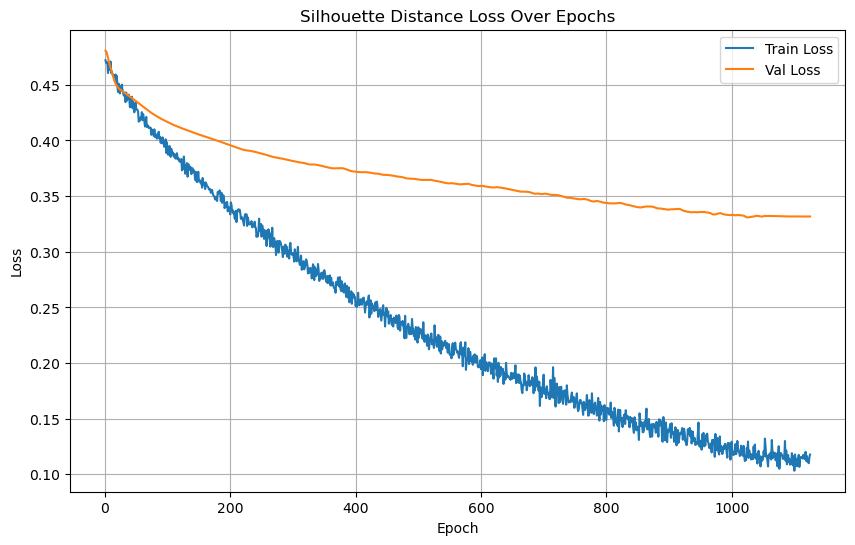

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/667], Loss: 0.2752
Test Batch [20/667], Loss: 0.2559
Test Batch [30/667], Loss: 0.2402
Test Batch [40/667], Loss: 0.3019


Test Batch [50/667], Loss: 0.4014
Test Batch [60/667], Loss: 0.2840
Test Batch [70/667], Loss: 0.2762
Test Batch [80/667], Loss: 0.1789


Test Batch [90/667], Loss: 0.4157
Test Batch [100/667], Loss: 0.1966
Test Batch [110/667], Loss: 0.1539
Test Batch [120/667], Loss: 0.2421


Test Batch [130/667], Loss: 0.3168
Test Batch [140/667], Loss: 0.2556
Test Batch [150/667], Loss: 0.3491
Test Batch [160/667], Loss: 0.5000
Test Batch [170/667], Loss: 0.5000


Test Batch [180/667], Loss: 0.1794
Test Batch [190/667], Loss: 0.2363
Test Batch [200/667], Loss: 0.1629
Test Batch [210/667], Loss: 0.1502
Test Batch [220/667], Loss: 0.5000
Test Batch [230/667], Loss: 0.1493
Test Batch [240/667], Loss: 0.5000
Test Batch [250/667], Loss: 0.5000
Test Batch [260/667], Loss: 0.5000
Test Batch [270/667], Loss: 0.5000
Test Batch [280/667], Loss: 0.5000


Test Batch [290/667], Loss: 0.5000
Test Batch [300/667], Loss: 0.5000
Test Batch [310/667], Loss: 0.3808
Test Batch [320/667], Loss: 0.2458
Test Batch [330/667], Loss: 0.2199


Test Batch [340/667], Loss: 0.2133
Test Batch [350/667], Loss: 0.1743
Test Batch [360/667], Loss: 0.1979


Test Batch [370/667], Loss: 0.2001
Test Batch [380/667], Loss: 0.2020
Test Batch [390/667], Loss: 0.1429


Test Batch [400/667], Loss: 0.1311
Test Batch [410/667], Loss: 0.2192
Test Batch [420/667], Loss: 0.2010


Test Batch [430/667], Loss: 0.2301
Test Batch [440/667], Loss: 0.3707
Test Batch [450/667], Loss: 0.1953
Test Batch [460/667], Loss: 0.4229


Test Batch [470/667], Loss: 0.3550
Test Batch [480/667], Loss: 0.3694
Test Batch [490/667], Loss: 0.2994
Test Batch [500/667], Loss: 0.3225


Test Batch [510/667], Loss: 0.1631
Test Batch [520/667], Loss: 0.2144
Test Batch [530/667], Loss: 0.2796
Test Batch [540/667], Loss: 0.2503


Test Batch [550/667], Loss: 0.3441
Test Batch [560/667], Loss: 0.2514
Test Batch [570/667], Loss: 0.2188
Test Batch [580/667], Loss: 0.2302


Test Batch [590/667], Loss: 0.2343
Test Batch [600/667], Loss: 0.3191
Test Batch [610/667], Loss: 0.3358
Test Batch [620/667], Loss: 0.3887


Test Batch [630/667], Loss: 0.3045
Test Batch [640/667], Loss: 0.1651
Test Batch [650/667], Loss: 0.4106


Test Batch [660/667], Loss: 0.4172

Test Loss: 0.2977


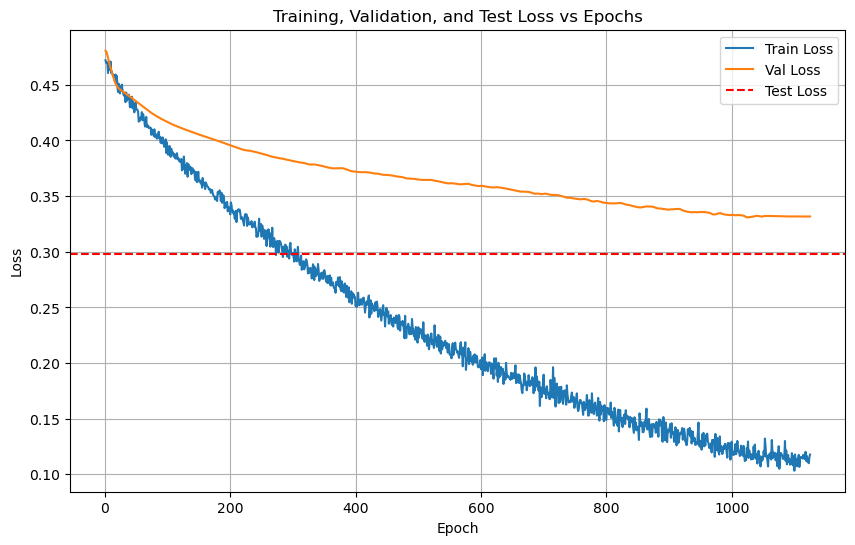

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/667 for test dataset.
  Processed batch 20/667 for test dataset.
  Processed batch 30/667 for test dataset.


  Processed batch 40/667 for test dataset.


  Processed batch 50/667 for test dataset.
  Processed batch 60/667 for test dataset.
  Processed batch 70/667 for test dataset.


  Processed batch 80/667 for test dataset.


  Processed batch 90/667 for test dataset.
  Processed batch 100/667 for test dataset.
  Processed batch 110/667 for test dataset.


  Processed batch 120/667 for test dataset.


  Processed batch 130/667 for test dataset.
  Processed batch 140/667 for test dataset.


  Processed batch 150/667 for test dataset.
  Processed batch 160/667 for test dataset.
  Processed batch 170/667 for test dataset.
  Processed batch 180/667 for test dataset.


  Processed batch 190/667 for test dataset.
  Processed batch 200/667 for test dataset.
  Processed batch 210/667 for test dataset.
  Processed batch 220/667 for test dataset.


  Processed batch 230/667 for test dataset.
  Processed batch 240/667 for test dataset.
  Processed batch 250/667 for test dataset.


  Processed batch 260/667 for test dataset.
  Processed batch 270/667 for test dataset.
  Processed batch 280/667 for test dataset.


  Processed batch 290/667 for test dataset.
  Processed batch 300/667 for test dataset.
  Processed batch 310/667 for test dataset.
  Processed batch 320/667 for test dataset.


  Processed batch 330/667 for test dataset.
  Processed batch 340/667 for test dataset.
  Processed batch 350/667 for test dataset.
  Processed batch 360/667 for test dataset.


  Processed batch 370/667 for test dataset.
  Processed batch 380/667 for test dataset.
  Processed batch 390/667 for test dataset.
  Processed batch 400/667 for test dataset.


  Processed batch 410/667 for test dataset.
  Processed batch 420/667 for test dataset.
  Processed batch 430/667 for test dataset.


  Processed batch 440/667 for test dataset.
  Processed batch 450/667 for test dataset.
  Processed batch 460/667 for test dataset.


  Processed batch 470/667 for test dataset.
  Processed batch 480/667 for test dataset.


  Processed batch 490/667 for test dataset.
  Processed batch 500/667 for test dataset.
  Processed batch 510/667 for test dataset.
  Processed batch 520/667 for test dataset.


  Processed batch 530/667 for test dataset.
  Processed batch 540/667 for test dataset.
  Processed batch 550/667 for test dataset.
  Processed batch 560/667 for test dataset.


  Processed batch 570/667 for test dataset.
  Processed batch 580/667 for test dataset.
  Processed batch 590/667 for test dataset.


  Processed batch 600/667 for test dataset.
  Processed batch 610/667 for test dataset.
  Processed batch 620/667 for test dataset.


  Processed batch 630/667 for test dataset.
  Processed batch 640/667 for test dataset.
  Processed batch 650/667 for test dataset.


  Processed batch 660/667 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 73.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.71      1.00      0.83         5
           2       0.57      0.80      0.67         5
           3       1.00      0.60      0.75         5
           4       1.00      1.00      1.00         5
           5       0.80      0.80      0.80         5
           6       0.50      0.80      0.62         5
           7       1.00      0.20      0.33         5
           8       1.00      1.00      1.00         5

    accuracy                           0.73        45
   macro avg       0.79      0.73      0.72        45
weighted avg       0.79      0.73      0.72        45


LOG: Evaluating on the test set...
Test Accuracy: 63.47%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.0921  |  Val Loss: 2.1062
Validation loss improved from inf to 2.1062.
[Epoch 2/1000] Train Loss: 2.0553  |  Val Loss: 2.0797
Validation loss improved from 2.1062 to 2.0797.
[Epoch 3/1000] Train Loss: 2.0161  |  Val Loss: 2.0545
Validation loss improved from 2.0797 to 2.0545.
[Epoch 4/1000] Train Loss: 1.9833  |  Val Loss: 2.0306
Validation loss improved from 2.0545 to 2.0306.
[Epoch 5/1000] Train Loss: 1.9511  |  Val Loss: 2.0078
Validation loss improved from 2.0306 to 2.0078.
[Epoch 6/1000] Train Loss: 1.9211  |  Val Loss: 1.9870
Validation loss improved from 2.0078 to 1.9870.
[Epoch 7/1000] Train Loss: 1.8961  |  Val Loss: 1.9681
Validation loss improved from 1.9870 to 1.9681.
[Epoch 8/1000] Train Loss: 1.8684  |  Val Loss: 1.9510
Validation loss improved from 1.9681 to 1.9510.
[Epoch 9/1000] Train Loss: 1.8465  |  Val Loss: 1.9349
Validation loss improved from 1.9510 to 1.9349.
[Epoch 10/1000] Train Loss: 1.8238  |  Val Loss: 1.9201
Validation loss impr

[Epoch 42/1000] Train Loss: 1.4238  |  Val Loss: 1.6526
Validation loss improved from 1.6581 to 1.6526.
[Epoch 43/1000] Train Loss: 1.4152  |  Val Loss: 1.6473
Validation loss improved from 1.6526 to 1.6473.
[Epoch 44/1000] Train Loss: 1.4067  |  Val Loss: 1.6421
Validation loss improved from 1.6473 to 1.6421.
[Epoch 45/1000] Train Loss: 1.3983  |  Val Loss: 1.6370
Validation loss improved from 1.6421 to 1.6370.
[Epoch 46/1000] Train Loss: 1.3899  |  Val Loss: 1.6321
Validation loss improved from 1.6370 to 1.6321.
[Epoch 47/1000] Train Loss: 1.3817  |  Val Loss: 1.6273
Validation loss improved from 1.6321 to 1.6273.
[Epoch 48/1000] Train Loss: 1.3734  |  Val Loss: 1.6226
Validation loss improved from 1.6273 to 1.6226.
[Epoch 49/1000] Train Loss: 1.3655  |  Val Loss: 1.6180
Validation loss improved from 1.6226 to 1.6180.
[Epoch 50/1000] Train Loss: 1.3577  |  Val Loss: 1.6134
Validation loss improved from 1.6180 to 1.6134.
[Epoch 51/1000] Train Loss: 1.3497  |  Val Loss: 1.6089
Validati

[Epoch 87/1000] Train Loss: 1.0824  |  Val Loss: 1.4637
Validation loss improved from 1.4678 to 1.4637.
[Epoch 88/1000] Train Loss: 1.0747  |  Val Loss: 1.4596
Validation loss improved from 1.4637 to 1.4596.
[Epoch 89/1000] Train Loss: 1.0672  |  Val Loss: 1.4556
Validation loss improved from 1.4596 to 1.4556.
[Epoch 90/1000] Train Loss: 1.0595  |  Val Loss: 1.4517
Validation loss improved from 1.4556 to 1.4517.
[Epoch 91/1000] Train Loss: 1.0517  |  Val Loss: 1.4477
Validation loss improved from 1.4517 to 1.4477.
[Epoch 92/1000] Train Loss: 1.0441  |  Val Loss: 1.4437
Validation loss improved from 1.4477 to 1.4437.
[Epoch 93/1000] Train Loss: 1.0365  |  Val Loss: 1.4397
Validation loss improved from 1.4437 to 1.4397.
[Epoch 94/1000] Train Loss: 1.0288  |  Val Loss: 1.4359
Validation loss improved from 1.4397 to 1.4359.
[Epoch 95/1000] Train Loss: 1.0208  |  Val Loss: 1.4320
Validation loss improved from 1.4359 to 1.4320.
[Epoch 96/1000] Train Loss: 1.0134  |  Val Loss: 1.4282
Validati

[Epoch 131/1000] Train Loss: 0.7383  |  Val Loss: 1.2906
Validation loss improved from 1.2947 to 1.2906.
[Epoch 132/1000] Train Loss: 0.7302  |  Val Loss: 1.2865
Validation loss improved from 1.2906 to 1.2865.
[Epoch 133/1000] Train Loss: 0.7220  |  Val Loss: 1.2824
Validation loss improved from 1.2865 to 1.2824.
[Epoch 134/1000] Train Loss: 0.7139  |  Val Loss: 1.2782
Validation loss improved from 1.2824 to 1.2782.
[Epoch 135/1000] Train Loss: 0.7058  |  Val Loss: 1.2741
Validation loss improved from 1.2782 to 1.2741.
[Epoch 136/1000] Train Loss: 0.6977  |  Val Loss: 1.2699
Validation loss improved from 1.2741 to 1.2699.
[Epoch 137/1000] Train Loss: 0.6896  |  Val Loss: 1.2658
Validation loss improved from 1.2699 to 1.2658.
[Epoch 138/1000] Train Loss: 0.6816  |  Val Loss: 1.2617
Validation loss improved from 1.2658 to 1.2617.
[Epoch 139/1000] Train Loss: 0.6735  |  Val Loss: 1.2577
Validation loss improved from 1.2617 to 1.2577.
[Epoch 140/1000] Train Loss: 0.6652  |  Val Loss: 1.253

[Epoch 171/1000] Train Loss: 0.4374  |  Val Loss: 1.1366
Validation loss improved from 1.1406 to 1.1366.
[Epoch 172/1000] Train Loss: 0.4308  |  Val Loss: 1.1327
Validation loss improved from 1.1366 to 1.1327.
[Epoch 173/1000] Train Loss: 0.4246  |  Val Loss: 1.1289
Validation loss improved from 1.1327 to 1.1289.
[Epoch 174/1000] Train Loss: 0.4179  |  Val Loss: 1.1254
Validation loss improved from 1.1289 to 1.1254.
[Epoch 175/1000] Train Loss: 0.4117  |  Val Loss: 1.1217
Validation loss improved from 1.1254 to 1.1217.
[Epoch 176/1000] Train Loss: 0.4058  |  Val Loss: 1.1179
Validation loss improved from 1.1217 to 1.1179.
[Epoch 177/1000] Train Loss: 0.3993  |  Val Loss: 1.1142
Validation loss improved from 1.1179 to 1.1142.
[Epoch 178/1000] Train Loss: 0.3934  |  Val Loss: 1.1105
Validation loss improved from 1.1142 to 1.1105.
[Epoch 179/1000] Train Loss: 0.3875  |  Val Loss: 1.1070
Validation loss improved from 1.1105 to 1.1070.
[Epoch 180/1000] Train Loss: 0.3814  |  Val Loss: 1.103

[Epoch 216/1000] Train Loss: 0.2195  |  Val Loss: 1.0063
Validation loss improved from 1.0085 to 1.0063.
[Epoch 217/1000] Train Loss: 0.2160  |  Val Loss: 1.0042
Validation loss improved from 1.0063 to 1.0042.
[Epoch 218/1000] Train Loss: 0.2127  |  Val Loss: 1.0020
Validation loss improved from 1.0042 to 1.0020.
[Epoch 219/1000] Train Loss: 0.2096  |  Val Loss: 0.9999
Validation loss improved from 1.0020 to 0.9999.
[Epoch 220/1000] Train Loss: 0.2063  |  Val Loss: 0.9979
Validation loss improved from 0.9999 to 0.9979.
[Epoch 221/1000] Train Loss: 0.2033  |  Val Loss: 0.9960
Validation loss improved from 0.9979 to 0.9960.
[Epoch 222/1000] Train Loss: 0.2003  |  Val Loss: 0.9942
Validation loss improved from 0.9960 to 0.9942.
[Epoch 223/1000] Train Loss: 0.1972  |  Val Loss: 0.9925
Validation loss improved from 0.9942 to 0.9925.
[Epoch 224/1000] Train Loss: 0.1944  |  Val Loss: 0.9909
Validation loss improved from 0.9925 to 0.9909.
[Epoch 225/1000] Train Loss: 0.1915  |  Val Loss: 0.989

[Epoch 262/1000] Train Loss: 0.1139  |  Val Loss: 0.9503
Validation loss improved from 0.9506 to 0.9503.
[Epoch 263/1000] Train Loss: 0.1125  |  Val Loss: 0.9499
Validation loss improved from 0.9503 to 0.9499.
[Epoch 264/1000] Train Loss: 0.1110  |  Val Loss: 0.9495
Validation loss improved from 0.9499 to 0.9495.
[Epoch 265/1000] Train Loss: 0.1096  |  Val Loss: 0.9492
Validation loss improved from 0.9495 to 0.9492.
[Epoch 266/1000] Train Loss: 0.1082  |  Val Loss: 0.9488
Validation loss improved from 0.9492 to 0.9488.
[Epoch 267/1000] Train Loss: 0.1067  |  Val Loss: 0.9484
Validation loss improved from 0.9488 to 0.9484.
[Epoch 268/1000] Train Loss: 0.1054  |  Val Loss: 0.9478
Validation loss improved from 0.9484 to 0.9478.
[Epoch 269/1000] Train Loss: 0.1041  |  Val Loss: 0.9473
Validation loss improved from 0.9478 to 0.9473.
[Epoch 270/1000] Train Loss: 0.1028  |  Val Loss: 0.9469
Validation loss improved from 0.9473 to 0.9469.
[Epoch 271/1000] Train Loss: 0.1015  |  Val Loss: 0.946

[Epoch 305/1000] Train Loss: 0.0677  |  Val Loss: 0.9433
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 306/1000] Train Loss: 0.0669  |  Val Loss: 0.9432
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 307/1000] Train Loss: 0.0662  |  Val Loss: 0.9429
Validation loss improved from 0.9430 to 0.9429.
[Epoch 308/1000] Train Loss: 0.0655  |  Val Loss: 0.9427
Validation loss improved from 0.9429 to 0.9427.
[Epoch 309/1000] Train Loss: 0.0647  |  Val Loss: 0.9425
Validation loss improved from 0.9427 to 0.9425.
[Epoch 310/1000] Train Loss: 0.0640  |  Val Loss: 0.9425
Validation loss improved from 0.9425 to 0.9425.
[Epoch 311/1000] Train Loss: 0.0634  |  Val Loss: 0.9425
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 312/1000] Train Loss: 0.0627  |  Val Loss: 0.9423
Validation loss improved from 0.9425 to 0.9423.
[Epoch 313/1000] Train Loss: 0.0620  |  Val Loss: 0.9423
Validation loss improved from 0.9423 to 0.9423.
[Epoch 314/1000] Train Loss: 0.0614  

[Epoch 348/1000] Train Loss: 0.0438  |  Val Loss: 0.9508
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 349/1000] Train Loss: 0.0434  |  Val Loss: 0.9512
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 350/1000] Train Loss: 0.0430  |  Val Loss: 0.9515
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 351/1000] Train Loss: 0.0426  |  Val Loss: 0.9518
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 352/1000] Train Loss: 0.0422  |  Val Loss: 0.9520
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 353/1000] Train Loss: 0.0418  |  Val Loss: 0.9521
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 354/1000] Train Loss: 0.0415  |  Val Loss: 0.9523
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 355/1000] Train Loss: 0.0411  |  Val Loss: 0.9524
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 356/1000] Train Loss: 0.0408  |  Val Loss: 0.9525
!! Validation loss did NOT improve !! Patience:

[Epoch 394/1000] Train Loss: 0.0297  |  Val Loss: 0.9573
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 395/1000] Train Loss: 0.0295  |  Val Loss: 0.9572
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 396/1000] Train Loss: 0.0292  |  Val Loss: 0.9572
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 397/1000] Train Loss: 0.0290  |  Val Loss: 0.9571
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 398/1000] Train Loss: 0.0288  |  Val Loss: 0.9572
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 399/1000] Train Loss: 0.0286  |  Val Loss: 0.9573
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 400/1000] Train Loss: 0.0284  |  Val Loss: 0.9575
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 401/1000] Train Loss: 0.0281  |  Val Loss: 0.9577
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 402/1000] Train Loss: 0.0279  |  Val Loss: 0.9577
!! Validation loss did NOT improve !! Patience:

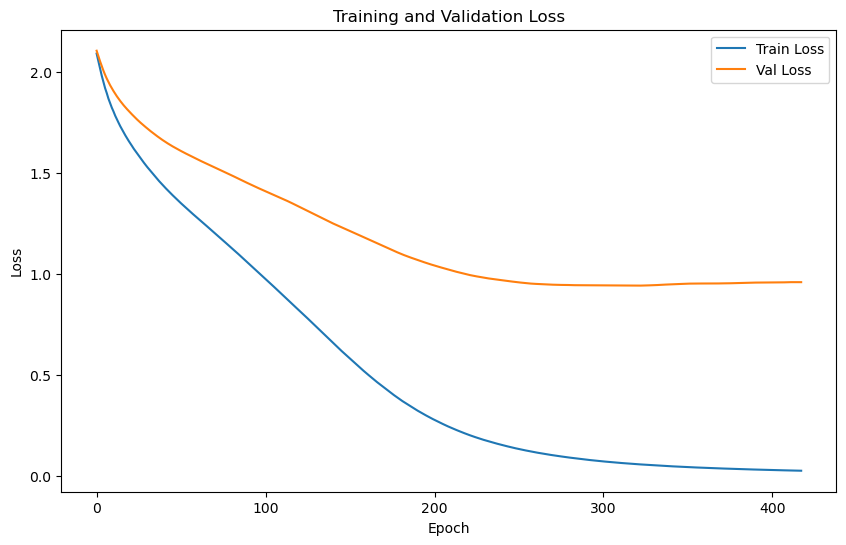

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.5133 | Test Accuracy: 65.45%


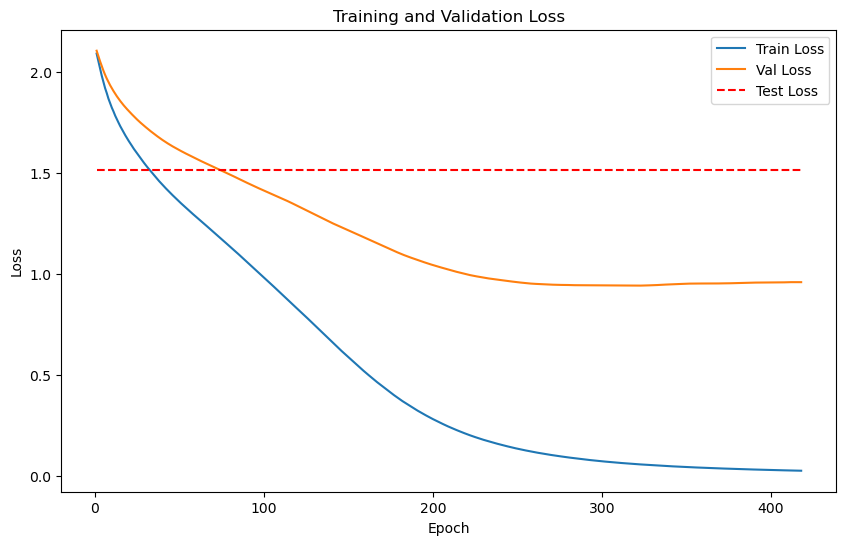

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


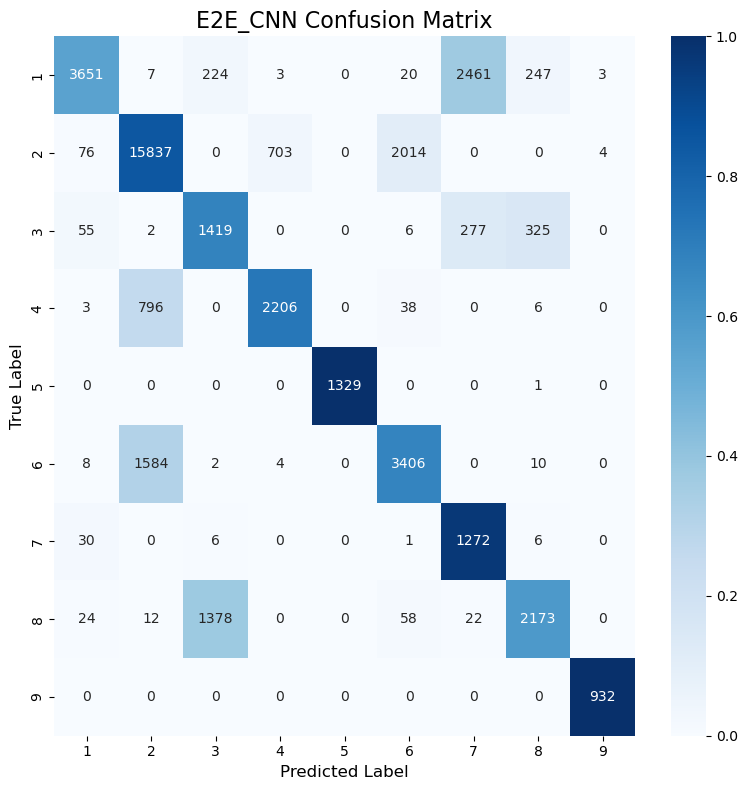

Classification Accuracy: 75.57%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


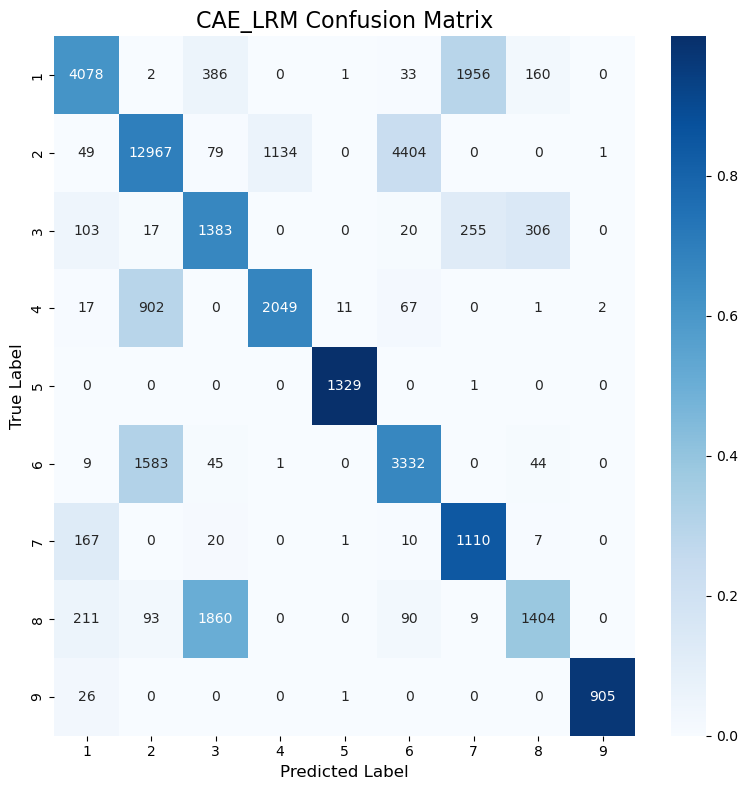

Classification Accuracy: 66.97%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


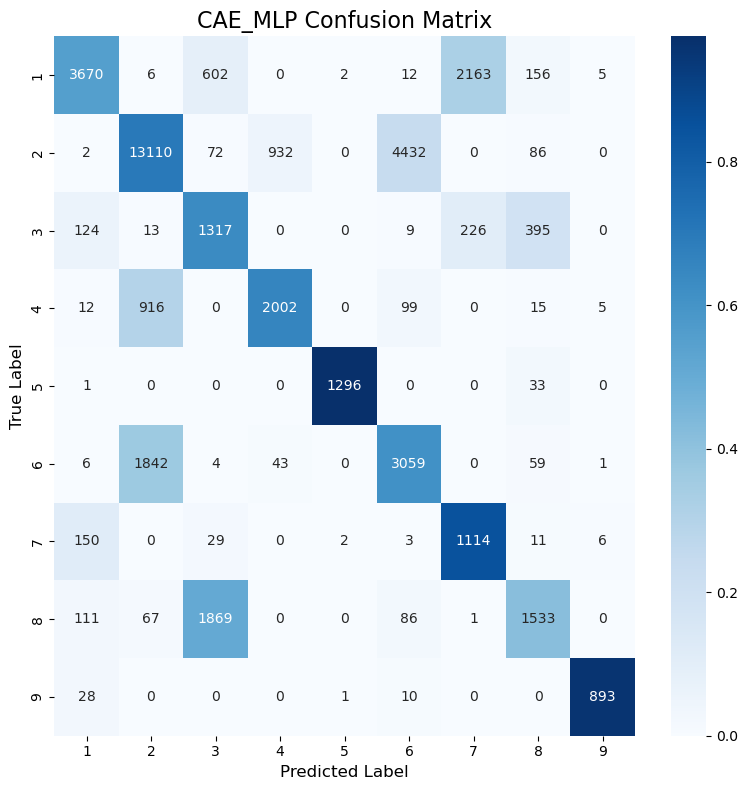

Classification Accuracy: 65.65%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


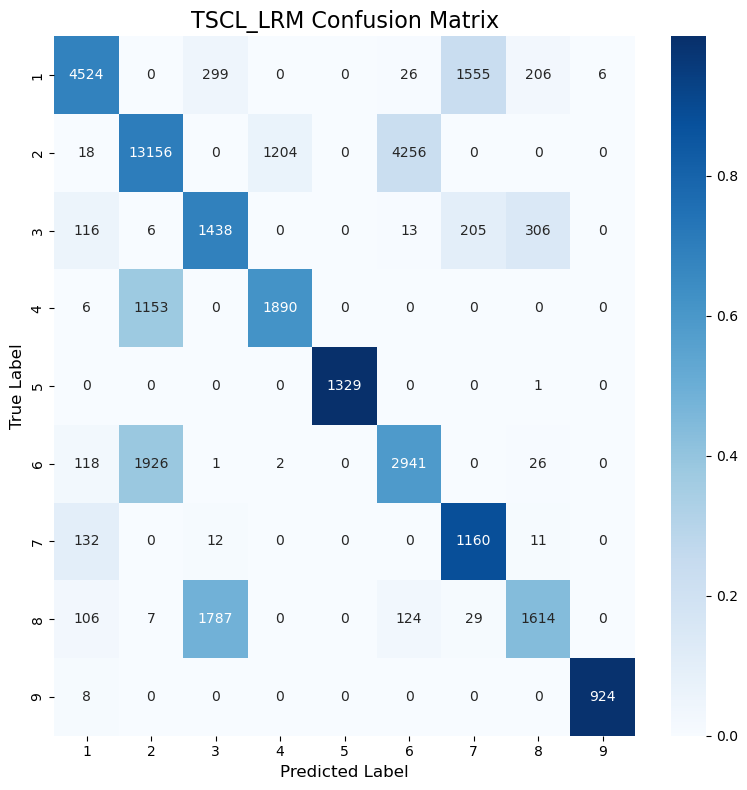

Classification Accuracy: 67.95%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


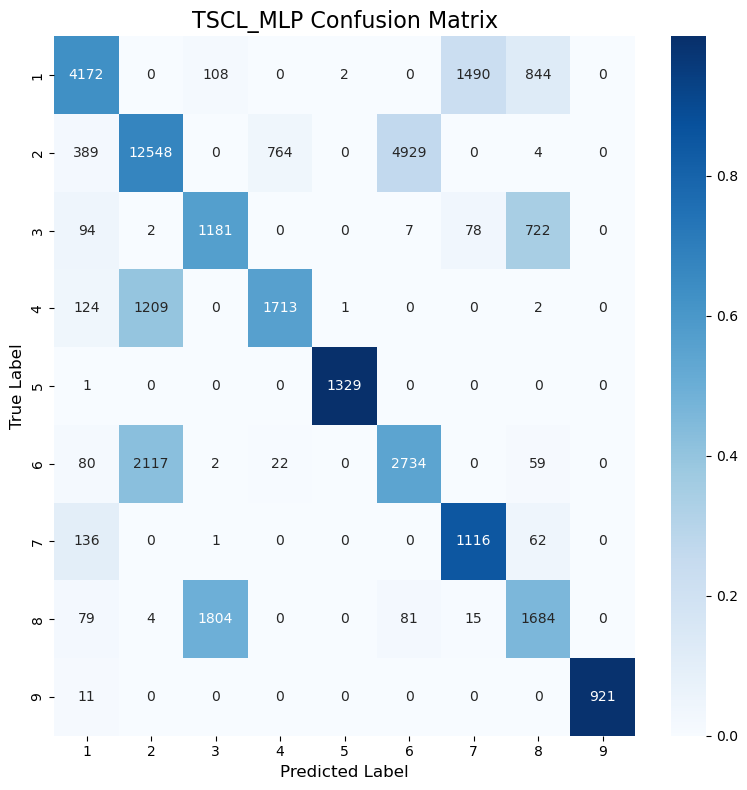

Classification Accuracy: 64.25%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


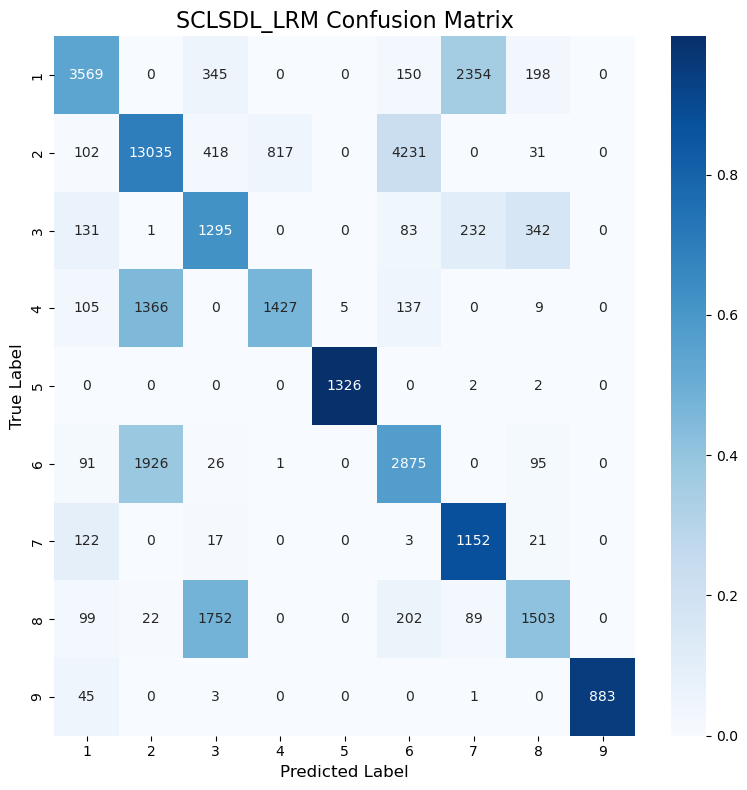

Classification Accuracy: 63.47%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


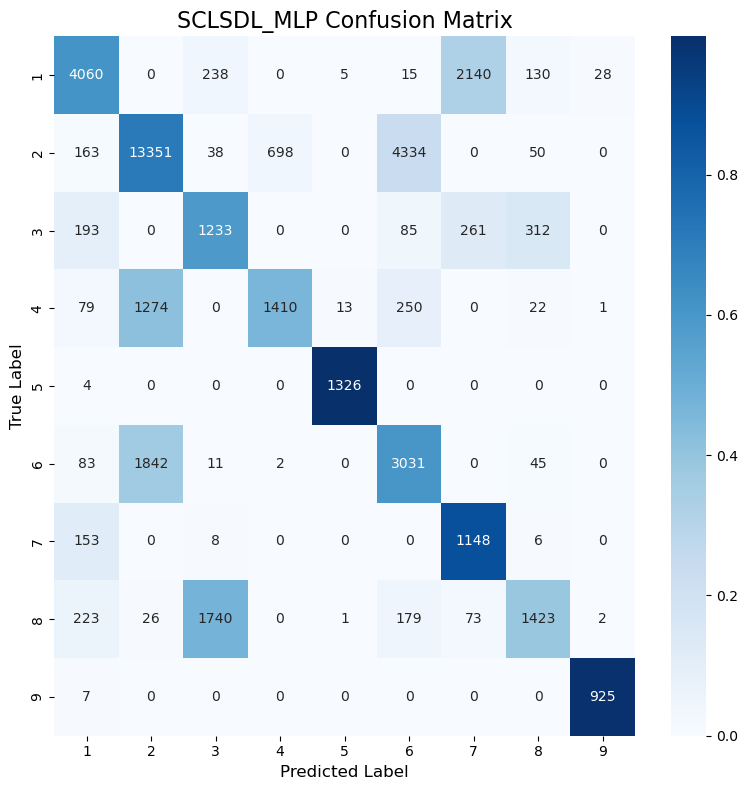

Classification Accuracy: 65.45%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          75.57
1    LRM (CAE)          66.97
2    MLP (CAE)          65.65
3     TSCL LRM          67.95
4     TSCL MLP          64.25
5  SCL_SDL LRM          63.47
6  SCL_SDL MLP          65.45

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          75.57
3     TSCL LRM          67.95
1    LRM (CAE)          66.97
2    MLP (CAE)          65.65
6  SCL_SDL MLP          65.45
4     TSCL MLP          64.25
5  SCL_SDL LRM          63.47
